# Energy Comparison Analysis: Surrogate Gradient vs STDP

This notebook provides analysis blocks for comparing energy consumption between:
1. **Surrogate Gradient SNN** (PyTorch, backprop-trained)
2. **STDP Network** (Brian2, unsupervised)

## Analysis Structure:
- **Block 1**: Hardware specifications database
- **Block 2**: Network statistics from your trained models
- **Block 3**: Training energy comparison (within-network, accuracy-based)
- **Block 4**: Inference energy comparison
- **Block 5**: Iso-accuracy analysis
- **Block 6**: Comprehensive visualization

In [1]:
# Install brian2 directly from the main GitHub branch
!pip install git+https://github.com/brian-team/brian2.git


  Cloning https://github.com/brian-team/brian2.git to /tmp/pip-req-build-pvuims5d
  Running command git clone --filter=blob:none --quiet https://github.com/brian-team/brian2.git /tmp/pip-req-build-pvuims5d
  Resolved https://github.com/brian-team/brian2.git to commit 9578631abe31bdcd0465f417a56e62689f15ade6
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for Brian2: filename=brian2-2.10.1.post20-cp312-cp312-linux_x86_64.whl size=2211841 sha256=4bae14eac5da5e0d2e25f1cbbcb1016115f6cf0fd67ab0cb58c60ddd6ba53cfb
  Stored in directory: /tmp/pip-ephem-wheel-cache-6l0vvjqj/wheels/07/0c/0f/054711e0c9afb7fa8d6a9501b0cd760d060469a745c9e91d92
Successfully built Brian2


In [2]:
# =============================================================================
# Block 0: Imports and Setup
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple
import seaborn as sns
import pickle

import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import brian2 as b2
from brian2 import *
import time

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

print("Energy analysis imports loaded successfully")

Energy analysis imports loaded successfully


---
## Block 1: Hardware Specifications Database

Energy consumption varies dramatically by hardware platform. This database contains:
- **Neuromorphic chips**: Loihi 2, TrueNorth, SpiNNaker 2, BrainScaleS-2
- **Digital accelerators**: GPU (V100, L4), Edge TPU

Key parameters:
- `energy_per_spike_pj`: Energy per spike event (picojoules)
- `energy_per_mac_pj`: Energy per multiply-accumulate operation
- `static_power_mw`: Idle power consumption

In [3]:
# =============================================================================
# Block 1: Hardware Specifications Database
# =============================================================================

@dataclass
class HardwareSpec:
    """Hardware platform specifications for energy modeling."""
    name: str
    energy_per_spike_pj: float      # picojoules per spike
    energy_per_mac_pj: float        # picojoules per MAC operation
    static_power_mw: float          # milliwatts idle power
    platform_type: str              # 'neuromorphic' or 'digital'
    year: int

HARDWARE_DB = {
    # ===== Neuromorphic Platforms =====
    'loihi2': HardwareSpec(
        name='Intel Loihi 2',
        energy_per_spike_pj=23.6,
        energy_per_mac_pj=850,
        static_power_mw=10,
        platform_type='neuromorphic',
        year=2021
    ),
    'truenorth': HardwareSpec(
        name='IBM TrueNorth',
        energy_per_spike_pj=26,
        energy_per_mac_pj=1000,
        static_power_mw=65,
        platform_type='neuromorphic',
        year=2014
    ),
    'spinnaker2': HardwareSpec(
        name='SpiNNaker 2',
        energy_per_spike_pj=10,
        energy_per_mac_pj=500,
        static_power_mw=100,
        platform_type='neuromorphic',
        year=2021
    ),
    'brainscales2': HardwareSpec(
        name='BrainScaleS-2',
        energy_per_spike_pj=0.2,  # Analog accelerated
        energy_per_mac_pj=100,
        static_power_mw=200,
        platform_type='neuromorphic',
        year=2020
    ),
    # ===== Digital Platforms =====
    'gpu_v100': HardwareSpec(
        name='NVIDIA V100',
        energy_per_spike_pj=5000,
        energy_per_mac_pj=0.4,
        static_power_mw=35000,
        platform_type='digital',
        year=2017
    ),
    'gpu_l4': HardwareSpec(
        name='NVIDIA L4',
        energy_per_spike_pj=3500,
        energy_per_mac_pj=0.35,
        static_power_mw=20000,
        platform_type='digital',
        year=2023
    ),
    'edge_tpu': HardwareSpec(
        name='Edge TPU',
        energy_per_spike_pj=2000,
        energy_per_mac_pj=0.25,
        static_power_mw=500,
        platform_type='digital',
        year=2018
    ),
    # ===== CPU Baseline =====
    'cpu_xeon': HardwareSpec(
        name='Intel Xeon (Brian2)',
        energy_per_spike_pj=10000,
        energy_per_mac_pj=10,
        static_power_mw=65000,
        platform_type='digital',
        year=2020
    ),
}

# Display hardware database
print("Hardware Specifications Database")
print("=" * 80)
print(f"{'Platform':<20} {'Spike (pJ)':<12} {'MAC (pJ)':<12} {'Static (mW)':<12} {'Type':<15}")
print("-" * 80)
for key, hw in HARDWARE_DB.items():
    print(f"{hw.name:<20} {hw.energy_per_spike_pj:<12.1f} {hw.energy_per_mac_pj:<12.2f} "
          f"{hw.static_power_mw:<12.0f} {hw.platform_type:<15}")

Hardware Specifications Database
Platform             Spike (pJ)   MAC (pJ)     Static (mW)  Type           
--------------------------------------------------------------------------------
Intel Loihi 2        23.6         850.00       10           neuromorphic   
IBM TrueNorth        26.0         1000.00      65           neuromorphic   
SpiNNaker 2          10.0         500.00       100          neuromorphic   
BrainScaleS-2        0.2          100.00       200          neuromorphic   
NVIDIA V100          5000.0       0.40         35000        digital        
NVIDIA L4            3500.0       0.35         20000        digital        
Edge TPU             2000.0       0.25         500          digital        
Intel Xeon (Brian2)  10000.0      10.00        65000        digital        


In [5]:
class BiologicalSTDPNetwork:
    """
    STDP Network exactly matching Diehl & Cook (2015).
    "Unsupervised learning of digit recognition using spike-timing-dependent plasticity
    Parameters taken from paper Section 2
    """

    def __init__(self, n_input=784, n_excitatory=400, n_inhibitory=400):
        self.n_input = n_input
        self.n_exc = n_excitatory
        self.n_inh = n_inhibitory

        # ==============================================
        # EXACT parameters from Diehl & Cook (2015)
        # ==============================================
        self.params = {
            # Membrane parameters (Section 2.1)
            'v_rest_e': -65 * mV,
            'v_rest_i': -60 * mV,
            'v_reset_e': -65 * mV,
            'v_reset_i': -45 * mV,
            'v_thresh_e': -52 * mV,
            'v_thresh_i': -40 * mV,

            # Time constants
            # Paper Section 2.1: "Increasing the time constant of the excitatory
            # neuron membrane potential to 100 ms greatly increased accuracy"
            'tau_mem_e': 100 * ms,
            'tau_mem_i': 10 * ms,

            # Refractory periods
            'refrac_e': 5 * ms,
            'refrac_i': 2 * ms,

            # Reversal potentials (Section 2.1)
            'E_exc': 0 * mV,
            'E_inh': -100 * mV,

            # Conductance time constants (from code)
            'tau_ge': 1 * ms,
            'tau_gi': 2 * ms,

            # STDP parameters (Section 2.3, Equations 5 & 6)
            # Pre-and-post STDP rule from paper
            'tau_pre': 20 * ms,
            'tau_post': 20 * ms,
            'eta_pre': 0.0001,     # nu_ee_pre - LTD rate
            'eta_post': 0.01,      # nu_ee_post - LTP rate
            'mu': 0.4,             # Weight dependence exponent
            'x_tar': 0.4,          # Target pre-synaptic trace
            'wmax': 1.0,

            # Homeostasis parameters (Section 2.4)
            # "each excitatory neuron's membrane threshold is not only determined
            # by v_thresh but by the sum v_thresh + θ"
            'theta_plus': 0.05 * mV,
            'tau_theta': 1e7 * ms,  # Very slow decay

            # Connection strengths (from code, tuned for competition)
            'w_ei': 10.4,           # Exc → Inh weight
            'w_ie': 17.0,           # Inh → Exc weight
        }

        # Weight normalization target (Section 2.3)
        # Sum of weights to each neuron normalized to this value
        self.weight_norm_target = 78.4

        # Data storage
        self.final_weights = None
        self.training_time = 0
        self.net = None

    def build_network(self):
        """Construct all neurons and synapses matching paper architecture."""
        import sys

        # ==============================================
        # Input layer: Poisson spike generators
        # Section 2.5: rates proportional to pixel intensity
        # ==============================================
        self.input_group = PoissonGroup(
            self.n_input,
            rates=np.zeros(self.n_input) * Hz
        )

        # ==============================================
        # Excitatory neurons (Section 2.1, 2.2)
        # Conductance-based LIF with adaptive threshold
        # Equation 1: τ(dV/dt) = (E_rest - V) + g_e(E_exc - V) + g_i(E_inh - V)
        # ==============================================
        eqs_exc = '''
        dv/dt = (v_rest_e - v + ge*(E_exc - v) + gi*(E_inh - v)) / tau_mem_e : volt (unless refractory)
        dge/dt = -ge / tau_ge : 1
        dgi/dt = -gi / tau_gi : 1
        dtheta/dt = -theta / tau_theta : volt
        '''

        self.exc_neurons = NeuronGroup(
            self.n_exc,
            eqs_exc,
            threshold='v > v_thresh_e + theta',
            reset='v = v_reset_e; theta += theta_plus',
            refractory='refrac_e',
            method='euler',
            namespace=self.params
        )
        self.exc_neurons.v = self.params['v_rest_e']
        self.exc_neurons.theta = 0 * mV  # Start with no adaptation

        # ==============================================
        # Inhibitory neurons (Section 2.2)
        # ==============================================
        eqs_inh = '''
        dv/dt = (v_rest_i - v + ge*(E_exc - v)) / tau_mem_i : volt (unless refractory)
        dge/dt = -ge / tau_ge : 1
        '''

        self.inh_neurons = NeuronGroup(
            self.n_inh,
            eqs_inh,
            threshold='v > v_thresh_i',
            reset='v = v_reset_i',
            refractory='refrac_i',
            method='euler',
            namespace=self.params
        )
        self.inh_neurons.v = self.params['v_rest_i']

        # ==============================================
        # Input → Excitatory STDP synapses
        # Section 2.3, Equations 5 & 6 (pre-and-post symmetric rule)
        #
        # Pre-spike (Eq 5): Δw = -η_pre * x_post * w^μ
        # Post-spike (Eq 6): Δw = +η_post * (x_pre - x_tar) * (w_max - w)^μ
        # ==============================================
        stdp_model = '''
        w : 1
        dApre/dt = -Apre / tau_pre : 1 (event-driven)
        dApost/dt = -Apost / tau_post : 1 (event-driven)
        '''

        # Pre-synaptic spike: deliver conductance, update trace, apply LTD
        on_pre = '''
        ge_post += w
        Apre += 1.0
        w = clip(w - eta_pre * Apost * (w ** mu), 0, wmax)
        '''

        # Post-synaptic spike: update trace, apply LTP
        on_post = '''
        Apost += 1.0
        w = clip(w + eta_post * (Apre - x_tar) * (clip(wmax - w, 0, wmax) ** mu), 0, wmax)
        '''

        self.syn_input_exc = Synapses(
            self.input_group,
            self.exc_neurons,
            model=stdp_model,
            on_pre=on_pre,
            on_post=on_post,
            namespace=self.params
        )

        # ALL-TO-ALL connectivity (Section 2.2, Figure 1)
        # "Poisson-spike trains are fed as input to excitatory neurons in an all-to-all fashion"
        self.syn_input_exc.connect()

        # Initialize weights randomly, then normalize
        self.syn_input_exc.w = 'rand() * wmax * 0.3'

        # ==============================================
        # Excitatory → Inhibitory (one-to-one)
        # Section 2.2: "connected in a one-to-one fashion"
        # ==============================================
        self.syn_exc_inh = Synapses(
            self.exc_neurons,
            self.inh_neurons,
            on_pre='ge_post += w_ei',
            namespace=self.params
        )
        self.syn_exc_inh.connect(j='i')  # Neuron i → Neuron i

        # ==============================================
        # Inhibitory → Excitatory (lateral inhibition)
        # Section 2.2: "connected to all excitatory ones,
        # except for the one from which it receives a connection"
        # ==============================================
        self.syn_inh_exc = Synapses(
            self.inh_neurons,
            self.exc_neurons,
            on_pre='gi_post += w_ie',
            namespace=self.params
        )
        self.syn_inh_exc.connect('i != j')

        # ==============================================
        # Monitors for analysis
        # ==============================================
        self.spike_mon_exc = SpikeMonitor(self.exc_neurons)
        self.spike_mon_inh = SpikeMonitor(self.inh_neurons)

        # ==============================================
        # Assemble network
        # ==============================================
        self.net = Network(
            self.input_group,
            self.exc_neurons,
            self.inh_neurons,
            self.syn_input_exc,
            self.syn_exc_inh,
            self.syn_inh_exc,
            self.spike_mon_exc,
            self.spike_mon_inh
        )

        # Initial weight normalization
        self.normalize_weights()

        print(f"Network built: {self.n_input} input → {self.n_exc} exc ↔ {self.n_inh} inh", flush=True)
        print(f"Input-Exc synapses: {len(self.syn_input_exc)} (all-to-all)", flush=True)
        print(f"STDP: eta_pre={self.params['eta_pre']}, eta_post={self.params['eta_post']}, mu={self.params['mu']}", flush=True)
        sys.stdout.flush()

    def normalize_weights(self):
        """
        Divisive weight normalization (Section 2.3).
        Ensures each excitatory neuron has the same total input weight.
        """
        w = np.zeros((self.n_input, self.n_exc))
        w[self.syn_input_exc.i[:], self.syn_input_exc.j[:]] = self.syn_input_exc.w[:]

        # Normalize each column (each exc neuron's inputs sum to weight_norm_target)
        col_sums = w.sum(axis=0)
        col_sums[col_sums == 0] = 1  # Avoid division by zero
        w = w * (self.weight_norm_target / col_sums)

        # Clip to valid range
        w = np.clip(w, 0, self.params['wmax'])

        self.syn_input_exc.w[:] = w[self.syn_input_exc.i[:], self.syn_input_exc.j[:]]

    def present_sample(self, rates_hz, min_spikes=5, max_attempts=5):
        """
        Present a single sample with adaptive rate boosting.

        Section 2.5: "if the excitatory neurons fire less than five spikes
        within 350ms, the maximum input firing rate is increased by 32 Hz
        and the example is presented again"
        """
        rate_boost = 0.0

        for attempt in range(max_attempts):
            n_before = self.spike_mon_exc.num_spikes

            # Set input rates
            self.input_group.rates = (rates_hz + rate_boost * Hz)

            # Present for 350ms (Section 2.5)
            self.net.run(350 * ms)

            n_after = self.spike_mon_exc.num_spikes
            n_spikes = n_after - n_before

            # Rest period: 150ms with no input (Section 2.6)
            # "there is a 150 ms phase without any input to allow all
            # variables of all neurons decay to their resting values"
            self.input_group.rates = np.zeros(self.n_input) * Hz
            self.net.run(150 * ms)

            if n_spikes >= min_spikes:
                return n_spikes, attempt + 1

            # Boost rate for next attempt (+32 Hz)
            rate_boost += 32.0

        return n_spikes, max_attempts

    def train(self, encoder, n_samples=60000, normalize_interval=20, print_interval=50):
        """
        Train the network on MNIST.

        Section 2.6: Weight normalization every 20 examples
        """
        import sys

        print(f"\n{'='*60}", flush=True)
        print(f"Training STDP Network - Diehl & Cook (2015)", flush=True)
        print(f"{'='*60}", flush=True)
        print(f"Samples: {n_samples}", flush=True)
        print(f"Normalize every {normalize_interval} samples", flush=True)
        sys.stdout.flush()

        if self.net is None:
            self.build_network()

        start_time = time.time()
        total_spikes = 0
        total_attempts = 0

        for i in range(n_samples):
            # Get image and convert to rates
            img, label = encoder.train_data[i % len(encoder.train_data)]
            rates = img.numpy().flatten() * encoder.max_rate * Hz

            # Present sample
            n_spikes, attempts = self.present_sample(rates)
            total_spikes += n_spikes
            total_attempts += attempts

            # Weight normalization every N samples (Section 2.6)
            if (i + 1) % normalize_interval == 0:
                self.normalize_weights()

            # Progress report
            if (i + 1) % print_interval == 0 or (i + 1) <= 5:
                elapsed = time.time() - start_time
                avg_spikes = total_spikes / (i + 1)
                avg_attempts = total_attempts / (i + 1)
                avg_time = elapsed / (i + 1)
                remaining = avg_time * (n_samples - i - 1)

                print(f"[{i+1:6d}/{n_samples}] "
                      f"spikes: {avg_spikes:.1f}, "
                      f"attempts: {avg_attempts:.2f}, "
                      f"θ: {np.mean(self.exc_neurons.theta / mV):.2f}mV, "
                      f"{avg_time:.1f}s/sample, "
                      f"ETA: {remaining/60:.0f}min", flush=True)
                sys.stdout.flush()

        self.training_time = time.time() - start_time
        self._save_final_state()

        print(f"\n{'='*60}", flush=True)
        print(f"Training complete!", flush=True)
        print(f"Total time: {self.training_time/60:.1f} min ({self.training_time/3600:.2f} h)", flush=True)
        print(f"Average spikes/sample: {total_spikes/n_samples:.1f}", flush=True)
        print(f"Average attempts/sample: {total_attempts/n_samples:.2f}", flush=True)
        print(f"{'='*60}", flush=True)
        sys.stdout.flush()

    def _save_final_state(self):
        """Save weights and thresholds for analysis."""
        w = np.zeros((self.n_input, self.n_exc))
        w[self.syn_input_exc.i[:], self.syn_input_exc.j[:]] = self.syn_input_exc.w[:]

        self.final_weights = {
            'weights': w,
            'theta': np.array(self.exc_neurons.theta / mV),
            'spike_counts_exc': np.array(self.spike_mon_exc.count[:]),
            'spike_counts_inh': np.array(self.spike_mon_inh.count[:]),
        }

    def get_response(self, rates_hz, duration=350*ms):
        """Get network response to an input (for testing/evaluation)."""
        n_before = np.array(self.spike_mon_exc.count[:]).copy()

        self.input_group.rates = rates_hz
        self.net.run(duration)
        self.input_group.rates = np.zeros(self.n_input) * Hz

        n_after = np.array(self.spike_mon_exc.count[:])
        return n_after - n_before


def load_network(filepath='stdp_network_checkpoint.pkl'):
    """
    Load a saved STDP network and restore its state.

    Supports both legacy checkpoints (training_time) and energy_v1 checkpoints
    (training_time_seconds, extra metadata).
    """
    import pickle
    import numpy as np
    from brian2 import mV, start_scope

    with open(filepath, 'rb') as f:
        checkpoint = pickle.load(f)

    print(f"Loading network from: {filepath}")

    # Create new network with same architecture
    network = BiologicalSTDPNetwork(
        n_input=int(checkpoint.get('n_input', 784)),
        n_excitatory=int(checkpoint.get('n_exc', checkpoint.get('n_excitatory', 400))),
        n_inhibitory=int(checkpoint.get('n_inh', checkpoint.get('n_inhibitory', 400))),
    )

    # Build the network
    network.build_network()

    # -----------------------------
    # Restore weights (dense 2D)
    # -----------------------------
    w = checkpoint.get('weights', None)
    if w is None:
        # Try common legacy nesting patterns
        fw = checkpoint.get('final_weights', None)
        if isinstance(fw, dict) and ('weights' in fw):
            w = fw['weights']

    if w is None:
        raise ValueError("Checkpoint does not contain 'weights' (or final_weights['weights']). Cannot restore network.")

    w = np.asarray(w)
    if w.ndim != 2 or w.shape != (network.n_input, network.n_exc):
        raise ValueError(f"Weight matrix shape mismatch: got {w.shape}, expected {(network.n_input, network.n_exc)}")

    network.syn_input_exc.w[:] = w[network.syn_input_exc.i[:], network.syn_input_exc.j[:]]

    # -----------------------------
    # Restore theta (unitless mV in checkpoint)
    # -----------------------------
    theta = checkpoint.get('theta', None)
    if theta is None:
        fw = checkpoint.get('final_weights', None)
        if isinstance(fw, dict) and ('theta' in fw):
            theta = fw['theta']

    if theta is None:
        print("  [WARN] No 'theta' found in checkpoint. Leaving theta at initialization.")
    else:
        network.exc_neurons.theta = np.asarray(theta) * mV

    # -----------------------------
    # Restore training stats (NEW vs OLD key names)
    # -----------------------------
    training_time = checkpoint.get('training_time_seconds', checkpoint.get('training_time', np.nan))
    network.training_time = float(training_time) if training_time is not None else np.nan

    # -----------------------------
    # Store final_weights (for downstream analysis convenience)
    # -----------------------------
    network.final_weights = {
        'weights': w,
        'theta': np.asarray(theta) if theta is not None else None,
        'spike_counts_exc': checkpoint.get('spike_counts_exc', np.zeros(network.n_exc)),
        'spike_counts_inh': checkpoint.get('spike_counts_inh', np.zeros(network.n_inh)),
    }

    print(f"  Network restored: {network.n_input} → {network.n_exc} exc ↔ {network.n_inh} inh")
    if np.isfinite(network.training_time):
        print(f"  Previous training time: {network.training_time:.1f}s")
    else:
        print("  Previous training time: (missing in checkpoint)")
    if theta is not None:
        print(f"  Mean theta: {np.asarray(theta).mean():.2f} mV")

    return network

# Load the checkpoint
stdp_net = load_network('stdp_checkpoint.pkl')

Loading network from: stdp_checkpoint.pkl
Network built: 784 input → 400 exc ↔ 400 inh
Input-Exc synapses: 313600 (all-to-all)
STDP: eta_pre=0.0001, eta_post=0.01, mu=0.4
  Network restored: 784 → 400 exc ↔ 400 inh
  Previous training time: 16639.9s
  Mean theta: 22.77 mV


---
## Block 2: Load Network Statistics

**Update these values with your actual training results!**

This block defines the statistics containers for both networks.

In [6]:
# =============================================================================
# Block 2: NetworkStats Class + Load Both Checkpoints
# =============================================================================

import torch
import numpy as np
import pickle
from dataclasses import dataclass

@dataclass
class NetworkStats:
    """Container for network energy-relevant statistics."""
    name: str
    learning_rule: str  # 'surrogate' or 'stdp'

    # Architecture
    n_input: int = 784
    n_hidden: int = 400
    n_output: int = 10

    # Training
    training_samples: int = 0
    training_time_seconds: float = 0
    training_epochs: int = 0
    training_accuracy: float = 0

    # Per-sample metrics
    spikes_per_sample: float = 0
    time_steps: int = 50

    # Inference
    inference_accuracy: float = 0
    spikes_per_inference: float = 0

    @property
    def n_synapses(self):
        return self.n_input * self.n_hidden + self.n_hidden * self.n_output

    @property
    def forward_macs(self):
        """MACs for one forward pass."""
        return (self.n_input * self.n_hidden + self.n_hidden * self.n_output) * self.time_steps


# =============================================================================
# LOAD SURROGATE CHECKPOINT (surrogate_complete_v1 schema)
# =============================================================================

print("=" * 60)
print("LOADING SURROGATE SNN CHECKPOINT")
print("=" * 60)

SURROGATE_CHECKPOINT = 'surrogate_snn_checkpoint.pth'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
surrogate_ckpt = torch.load(SURROGATE_CHECKPOINT, map_location=device, weights_only=False)

schema = surrogate_ckpt.get('schema_version', 'unknown')
print(f"Schema: {schema}")

# Extract from nested structure
n_hidden_sur = surrogate_ckpt['n_hidden']
n_input_sur = surrogate_ckpt.get('n_input', 784)
n_output_sur = surrogate_ckpt.get('n_output', 10)
time_window = surrogate_ckpt['encoding']['time_window']

training_results = surrogate_ckpt['training_results']
epochs_trained = training_results['epochs_trained']
total_training_samples_sur = training_results['total_samples']
training_time_sur = training_results['training_time_seconds']
best_val_acc = training_results['best_val_accuracy']
final_train_acc = training_results['final_train_accuracy']

test_accuracy_sur = surrogate_ckpt['test_accuracy']
training_history_sur = surrogate_ckpt['training_history']

# Spike data
sur_training_spikes = surrogate_ckpt['training_spikes']
sur_inference_spikes = surrogate_ckpt['inference_spikes']

# Spikes per inference (sum of all layers)
spikes_per_inference_sur = (
    sur_inference_spikes['input_per_inference'] +
    sur_inference_spikes['hidden_per_inference'] +
    sur_inference_spikes['output_per_inference']
)

# Energy proxies
sur_energy_proxies = surrogate_ckpt['energy_proxies']
sur_connectivity = surrogate_ckpt['connectivity']

surrogate_stats = NetworkStats(
    name="Surrogate Gradient SNN",
    learning_rule='surrogate',
    n_input=n_input_sur,
    n_hidden=n_hidden_sur,
    n_output=n_output_sur,
    training_samples=total_training_samples_sur,
    training_time_seconds=training_time_sur,
    training_epochs=epochs_trained,
    training_accuracy=final_train_acc,
    spikes_per_sample=spikes_per_inference_sur,
    time_steps=time_window,
    inference_accuracy=test_accuracy_sur,
    spikes_per_inference=spikes_per_inference_sur,
)

print(f"\n{surrogate_stats.name}:")
print(f"  Architecture: {n_input_sur} → {n_hidden_sur} → {n_output_sur}")
print(f"  Synapses: {surrogate_stats.n_synapses:,}")
print(f"  Time window: {time_window} steps")
print(f"  Training: {total_training_samples_sur:,} samples, {epochs_trained} epochs, {training_time_sur:.1f}s")
print(f"  Test accuracy: {test_accuracy_sur:.2f}%")
print(f"  Spikes/inference: {spikes_per_inference_sur:.1f}")
print(f"✓ Surrogate loaded")


# =============================================================================
# LOAD STDP CHECKPOINT (complete_v1 schema)
# =============================================================================

print("\n" + "=" * 60)
print("LOADING STDP CHECKPOINT")
print("=" * 60)

STDP_CHECKPOINT = 'stdp_checkpoint.pkl'  # Update filename if different

with open(STDP_CHECKPOINT, 'rb') as f:
    stdp_ckpt = pickle.load(f)

schema_stdp = stdp_ckpt.get('schema_version', 'unknown')
print(f"Schema: {schema_stdp}")

# Architecture
n_input_stdp = stdp_ckpt.get('n_input', 784)
n_exc = stdp_ckpt.get('n_exc', 400)
n_inh = stdp_ckpt.get('n_inh', n_exc)

# Training metadata
training_samples_stdp = stdp_ckpt.get('training_samples', 0)
training_time_stdp = stdp_ckpt.get('training_time_seconds', 0)

# Spike data - handle both new and old checkpoint formats
if 'training_spikes' in stdp_ckpt and isinstance(stdp_ckpt['training_spikes'], dict):
    # New complete_v1 schema
    stdp_train_spikes = stdp_ckpt['training_spikes']
    stdp_inf_spikes = stdp_ckpt['inference_spikes']

    train_spikes_per_sample = (
        stdp_train_spikes.get('input_per_sample', 0) +
        stdp_train_spikes.get('exc_per_sample', 0) +
        stdp_train_spikes.get('inh_per_sample', 0)
    )

    spikes_per_inference_stdp = (
        stdp_inf_spikes.get('input_per_inference', 0) +
        stdp_inf_spikes.get('exc_per_inference', 0) +
        stdp_inf_spikes.get('inh_per_inference', 0)
    )
else:
    # Old flat schema fallback
    total_exc_spikes = stdp_ckpt.get('total_exc_spikes', 0)
    train_spikes_per_sample = total_exc_spikes / max(training_samples_stdp, 1)
    spikes_per_inference_stdp = train_spikes_per_sample

# Inference accuracy
inference_accuracy_stdp = stdp_ckpt.get('inference_accuracy', None)
if inference_accuracy_stdp is None:
    raise ValueError("No inference_accuracy in STDP checkpoint. Re-run evaluation.")

# Connectivity (if available)
stdp_connectivity = stdp_ckpt.get('connectivity', {})

stdp_stats = NetworkStats(
    name="STDP Network",
    learning_rule='stdp',
    n_input=n_input_stdp,
    n_hidden=n_exc,  # excitatory neurons = hidden layer
    n_output=10,
    training_samples=training_samples_stdp,
    training_time_seconds=training_time_stdp,
    training_epochs=1,  # STDP is single-pass
    training_accuracy=inference_accuracy_stdp,
    spikes_per_sample=train_spikes_per_sample,
    time_steps=350,  # 350ms presentation window
    inference_accuracy=inference_accuracy_stdp,
    spikes_per_inference=spikes_per_inference_stdp,
)

print(f"\n{stdp_stats.name}:")
print(f"  Architecture: {n_input_stdp} → {n_exc} exc / {n_inh} inh")
print(f"  Synapses (input→exc): {stdp_connectivity.get('n_syn_input_exc', n_input_stdp * n_exc):,}")
print(f"  Training: {training_samples_stdp:,} samples, {training_time_stdp:.1f}s")
print(f"  Inference accuracy: {inference_accuracy_stdp:.2f}%")
print(f"  Spikes/inference: {spikes_per_inference_stdp:.1f}")
print(f"✓ STDP loaded")


# =============================================================================
# SUMMARY
# =============================================================================

print("\n" + "=" * 60)
print("BOTH NETWORKS LOADED - READY FOR ENERGY ANALYSIS")
print("=" * 60)

print(f"\n{'Metric':<25} {'Surrogate':<20} {'STDP':<20}")
print("-" * 65)
print(f"{'Hidden neurons':<25} {surrogate_stats.n_hidden:<20} {stdp_stats.n_hidden:<20}")
print(f"{'Training samples':<25} {surrogate_stats.training_samples:<20,} {stdp_stats.training_samples:<20,}")
print(f"{'Training time (s)':<25} {surrogate_stats.training_time_seconds:<20.1f} {stdp_stats.training_time_seconds:<20.1f}")
print(f"{'Test accuracy (%)':<25} {surrogate_stats.inference_accuracy:<20.2f} {stdp_stats.inference_accuracy:<20.2f}")
print(f"{'Spikes/inference':<25} {surrogate_stats.spikes_per_inference:<20.1f} {stdp_stats.spikes_per_inference:<20.1f}")
print(f"{'Time steps':<25} {surrogate_stats.time_steps:<20} {stdp_stats.time_steps:<20}")

LOADING SURROGATE SNN CHECKPOINT
Schema: surrogate_complete_v1

Surrogate Gradient SNN:
  Architecture: 784 → 400 → 10
  Synapses: 317,600
  Time window: 50 steps
  Training: 360,000 samples, 6 epochs, 604.5s
  Test accuracy: 83.76%
  Spikes/inference: 965.7
✓ Surrogate loaded

LOADING STDP CHECKPOINT
Schema: complete_v1

STDP Network:
  Architecture: 784 → 400 exc / 400 inh
  Synapses (input→exc): 313,600
  Training: 10,000 samples, 16639.9s
  Inference accuracy: 69.29%
  Spikes/inference: 2171.2
✓ STDP loaded

BOTH NETWORKS LOADED - READY FOR ENERGY ANALYSIS

Metric                    Surrogate            STDP                
-----------------------------------------------------------------
Hidden neurons            400                  400                 
Training samples          360,000              10,000              
Training time (s)         604.5                16639.9             
Test accuracy (%)         83.76                69.29               
Spikes/inference          

In [7]:
# =============================================================================
# Block 2b: Load Surrogate Model Weights (for inference measurement)
# =============================================================================

import torch.nn as nn

# Model architecture (must match training)
class SimpleLIFNeuron(nn.Module):
    def __init__(self, input_size, output_size, threshold=1.0, decay=0.9):
        super().__init__()
        self.synapses = nn.Linear(input_size, output_size)
        self.decay = decay
        self.threshold = threshold
        self.membrane_v = None

    def forward(self, input_spikes):
        batch_size = input_spikes.size(0)
        if self.membrane_v is None or self.membrane_v.size(0) != batch_size:
            self.membrane_v = torch.zeros(batch_size, self.synapses.out_features,
                                          device=input_spikes.device)

        synaptic_current = self.synapses(input_spikes)
        self.membrane_v = self.decay * self.membrane_v + synaptic_current

        spikes = (self.membrane_v >= self.threshold).float()
        spikes = spikes + (self.membrane_v - self.membrane_v.detach()) * 0.3

        self.membrane_v = self.membrane_v * (1 - spikes.detach())
        return spikes

    def reset_state(self):
        self.membrane_v = None


class SimpleSpikingNetwork(nn.Module):
    def __init__(self, hidden_size=400):
        super().__init__()
        self.layer1 = SimpleLIFNeuron(784, hidden_size)
        self.layer2 = SimpleLIFNeuron(hidden_size, 10)
        self.hidden_size = hidden_size

    def forward(self, spike_sequence):
        batch_size, time_steps, _ = spike_sequence.shape
        self.layer1.reset_state()
        self.layer2.reset_state()

        total_output_spikes = torch.zeros(batch_size, 10, device=spike_sequence.device)

        for t in range(time_steps):
            current_input = spike_sequence[:, t, :]
            hidden_spikes = self.layer1(current_input)
            output_spikes = self.layer2(hidden_spikes)
            total_output_spikes += output_spikes

        return total_output_spikes


# Instantiate and load weights
snn_best = SimpleSpikingNetwork(hidden_size=surrogate_ckpt['n_hidden']).to(device)
snn_best.load_state_dict(surrogate_ckpt['model_state_dict'])
snn_best.eval()

print(f"\n✓ Surrogate model loaded: {sum(p.numel() for p in snn_best.parameters()):,} parameters")

WARNING    /tmp/ipython-input-2944093576.py:63: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  print(f"\n✓ Surrogate model loaded: {sum(p.numel() for p in snn_best.parameters()):,} parameters")
 [py.warnings]
  print(f"\n✓ Surrogate model loaded: {sum(p.numel() for p in snn_best.parameters()):,} parameters")




✓ Surrogate model loaded: 318,010 parameters


# Theory: Energy Dynamics in Neuromorphic Computing

## 1. Introduction: The Dense vs. Event-Driven Dichotomy

When modeling the energy expenditure of neural networks, we must distinguish between two fundamental computational regimes: the **Dense Regime** and the **Event-Driven Regime**. The distinction lies not just in the algorithm, but in how the underlying hardware processes information over time.

To develop a strong mental model, consider the difference between an **Assembly Line** and an **On-Demand Courier Service**.

### The Dense Regime (The Assembly Line)
* **Analogy:** Imagine a factory assembly line that moves at a constant speed. Every worker (neuron) stands at their station. At every "tick" of the clock, the belt moves, and every worker must perform a check, regardless of whether there is a product in front of them or not.
* **Mechanism:** This corresponds to standard Artificial Neural Networks (ANNs) and SNNs trained via Backpropagation Through Time (BPTT) on GPUs. The system performs Matrix-Vector Multiplication (MVM) at every time step.
* **Energy Cost:** The cost is deterministic and maximal. If a layer has $N$ inputs and $M$ outputs, the energy expenditure per time step is roughly proportional to $N \times M$, regardless of the data's sparsity.

    $$E_{dense} \propto T_{steps} \times N_{synapses}$$

### The Event-Driven Regime (The Courier Service)
* **Analogy:** Imagine a courier service where workers sit idle in a break room. They only expend energy when a phone rings (a spike arrives) to deliver a specific package. If the phone doesn't ring, energy consumption is near zero (ignoring metabolic leakage).
* **Mechanism:** This corresponds to neuromorphic hardware (e.g., Intel Loihi, SpiNNaker) implementing Spike-Timing-Dependent Plasticity (STDP). Computation is asynchronous; synaptic updates only occur when a pre-synaptic spike triggers them.
* **Energy Cost:** The cost is stochastic and sparse. It depends entirely on the activity level of the network.

    $$E_{event} \propto N_{spikes}$$
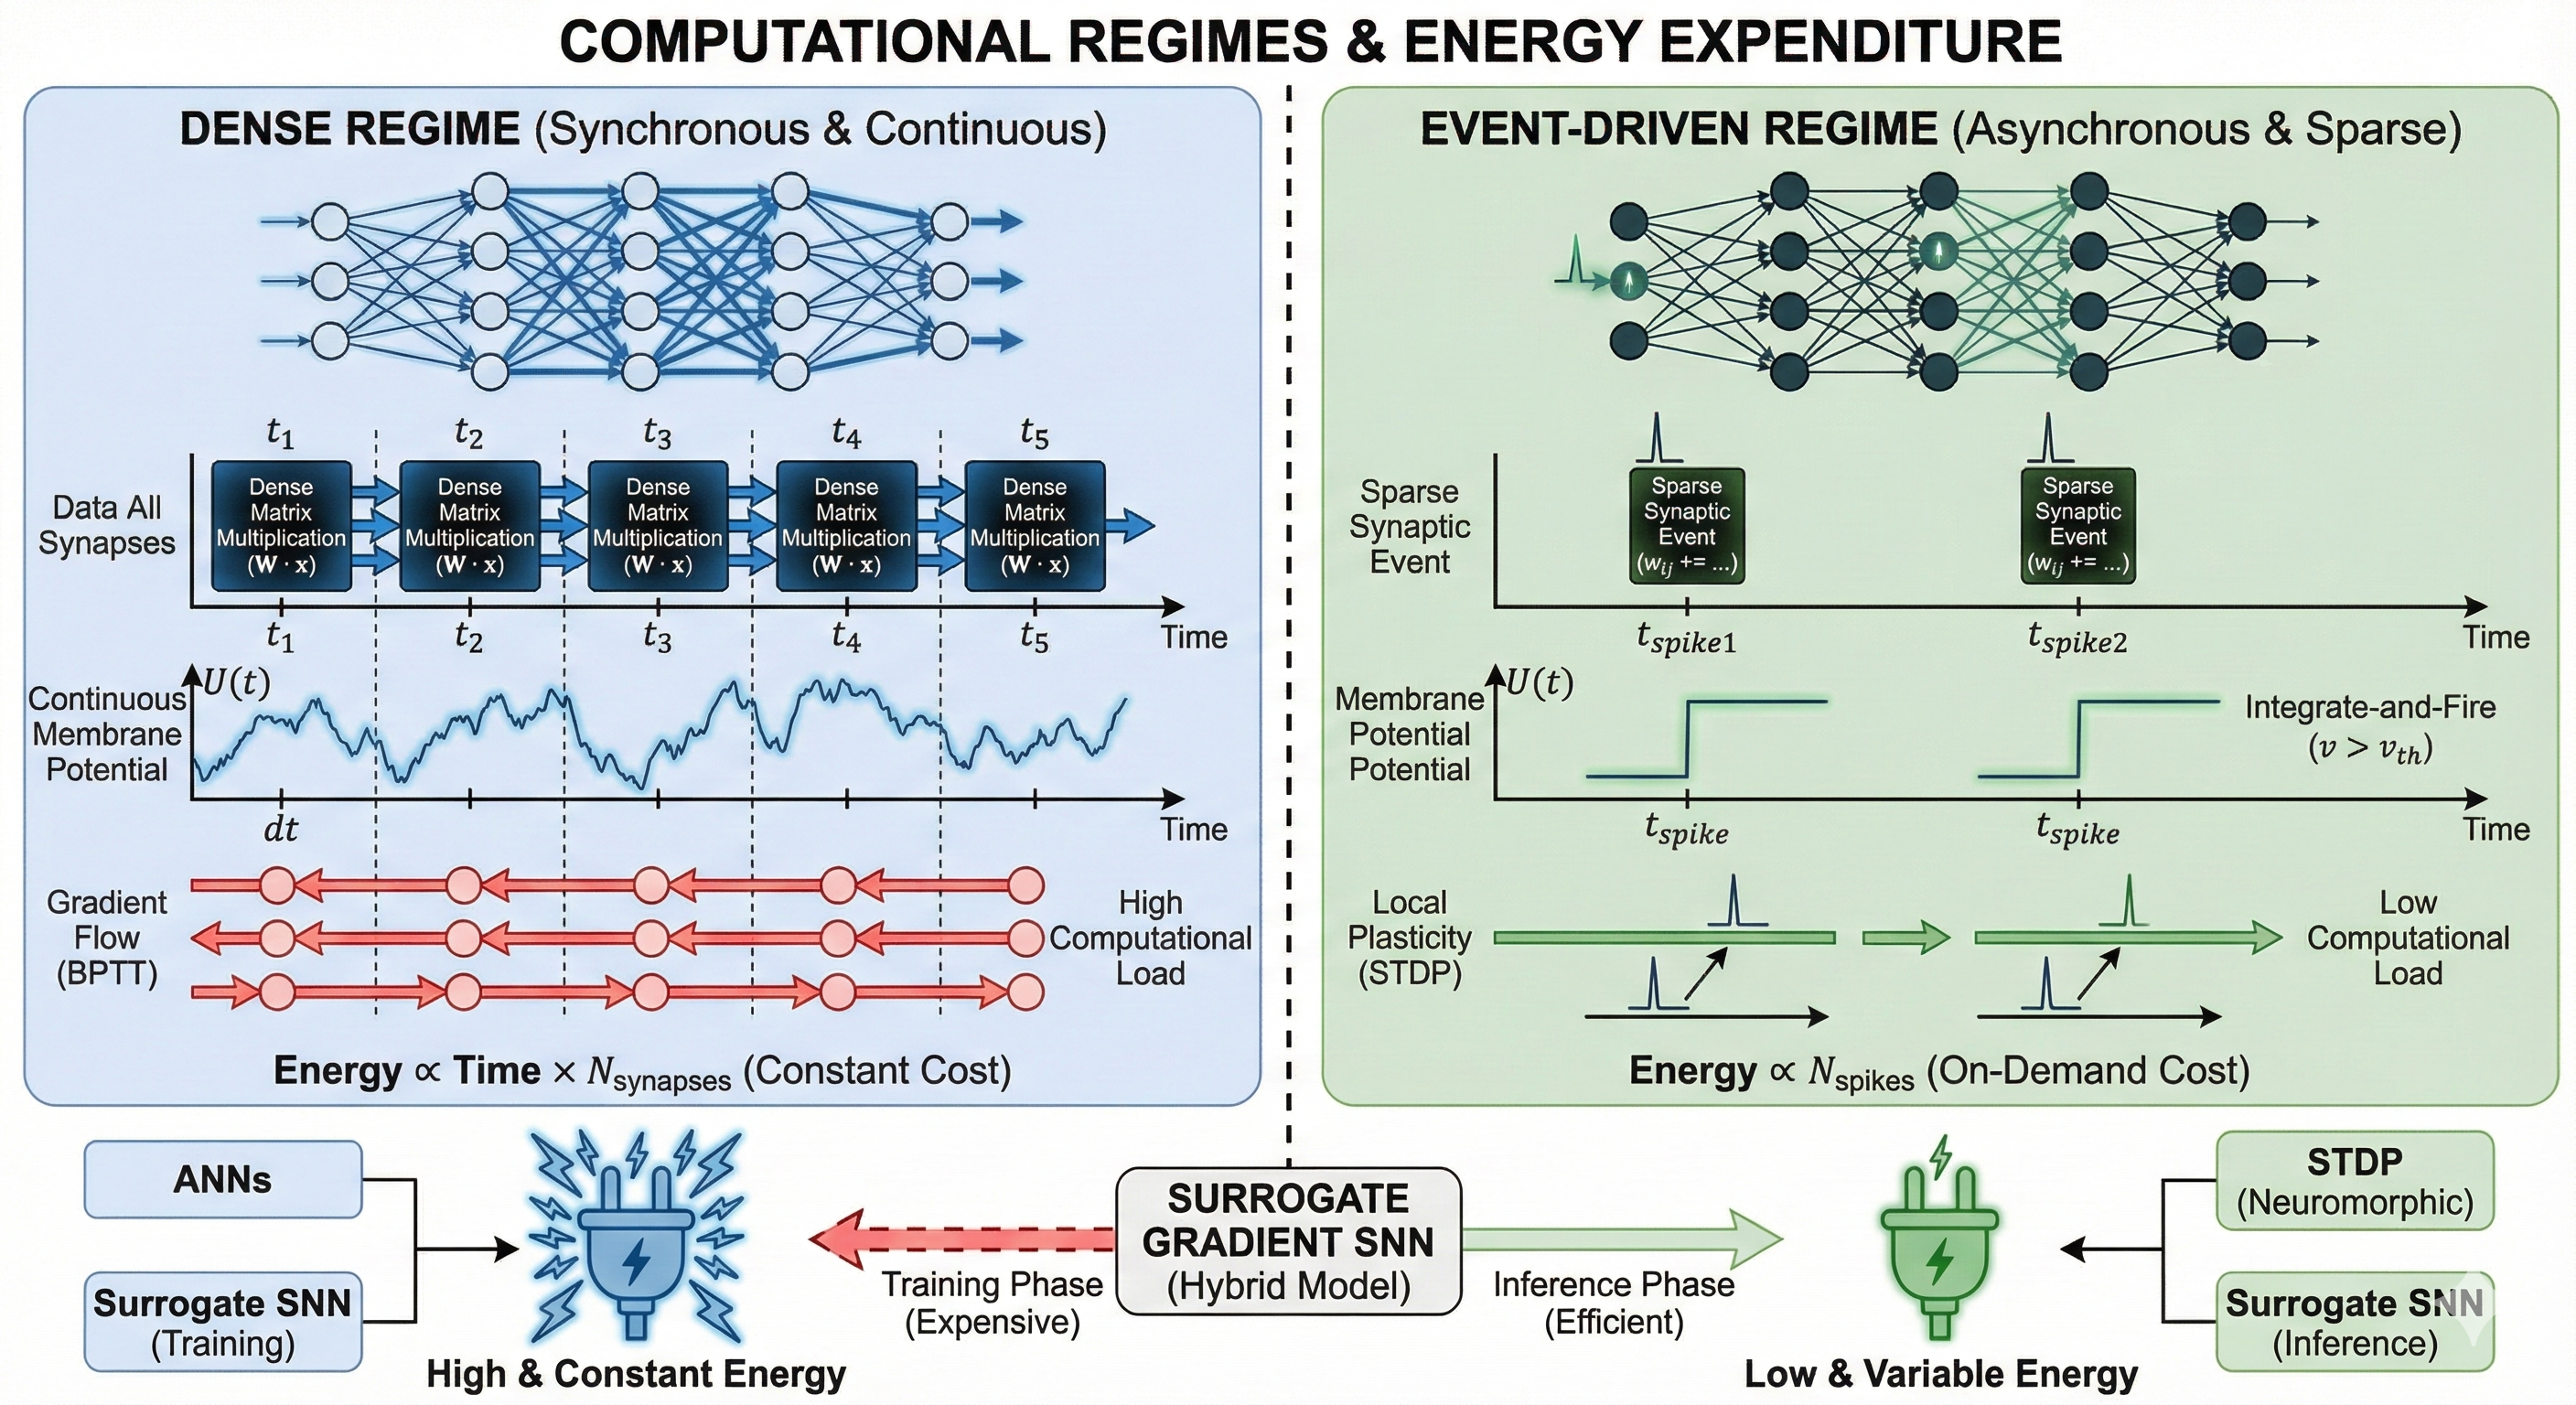
---

## 2. Theoretical Analysis of the Models

### A. STDP: The Pure Event-Driven Model
Spike-Timing-Dependent Plasticity (STDP) is biologically plausible and inherently local. In your Brian2 implementation, learning is defined by triggers such as `on_pre` and `on_post`.

* **Intuition:** In STDP, a synapse is a dormant memory unit. It does not "calculate" anything until a spike travels down the axon. When a pre-synaptic spike arrives, the synapse "wakes up," updates its weight based on the timing of the post-synaptic neuron's last spike, and goes back to sleep.
* **Energy Profile:** This is the most efficient theoretical model because the "idle cost" of a synapse is effectively removed. The energy is purely a function of information flow. If the network is silent, the energy cost is zero.

### B. Surrogate Gradient SNNs: The Hybrid Cost Model
Surrogate Gradient learning represents a bridge between the differentiable world of Deep Learning and the discrete world of SNNs. However, this creates a distinct split in energy complexity between **Training** and **Inference**.

#### Phase 1: Training (The "Time-Unrolling" Tax)
During training, we must calculate gradients to update weights. Because spikes are non-differentiable (step functions), we smooth them with a surrogate function.

* **The "Dense" Trap:** To perform Backpropagation Through Time (BPTT), the network essentially "unrolls" time into a spatial dimension. The algorithm must track the membrane potential $U(t)$ of every neuron at every single time step to compute the chain rule.
* **Intuition:** Even if a neuron creates zero spikes, the training algorithm must still simulate its membrane potential dynamics for the entire duration of the stimulus to know *how close* it was to spiking (for the gradient calculation). Thus, training a sparse SNN incurs a **Dense** energy cost.

#### Phase 2: Inference (The Sparse Dividend)
Once the network is trained and the weights are frozen, the requirement for gradient tracking vanishes.

* **The Hardware Caveat:** If you run the trained SNN on a standard GPU (as in the notebook), it remains in the **Dense Regime** because the GPU vectorizes the operation across time steps for throughput.
* **The Neuromorphic Promise:** If you export the weights to event-driven hardware, the model transitions to the **Event-Driven Regime**. The membrane potential is only updated when an input spike arrives.
* **Result:** You pay a high energy "tax" during training (Dense) to achieve a low energy "dividend" during deployment (Event-Driven).

---

## 3. Summary of Energy Regimes

| Model Type | Operation | Computational Regime | Dominant Energy Factor |
| :--- | :--- | :--- | :--- |
| **STDP** | Learning & Inference | **Event-Driven** | Spike Count ($N_{spikes}$) |
| **Surrogate SNN** | Training (BPTT) | **Dense** | Network Size $\times$ Time ($N_{syn} \times T$) |
| **Surrogate SNN** | Inference (Neuromorphic) | **Event-Driven** | Spike Count ($N_{spikes}$) |
| **Standard ANN** | Training & Inference | **Dense** | Network Size ($N_{syn}$) |

## References
1.  **Bi, G. Q., & Poo, M. M. (1998).** Synaptic modification in neuronal culture induced by repetitive spiking activity. *Journal of neuroscience*. (Foundation of STDP)
2.  **Neftci, E. O., et al. (2019).** Surrogate Gradient Learning in Spiking Neural Networks. *IEEE Signal Processing Magazine*. (Theory of Surrogate Gradients)

## Block 3 — Inference activity metrics (spikes, sparsity) + synaptic-event estimates

We work with two kinds of events : Spikes and synaptic events.
Spikes refer to the activity of neurons, while synaptic events refer to the connections between neurons. While the energy cost typically scales with the number of spikes, it is more closely approximated by the number of synaptic events. Imagine a network where each neuron is only connected to one other neuron, whereas a different network where each neuron is connected to all other neurons. The latter will have a higher energy cost, even if the number of spike events are the same.

This block quantifies **how much neural activity** each model uses to make one decision, and converts that activity into two complementary compute/energy proxies:


- **Event-driven proxy (neuromorphic-style):** cost scales with spikes causing synaptic events  
- **Dense upper bound proxy (GPU/dense simulation-style):** cost scales with all synapses evaluated at every time step  

These metrics let us interpret **accuracy vs. efficiency** with clearly stated assumptions.


---

### A) Spike counts per inference (activity volume)

We do this in a Layer-wise fasion as defined below.

For one inference with $T$ time steps, let:

- $x_t \in \{0,1\}^{N_{\text{in}}}$: input spikes at time $t$  
- $h_t \in \{0,1\}^{N_h}$: hidden spikes at time $t$  
- $y_t \in \{0,1\}^{N_{\text{out}}}$: output spikes at time $t$  

Layerwise spike totals for a single inference:

$$
S_{\text{in}}=\sum_{t=1}^{T}\sum_{i=1}^{N_{\text{in}}}x_{t,i}, \quad
S_h=\sum_{t=1}^{T}\sum_{j=1}^{N_h}h_{t,j}, \quad
S_{\text{out}}=\sum_{t=1}^{T}\sum_{k=1}^{N_{\text{out}}}y_{t,k}.
$$

We report spikes per inference as the average of these totals across evaluated samples.

**Interpretation:** lower spike totals can indicate better event-driven efficiency, but only in conjunction with accuracy and fanout (synaptic events).

---

### B) Activation sparsity (how distributed activity is)

Spike totals do not reveal whether activity is concentrated in a small subset of neurons (sparse) or spread across many neurons (dense). We define **active fraction** as:

$$
a_n=\mathbb{1}\!\left[\sum_{t=1}^{T}s_{t,n}>0\right], \quad
f_{\text{active}}=\frac{1}{N}\sum_{n=1}^{N}a_n.
$$

- For the **surrogate SNN**, we compute $f_{\text{active}}$ per sample (fraction of neurons that fired at least once) and average across samples.  
- For the **STDP checkpoint**, `spike_counts_exc` / `spike_counts_inh` are aggregated across many samples. The resulting $f_{\text{active}}$ therefore reflects “active at least once across the dataset,” which typically **overestimates per-inference sparsity**. We label this clearly as **aggregated sparsity**.

**Interpretation:** smaller $f_{\text{active}}$ indicates more sparse participation. Sparsity can reduce event-driven cost when connectivity is dense.

---

### C) Estimated synaptic events per inference (event-driven compute proxy)

Neuromorphic energy often scales with **synaptic events**: a presynaptic spike arriving at a synapse. With dense feedforward connectivity, a simple first-order estimate is:

**Surrogate SNN ($784 \rightarrow 400 \rightarrow 10$):**

$$
E_{\text{syn}} \approx S_{\text{in}}\cdot N_h + S_h\cdot N_{\text{out}}.
$$

- Each input spike fans out to all $N_h$ hidden units  
- Each hidden spike fans out to all $N_{\text{out}}$ output units  

**STDP network (typical Exc/Inh motif):** for dense Input$\rightarrow$Exc, ~1:1 Exc$\rightarrow$Inh, and dense Inh$\rightarrow$Exc:

$$
E_{\text{syn}} \approx
S_{\text{in}}\cdot N_{\text{exc}}
+
S_{\text{exc}}\cdot F_{\text{exc}\rightarrow\text{inh}}
+
S_{\text{inh}}\cdot F_{\text{inh}\rightarrow\text{exc}}
+
S_{\text{exc}}\cdot N_{\text{out}},
$$

with common defaults $F_{\text{exc}\rightarrow\text{inh}}\approx 1$ and $F_{\text{inh}\rightarrow\text{exc}}\approx N_{\text{exc}}-1$.

**Important caveat:** if STDP input spikes $S_{\text{in}}$ are not logged (no input SpikeMonitor totals in the checkpoint), then the event-driven estimate is incomplete. In that case we do not claim an event-driven efficiency comparison until input spikes are instrumented.

**Interpretation:** event-driven synaptic events are the most relevant proxy for neuromorphic inference energy because they incorporate both spiking and fanout.

---

### D) Dense upper bound synaptic operations (dense compute proxy)

Dense simulation/hardware can behave like evaluating every synapse every step, regardless of sparsity:

$$
\text{DenseSynOps}=N_{\text{synapses}}\cdot T,\quad
N_{\text{synapses}}=N_{\text{in}}N_h + N_hN_{\text{out}}.
$$

This is a compute upper bound (not a neuromorphic estimate). It helps show the gap between dense compute and event-driven compute.

**Interpretation:** if event-driven $E_{\text{syn}}$ is far below DenseSynOps, the model is in a regime where event-driven hardware could plausibly provide large efficiency gains.

---

### How to read the output table

- **Accuracy vs activity:** assess whether higher accuracy is achieved with fewer spikes / syn events.  
- **Sparsity:** compare active fractions to see whether efficiency comes from concentrated activity or broad participation.  
- **Cost location:** input spikes in a dense input layer can dominate syn events via fanout.  
- **Window length matters:** longer $T$ inflates spikes and dense ops; strong claims should normalize or match windows.  
- **Missing STDP input spikes:** if absent, interpret STDP event-driven estimates as “pending instrumentation.”  


In [11]:
# =============================================================================
# Block 3: Inference Activity Metrics (Spikes, Sparsity) + Synaptic-Event Estimates
# =============================================================================
# Assumes already loaded/defined from your prior blocks:
#   - surrogate_stats : NetworkStats
#   - stdp_stats      : NetworkStats
#   - snn_best        : surrogate model (SimpleSpikingNetwork) with weights loaded
#   - STDP_CHECKPOINT : path to stdp_checkpoint_XXXXsamples.pkl
#   - device          : torch device (cuda/cpu) from surrogate load block
#
# Updated for NEW STDP checkpoints:
#   - If present, uses:
#       * total_input_spikes / spike_counts_input
#       * training_samples (stored in checkpoint)
#       * connectivity fanouts/synapse counts (stored in checkpoint)
#       * protocol metadata (stim/rest/boost; reported in logs)
#   - Backward compatible with older checkpoints lacking these fields.
#
# This block:
#   1) Measures surrogate inference activity on a SMALL test subset (default: 256)
#      to compute *measured* spikes and per-inference sparsity.
#   2) Loads STDP checkpoint to compute dataset-aggregated spike averages and
#      (when available) input spikes / inference for event-driven syn-event estimates.
#   3) Estimates synaptic events per inference:
#        - event-driven proxy (spikes × fanout; requires layerwise spikes)
#        - dense upper bound proxy (N_syn * T)
#   4) Prints detailed console logging + shows a summary table.
# =============================================================================

import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pickle

# ---------------------------
# Helper logging + utilities
# ---------------------------
def log(msg=""):
    print(msg, flush=True)

def log_kv(k, v, indent=2):
    pad = " " * indent
    log(f"{pad}- {k}: {v}")

def active_fraction_from_counts(counts):
    """Fraction of units with >=1 spike given counts array."""
    if counts is None:
        return np.nan
    arr = np.asarray(counts).reshape(-1)
    if arr.size == 0:
        return np.nan
    return float(np.mean(arr > 0))

def sum_counts(counts):
    if counts is None:
        return np.nan
    arr = np.asarray(counts).reshape(-1)
    return float(np.sum(arr))

def dense_syn_ops(stats):
    """Dense upper bound proxy: (N_in*N_h + N_h*N_out) * T"""
    return int(stats.n_synapses * stats.time_steps)

def surrogate_event_syn_events(n_hidden, n_output, in_spikes, hid_spikes):
    """Event-driven syn events for 784→400→10: In→H + H→Out."""
    if np.isnan(in_spikes) or np.isnan(hid_spikes):
        return np.nan
    return float(in_spikes * n_hidden + hid_spikes * n_output)

def stdp_event_syn_events(
    n_hidden, n_output, in_spikes, exc_spikes, inh_spikes,
    exc_to_inh_fanout=1, inh_to_exc_fanout=None
):
    """
    Event-driven syn events for typical Diehl&Cook STDP net:
      In→Exc dense: in_spikes * n_hidden
      Exc→Inh ~1:1: exc_spikes * exc_to_inh_fanout
      Inh→Exc dense (excluding self): inh_spikes * inh_to_exc_fanout (default n_hidden-1)
      Exc→Readout: exc_spikes * n_output (if readout driven by exc spikes)
    """
    if inh_to_exc_fanout is None:
        inh_to_exc_fanout = max(n_hidden - 1, 0)
    if np.isnan(in_spikes) or np.isnan(exc_spikes) or np.isnan(inh_spikes):
        return np.nan
    return float(
        in_spikes * n_hidden +
        exc_spikes * exc_to_inh_fanout +
        inh_spikes * inh_to_exc_fanout +
        exc_spikes * n_output
    )

# =============================================================================
# Part A: Measure surrogate inference activity on a small test subset
# =============================================================================
log("=" * 92)
log("BLOCK 3: Inference Activity Metrics + Synaptic-Event Estimates")
log("=" * 92)

# ---- Parameters for quick measurement (adjust if you want)
N_EVAL = 256          # number of test samples to measure activity on
TIME_STEPS = surrogate_stats.time_steps  # should be 50
BATCH_SIZE = 64

log("SURROGATE: setting up MNIST test loader for activity measurement")
log_kv("N_EVAL samples", N_EVAL, indent=2)
log_kv("TIME_STEPS", TIME_STEPS, indent=2)
log_kv("BATCH_SIZE", BATCH_SIZE, indent=2)

# MNIST test loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # 784 vector
])
test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# ---- Poisson encoding (best-effort; adjust later if your training used a different encoder)

def poisson_encode(images_flat, time_steps, device, max_rate=80):
    """
    Convert images to Poisson spike trains matching training encoding.

    Training used: P(spike) = (intensity * max_rate) / 1000 per ms
    With TIME_WINDOW=50 and MAX_RATE=80 Hz

    Args:
        images_flat: (B, 784) in [0,1]
        time_steps: Number of timesteps (50)
        device: torch device
        max_rate: Maximum firing rate in Hz (default 80, matching training)

    Returns:
        spike_sequence: (B, T, 784) binary spike tensor
    """
    B, N = images_flat.shape

    # Convert pixel intensity to spike probability per timestep
    # P(spike) = (intensity * max_rate) / 1000 per ms
    spike_probs = images_flat * max_rate / 1000.0  # (B, 784)

    # Expand to all timesteps: (B, T, 784)
    spike_probs = spike_probs.unsqueeze(1).expand(B, time_steps, N)

    # Generate spikes
    spikes = (torch.rand_like(spike_probs) < spike_probs).float().to(device)

    return spikes

# ---- Measure spikes and sparsity
snn_best.eval()
total_seen = 0

tot_in_spikes = 0.0
tot_hid_spikes = 0.0
tot_out_spikes = 0.0

# For sparsity: fraction of neurons firing >=1 spike per inference (averaged across samples)
active_hidden_sum = 0.0
active_output_sum = 0.0

@torch.no_grad()
def forward_and_measure(spike_seq, model):
    """
    spike_seq: (B,T,784) binary
    Returns:
      out_counts (B,10) spike counts accumulated
      in_spikes_total (float) total input spikes over B samples
      hid_spikes_total (float) total hidden spikes over B samples
      out_spikes_total (float) total output spikes over B samples
      active_hidden_frac_per_sample (np.array shape (B,))
      active_output_frac_per_sample (np.array shape (B,))
    """
    B, T, _ = spike_seq.shape
    model.layer1.reset_state()
    model.layer2.reset_state()

    hid_any = torch.zeros(B, model.layer1.synapses.out_features, device=spike_seq.device, dtype=torch.bool)
    out_any = torch.zeros(B, model.layer2.synapses.out_features, device=spike_seq.device, dtype=torch.bool)

    out_counts = torch.zeros(B, model.layer2.synapses.out_features, device=spike_seq.device)

    in_spikes_total = 0.0
    hid_spikes_total = 0.0
    out_spikes_total = 0.0

    for t in range(T):
        x_t = spike_seq[:, t, :]
        h_t = model.layer1(x_t)
        y_t = model.layer2(h_t)

        in_spikes_total += float(x_t.sum().item())
        hid_spikes_total += float(h_t.sum().item())
        out_spikes_total += float(y_t.sum().item())

        hid_any |= (h_t > 0)
        out_any |= (y_t > 0)

        out_counts += y_t

    active_hidden = (hid_any.float().mean(dim=1)).detach().cpu().numpy()
    active_output = (out_any.float().mean(dim=1)).detach().cpu().numpy()

    return out_counts, in_spikes_total, hid_spikes_total, out_spikes_total, active_hidden, active_output

# ---- Get MAX_RATE from checkpoint (ONCE, before loop)
MAX_RATE = surrogate_ckpt.get('encoding', {}).get('max_rate_hz', 80)
print(f"Using MAX_RATE = {MAX_RATE} Hz (from checkpoint or default)")

log("-" * 92)
log("SURROGATE: running measurement pass...")
for batch_idx, (x, y) in enumerate(test_loader):
    if total_seen >= N_EVAL:
        break

    x = x.to(device)
    y = y.to(device)

    if total_seen + x.shape[0] > N_EVAL:
        x = x[:(N_EVAL - total_seen)]
        y = y[:(N_EVAL - total_seen)]

    spike_seq = poisson_encode(x, TIME_STEPS, device=device,max_rate=MAX_RATE)
    out_counts, in_s, hid_s, out_s, act_h, act_o = forward_and_measure(spike_seq, snn_best)

    B = x.shape[0]
    total_seen += B
    tot_in_spikes += in_s
    tot_hid_spikes += hid_s
    tot_out_spikes += out_s
    active_hidden_sum += float(act_h.sum())
    active_output_sum += float(act_o.sum())

log("SURROGATE: measurement complete.")
log_kv("Samples measured", total_seen, indent=2)

sur_in_spikes_per_inf = tot_in_spikes / max(total_seen, 1)
sur_hid_spikes_per_inf = tot_hid_spikes / max(total_seen, 1)
sur_out_spikes_per_inf = tot_out_spikes / max(total_seen, 1)
sur_active_hidden = active_hidden_sum / max(total_seen, 1)
sur_active_output = active_output_sum / max(total_seen, 1)

log("-" * 92)
log("SURROGATE: measured inference activity (averages over measured samples)")
log_kv("Input spikes / inference", f"{sur_in_spikes_per_inf:.2f}", indent=2)
log_kv("Hidden spikes / inference", f"{sur_hid_spikes_per_inf:.2f}", indent=2)
log_kv("Output spikes / inference", f"{sur_out_spikes_per_inf:.2f}", indent=2)
log_kv("Hidden active fraction (>=1 spike)", f"{sur_active_hidden:.4f}", indent=2)
log_kv("Output active fraction (>=1 spike)", f"{sur_active_output:.4f}", indent=2)

# =============================================================================
# Part B: STDP activity from checkpoint (dataset-aggregated)
# =============================================================================
log("=" * 92)
log("STDP: loading checkpoint for spike-count arrays and totals (dataset-aggregated)")
log("=" * 92)
log_kv("Checkpoint file", STDP_CHECKPOINT, indent=2)

with open(STDP_CHECKPOINT, "rb") as f:
    stdp_ckpt = pickle.load(f)

# --- Schema version (if present)
schema_version = stdp_ckpt.get("schema_version", "legacy_or_unknown")
log_kv("Checkpoint schema_version", schema_version, indent=2)

# --- Protocol metadata (optional)
protocol = stdp_ckpt.get("protocol", {})
if isinstance(protocol, dict) and len(protocol) > 0:
    log("  Protocol metadata (from checkpoint):")
    for kk in ["stim_ms", "rest_ms", "min_spikes", "max_attempts", "boost_hz", "encoder_max_rate_hz"]:
        if kk in protocol:
            log_kv(kk, protocol[kk], indent=4)

# --- Connectivity metadata (optional)
conn = stdp_ckpt.get("connectivity", {})
if isinstance(conn, dict) and len(conn) > 0:
    log("  Connectivity metadata (from checkpoint):")
    for kk in ["n_syn_input_exc", "n_syn_exc_inh", "n_syn_inh_exc",
               "fanout_input_to_exc", "fanout_exc_to_inh", "fanout_inh_to_exc"]:
        if kk in conn:
            log_kv(kk, conn[kk], indent=4)

stdp_n_exc = int(stdp_ckpt.get("n_exc", stdp_stats.n_hidden))
stdp_n_inh = int(stdp_ckpt.get("n_inh", stdp_ckpt.get("n_exc", stdp_stats.n_hidden)))

# --- Spike counts arrays
spike_counts_in = stdp_ckpt.get("spike_counts_input", None)  # NEW (may be missing)
spike_counts_exc = stdp_ckpt.get("spike_counts_exc", None)
spike_counts_inh = stdp_ckpt.get("spike_counts_inh", None)

# --- Totals
total_input_spikes = stdp_ckpt.get("total_input_spikes", None)  # NEW (may be missing)
total_exc_spikes = float(stdp_ckpt.get("total_exc_spikes", sum_counts(spike_counts_exc)))
total_inh_spikes = float(stdp_ckpt.get("total_inh_spikes", sum_counts(spike_counts_inh)))

# --- How many samples do these totals correspond to?
# Prefer explicit checkpoint field; fall back to stdp_stats.training_samples; then 0.
stdp_train_samples = stdp_ckpt.get("training_samples", None)
if stdp_train_samples is None or int(stdp_train_samples) <= 0:
    stdp_train_samples = int(getattr(stdp_stats, "training_samples", 0))
stdp_train_samples = int(stdp_train_samples)

# --- Derived per-inference averages (dataset-aggregated)
stdp_exc_spikes_per_inf = total_exc_spikes / max(stdp_train_samples, 1)
stdp_inh_spikes_per_inf = total_inh_spikes / max(stdp_train_samples, 1)

# NEW: input spikes / inference if total_input_spikes is present
if total_input_spikes is None:
    stdp_input_spikes_per_inf = np.nan
else:
    try:
        stdp_input_spikes_per_inf = float(total_input_spikes) / max(stdp_train_samples, 1)
    except Exception:
        stdp_input_spikes_per_inf = np.nan

# --- Sparsity (note: aggregated across scope, not per-inference)
stdp_active_in = active_fraction_from_counts(spike_counts_in)
stdp_active_exc = active_fraction_from_counts(spike_counts_exc)
stdp_active_inh = active_fraction_from_counts(spike_counts_inh)

log("-" * 92)
log("STDP: derived activity from checkpoint (AVERAGES; dataset-aggregated totals)")
log_kv("n_exc", stdp_n_exc, indent=2)
log_kv("n_inh", stdp_n_inh, indent=2)
log_kv("training_samples (checkpoint preferred)", stdp_train_samples, indent=2)
if not np.isnan(stdp_input_spikes_per_inf):
    log_kv("total_input_spikes (ckpt)", f"{float(total_input_spikes):.0f}", indent=2)
    log_kv("input spikes / inference (avg)", f"{stdp_input_spikes_per_inf:.2f}", indent=2)
else:
    log_kv("total_input_spikes (ckpt)", "MISSING", indent=2)
    log_kv("input spikes / inference (avg)", "NaN", indent=2)

log_kv("total_exc_spikes (ckpt)", f"{total_exc_spikes:.0f}", indent=2)
log_kv("total_inh_spikes (ckpt)", f"{total_inh_spikes:.0f}", indent=2)
log_kv("exc spikes / inference (avg)", f"{stdp_exc_spikes_per_inf:.2f}", indent=2)
log_kv("inh spikes / inference (avg)", f"{stdp_inh_spikes_per_inf:.2f}", indent=2)
log_kv("input active fraction (>=1 spike; aggregated)", f"{stdp_active_in:.4f}", indent=2)
log_kv("exc active fraction (>=1 spike; aggregated)", f"{stdp_active_exc:.4f}", indent=2)
log_kv("inh active fraction (>=1 spike; aggregated)", f"{stdp_active_inh:.4f}", indent=2)

# =============================================================================
# Part C: Synaptic-event estimates
# =============================================================================
log("=" * 92)
log("Synaptic-event estimates per inference")
log("=" * 92)

# Dense upper bounds (hardware-agnostic proxy for dense simulation cost)
sur_dense_ops = dense_syn_ops(surrogate_stats)
stdp_dense_ops = dense_syn_ops(stdp_stats)

# Event-driven proxies
sur_syn_events_event = surrogate_event_syn_events(
    n_hidden=surrogate_stats.n_hidden,
    n_output=surrogate_stats.n_output,
    in_spikes=sur_in_spikes_per_inf,
    hid_spikes=sur_hid_spikes_per_inf
)

# Prefer fanouts from checkpoint connectivity if present
exc_to_inh_fanout = 1
inh_to_exc_fanout = max(stdp_stats.n_hidden - 1, 0)

if isinstance(conn, dict) and len(conn) > 0:
    exc_to_inh_fanout = int(conn.get("fanout_exc_to_inh", exc_to_inh_fanout))
    inh_to_exc_fanout = int(conn.get("fanout_inh_to_exc", inh_to_exc_fanout))

stdp_syn_events_event = stdp_event_syn_events(
    n_hidden=stdp_stats.n_hidden,
    n_output=stdp_stats.n_output,
    in_spikes=stdp_input_spikes_per_inf,
    exc_spikes=stdp_exc_spikes_per_inf,
    inh_spikes=stdp_inh_spikes_per_inf,
    exc_to_inh_fanout=exc_to_inh_fanout,
    inh_to_exc_fanout=inh_to_exc_fanout
)

log("-" * 92)
log("SURROGATE syn-event estimates:")
log_kv("Dense upper bound syn ops = N_syn * T", f"{sur_dense_ops:,}", indent=2)
log_kv("Event-driven syn events (In→H + H→Out)", f"{sur_syn_events_event:,.2f}", indent=2)

log("-" * 92)
log("STDP syn-event estimates:")
log_kv("Dense upper bound syn ops = N_syn * T", f"{stdp_dense_ops:,}", indent=2)
if np.isnan(stdp_input_spikes_per_inf):
    log_kv("Event-driven syn events (requires INPUT spikes)", "NaN (missing input spikes)", indent=2)
else:
    log_kv("Event-driven syn events (In→Exc + Exc→Inh + Inh→Exc + Exc→Out)",
           f"{stdp_syn_events_event:,.2f}", indent=2)

# =============================================================================
# Part D: Summary table
# =============================================================================
log("=" * 92)
log("SUMMARY TABLE (this block’s outputs)")
log("=" * 92)

rows = [
    dict(
        Model="Surrogate SNN (measured)",
        WindowSteps=int(surrogate_stats.time_steps),
        Accuracy_pct=float(getattr(surrogate_stats, "inference_accuracy", np.nan)),
        InputSpikes_perInf=float(sur_in_spikes_per_inf),
        HiddenSpikes_perInf=float(sur_hid_spikes_per_inf),
        OutputSpikes_perInf=float(sur_out_spikes_per_inf),
        ActiveFrac_hidden=float(sur_active_hidden),
        ActiveFrac_output=float(sur_active_output),
        SynEvents_eventDriven=float(sur_syn_events_event),
        SynOps_denseUpper=int(sur_dense_ops),
        Notes="Spikes/sparsity measured on subset of MNIST test with Poisson encoder."
    ),
    dict(
        Model="STDP SNN (checkpoint avg)",
        WindowSteps=int(stdp_stats.time_steps),
        Accuracy_pct=float(getattr(stdp_stats, "inference_accuracy", np.nan)),
        InputSpikes_perInf=float(stdp_input_spikes_per_inf) if not np.isnan(stdp_input_spikes_per_inf) else np.nan,
        HiddenSpikes_perInf=float(stdp_exc_spikes_per_inf),
        OutputSpikes_perInf=np.nan,
        ActiveFrac_hidden=float(stdp_active_exc),
        ActiveFrac_output=np.nan,
        SynEvents_eventDriven=float(stdp_syn_events_event) if not np.isnan(stdp_syn_events_event) else np.nan,
        SynOps_denseUpper=int(stdp_dense_ops),
        Notes=("Averages from checkpoint totals over training_samples. "
               "Sparsity is aggregated across scope (not per-inference).")
    ),
]

df_block3 = pd.DataFrame(rows)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 180)
display(df_block3)

# =============================================================================
# Part E: Instrumentation warnings (what to add next / caveats)
# =============================================================================
log("-" * 92)
log("INSTRUMENTATION STATUS / WARNINGS")
log("-" * 92)

warnings = []

# STDP input spikes availability
if np.isnan(stdp_input_spikes_per_inf):
    warnings.append(
        "STDP: input spikes per inference are missing → cannot compute event-driven Input→Exc syn events. "
        "Fix: add SpikeMonitor on input group AND save total_input_spikes (or input_spikes_per_sample)."
    )

# Training samples validity
if stdp_train_samples <= 0:
    warnings.append("STDP: training_samples not found/invalid → per-inference averages may be wrong.")

# Scope interpretation caveat
warnings.append(
    "STDP: checkpoint spike totals typically reflect the TRAINING presentation protocol "
    "(350ms stim + 150ms rest + possible repeated attempts with rate boosting). "
    "These are not necessarily 'pure inference' metrics unless monitors were reset and a fixed eval pass was run."
)


if warnings:
    for w in warnings:
        log("⚠️  " + w)
else:
    log("✅ No critical missing fields detected for this block.")

log("-" * 92)
log("DONE: Block 3 complete.")


BLOCK 3: Inference Activity Metrics + Synaptic-Event Estimates
SURROGATE: setting up MNIST test loader for activity measurement
  - N_EVAL samples: 256
  - TIME_STEPS: 50
  - BATCH_SIZE: 64
Using MAX_RATE = 80 Hz (from checkpoint or default)
--------------------------------------------------------------------------------------------
SURROGATE: running measurement pass...
SURROGATE: measurement complete.
  - Samples measured: 256
--------------------------------------------------------------------------------------------
SURROGATE: measured inference activity (averages over measured samples)
  - Input spikes / inference: 374.37
  - Hidden spikes / inference: 411.20
  - Output spikes / inference: 142.06
  - Hidden active fraction (>=1 spike): 0.1548
  - Output active fraction (>=1 spike): 0.8875
STDP: loading checkpoint for spike-count arrays and totals (dataset-aggregated)
  - Checkpoint file: stdp_checkpoint.pkl
  - Checkpoint schema_version: complete_v1
  Connectivity metadata (from c

Model  WindowSteps  Accuracy_pct  InputSpikes_perInf  HiddenSpikes_perInf  OutputSpikes_perInf  ActiveFrac_hidden  ActiveFrac_output  \
0   Surrogate SNN (measured)           50         83.76          374.367188           411.199219             142.0625           0.154766             0.8875   
1  STDP SNN (checkpoint avg)          350         69.29         2346.765600            16.737400                  NaN           1.000000                NaN   

   SynEvents_eventDriven  SynOps_denseUpper                                              Notes  
0          153858.867188           15880000  Spikes/sparsity measured on subset of MNIST te...  
1          945568.574000          111160000  Averages from checkpoint totals over training_...

--------------------------------------------------------------------------------------------
INSTRUMENTATION STATUS / WARNINGS
--------------------------------------------------------------------------------------------
⚠️  STDP: checkpoint spike totals typically reflect the TRAINING presentation protocol (350ms stim + 150ms rest + possible repeated attempts with rate boosting). These are not necessarily 'pure inference' metrics unless monitors were reset and a fixed eval pass was run.
--------------------------------------------------------------------------------------------
DONE: Block 3 complete.


## Block 4 — Energy-per-inference proxies, “fair” comparison views, and battery-scale intuition

**What Block 3 gave us:** Block 3 measured (or derived) *activity* for each model during inference:
- **Spikes per inference** at each layer (input / hidden / output where available)
- **Activation sparsity** (fraction of neurons that fired at least once)
- **Two compute proxies** per inference:
  1) **Event-driven synaptic events** (spike arrivals at synapses; requires spikes + fanout assumptions)
  2) **Dense upper bound synaptic ops** (all synapses evaluated every time step; $N_{\text{syn}}\cdot T$)

These quantities are *hardware-agnostic* descriptions of how much neural activity/compute the model produces to make one decision.

---

### Strategy
Here we convert Block 3 activity/compute numbers into **energy proxies** under explicit assumptions, and then provides **comparisons** that help interpret accuracy–efficiency tradeoffs.

The key idea is: *“energy” is not uniquely defined without a hardware model,* so we report **two complementary regimes**:

1) **Event-driven proxy (neuromorphic-style):**  
   Energy scales with **synaptic events**, i.e., when spikes actually trigger synaptic accumulations.
   $E_{\text{event}} \approx \epsilon_{\text{syn}} \cdot N_{\text{syn-events}}$
   where:
   - $N_{\text{syn-events}}$ comes from Block 3 (spikes $\times$ fanout)
   - $\epsilon_{\text{syn}}$ is an assumed energy per synaptic event (pJ/event) from published neuromorphic measurements

2) **Dense upper bound proxy (dense simulation / GPU-like):**  
   Energy scales with **all synaptic operations** evaluated every time step, regardless of whether neurons fired.
   $E_{\text{dense}} \approx \epsilon_{\text{MAC}} \cdot N_{\text{syn-ops}}$, with $N_{\text{syn-ops}} = N_{\text{synapses}} \cdot T$
   where:
   - $N_{\text{syn-ops}}$ is Block 3’s dense upper bound
   - $\epsilon_{\text{MAC}}$ is an assumed energy per multiply–accumulate (pJ/MAC)

**Interpretation:**  
- If $N_{\text{syn-events}} \ll N_{\text{syn-ops}}$, the model is in a regime where event-driven hardware could plausibly yield large efficiency gains.
- If activity is high and sparse benefits are small, dense compute may dominate.

---

### Why we normalize and what “fair comparison” means here
Raw energy per inference can be misleading when models have different accuracies. Block 4 therefore reports both:

- **Energy per inference** (how costly each decision is, as-run)
- **Energy per correct decision** (cost corrected for accuracy):  
  $E_{\text{per-correct}} = \frac{E_{\text{per-inf}}}{\text{accuracy}}$

This answers: *“How much energy do we spend to get one correct classification?”*

Block 4 also makes **window-length effects explicit**. Since one model may run with different effective durations (e.g., 50 steps vs 350 ms), we treat:
- “as-run” energy (faithful to the implemented protocol), and
- optionally time-normalized interpretations (if we later decide to compare at matched $T$).

---

### Why battery-scale estimates are included
Battery numbers are not a new metric—they are merely a **re-expression** of energy per inference. They are ueful because the turn abstract pJ/uJ numbers into a human-scale, deployment-scale quantities: how many decisions can you afford per unit energy.
$\text{Inferences on battery} = \frac{E_{\text{battery}}}{E_{\text{per-inf}}}$

They help:
- communicate magnitude (uJ $\rightarrow$ “how many inferences on a coin cell?”)
- sanity-check assumptions (avoids unrealistic energy claims)
- connect proxy efficiency to plausible edge deployment scenarios

These estimates are labeled as **order-of-magnitude** because they omit memory, I/O, sensor, and idle power, and assume ideal mapping.

---

### Critical instrumentation note (STDP input spikes)
Event-driven synaptic events require **input spikes per inference**, because dense input$\rightarrow$hidden fanout can dominate syn-event counts:
$N_{\text{syn-events}} \sim S_{\text{in}}\cdot N_h + S_h \cdot N_{\text{out}} \; (+\text{recurrent terms})$

If the STDP checkpoint does not store input spikes, Block 4 will:
- still compute the **dense upper bound**
- mark event-driven energy as **NaN / pending instrumentation**

This prevents over-claiming a neuromorphic efficiency result without the required logged data.

---

### Outputs of Block 4
Block 4 produces:
1) A table of energy proxies for each model under multiple assumption sets (pJ/event, pJ/MAC)
2) Energy per correct decision (accuracy-normalized)
3) Simple battery-scale inference counts
4) Report-ready plots that visualize:
   - event-driven vs dense upper bound energy
   - energy normalized by accuracy

This block is the bridge from **Block 3’s activity measurements** to **research-grade efficiency claims with explicit assumptions and caveats**.


BLOCK 4: Energy-per-Inference Estimates + Fair Comparison Tables
Loaded df_block3 from Block 3.
  - Rows: 2
  - Columns: ['Model', 'WindowSteps', 'Accuracy_pct', 'InputSpikes_perInf', 'HiddenSpikes_perInf', 'OutputSpikes_perInf', 'ActiveFrac_hidden', 'ActiveFrac_output', 'SynEvents_eventDriven', 'SynOps_denseUpper', 'Notes']
--------------------------------------------------------------------------------------------
Loading surrogate checkpoint metadata (for reproducibility + optional saved activity)
--------------------------------------------------------------------------------------------
  - Surrogate checkpoint: surrogate_snn_checkpoint.pth
  - schema_version: surrogate_complete_v1
Surrogate encoding metadata (from checkpoint):
  - type: poisson
  - time_window: 50
  - max_rate_hz: 80
--------------------------------------------------------------------------------------------
Loading STDP checkpoint to check for total_input_spikes (energy instrumentation)
-------------------------

name  E_syn_event_pJ  E_mac_pJ  E_syn_update_pJ                                              notes  \
0   EventDriven_Loihi23.6pJ__Dense_FP32MAC4.9pJ            23.6       4.9            120.0  Loihi syn spike op 23.6 pJ; FP32 MAC ~4.9 pJ; ...   
1  EventDriven_TrueNorth26pJ__Dense_IntMAC3.1pJ            26.0       3.1            120.0  TrueNorth-style 26 pJ/event; Int MAC ~3.1 pJ; ...   

                                                refs  
0  Davies 2018 (Loihi Table 2); Horowitz 2014 rou...  
1  TrueNorth summaries; Horowitz 2014 rough energ...

Reconciling df_block3 with newly available STDP input spikes (if present)
  - STDP rows found: [1]
  - STDP InputSpikes_perInf at row 1 already set: 2346.7656
  - STDP SynEvents_eventDriven at row 1 already non-NaN: 945568.574
Computing energy proxies for each model × assumption set
--------------------------------------------------------------------------------------------
Assumption set: EventDriven_Loihi23.6pJ__Dense_FP32MAC4.9pJ
  - E_syn_event_pJ: 23.6
  - E_mac_pJ: 4.9
  - E_syn_update_pJ (for training proxy): 120.0
--------------------------------------------------------------------------------------------
Assumption set: EventDriven_TrueNorth26pJ__Dense_IntMAC3.1pJ
  - E_syn_event_pJ: 26.0
  - E_mac_pJ: 3.1
  - E_syn_update_pJ (for training proxy): 120.0
BLOCK 4 OUTPUT TABLE (df_block4)


AssumptionSet                      Model  Accuracy_pct  WindowSteps  TotalSpikes_perInf  SynEvents_eventDriven  SynOps_denseUpper  E_syn_event_pJ  E_mac_pJ  Energy_uJ_eventDriven  \
0   EventDriven_Loihi23.6pJ__Dense_FP32MAC4.9pJ   Surrogate SNN (measured)         83.76           50          927.628906          153858.867188         15880000.0            23.6       4.9               3.631069   
1   EventDriven_Loihi23.6pJ__Dense_FP32MAC4.9pJ  STDP SNN (checkpoint avg)         69.29          350         2363.503000          945568.574000        111160000.0            23.6       4.9              22.315418   
2  EventDriven_TrueNorth26pJ__Dense_IntMAC3.1pJ   Surrogate SNN (measured)         83.76           50          927.628906          153858.867188         15880000.0            26.0       3.1               4.000331   
3  EventDriven_TrueNorth26pJ__Dense_IntMAC3.1pJ  STDP SNN (checkpoint avg)         69.29          350         2363.503000          945568.574000        111160000.0            26.0       3.1              24.584783   

   Energy_uJ_denseUpper  Energy_uJ_perCorrect_eventDriven  Energy_uJ_perCorrect_denseUpper  InfPerJ_eventDriven  InfPerJ_denseUpper  Inf_CoinCell_0.675Wh_eventDriven  Inf_CoinCell_0.675Wh_denseUpper  \
0                77.812                          4.335087                        92.898758        275400.970581        12851.488202                      6.692244e+08                     3.122912e+07   
1               544.684                         32.205828                       786.093231         44812.066011         1835.926886                      1.088933e+08                     4.461302e+06   
2                49.228                          4.775944                        58.772684        249979.342527        20313.642642                      6.074498e+08                     4.936215e+07   
3               344.596                         35.480997                       497.324289         40675.567610         2901.948949                      9.884163e+07                     7.051736e+06   

   Inf_SmallPack_5Wh_eventDriven  Inf_SmallPack_5Wh_denseUpper  Inf_PhoneClass_15Wh_eventDriven  Inf_PhoneClass_15Wh_denseUpper                                              Notes  \
0                   4.957217e+09                  2.313268e+08                     1.487165e+10                    6.939804e+08  Spikes/sparsity measured on subset of MNIST te...   
1                   8.066172e+08                  3.304668e+07                     2.419852e+09                    9.914005e+07  Averages from checkpoint totals over training_...   
2                   4.499628e+09                  3.656456e+08                     1.349888e+10                    1.096937e+09  Spikes/sparsity measured on subset of MNIST te...   
3                   7.321602e+08                  5.223508e+07                     2.196481e+09                    1.567052e+08  Averages from checkpoint totals over training_...   

                                     AssumptionNotes                                               Refs  
0  Loihi syn spike op 23.6 pJ; FP32 MAC ~4.9 pJ; ...  Davies 2018 (Loihi Table 2); Horowitz 2014 rou...  
1  Loihi syn spike op 23.6 pJ; FP32 MAC ~4.9 pJ; ...  Davies 2018 (Loihi Table 2); Horowitz 2014 rou...  
2  TrueNorth-style 26 pJ/event; Int MAC ~3.1 pJ; ...  TrueNorth summaries; Horowitz 2014 rough energ...  
3  TrueNorth-style 26 pJ/event; Int MAC ~3.1 pJ; ...  TrueNorth summaries; Horowitz 2014 rough energ...

AssumptionSet                      Model  Accuracy_pct  SynEvents_eventDriven  SynOps_denseUpper  Energy_uJ_eventDriven  Energy_uJ_denseUpper  Energy_uJ_perCorrect_eventDriven  \
0   EventDriven_Loihi23.6pJ__Dense_FP32MAC4.9pJ   Surrogate SNN (measured)         83.76          153858.867188         15880000.0               3.631069                77.812                          4.335087   
1   EventDriven_Loihi23.6pJ__Dense_FP32MAC4.9pJ  STDP SNN (checkpoint avg)         69.29          945568.574000        111160000.0              22.315418               544.684                         32.205828   
2  EventDriven_TrueNorth26pJ__Dense_IntMAC3.1pJ   Surrogate SNN (measured)         83.76          153858.867188         15880000.0               4.000331                49.228                          4.775944   
3  EventDriven_TrueNorth26pJ__Dense_IntMAC3.1pJ  STDP SNN (checkpoint avg)         69.29          945568.574000        111160000.0              24.584783               344.596                         35.480997   

   Energy_uJ_perCorrect_denseUpper  
0                        92.898758  
1                       786.093231  
2                        58.772684  
3                       497.324289

Generating plots (2 figures): Energy per inference + Energy per correct inference


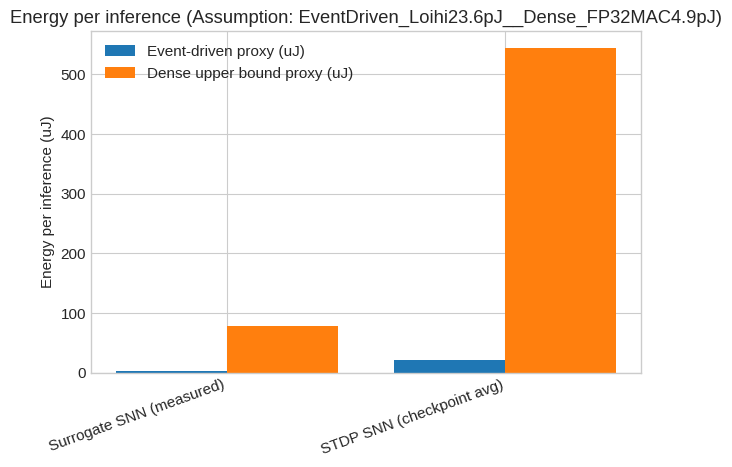

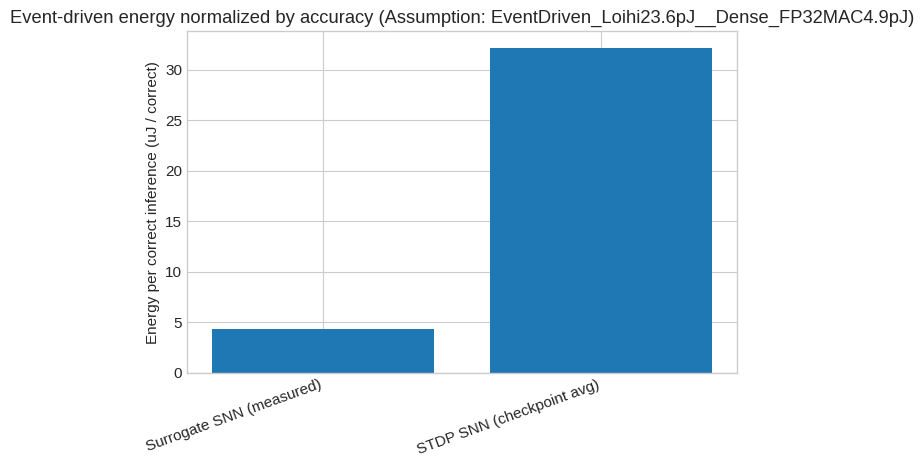

--------------------------------------------------------------------------------------------
INSTRUMENTATION STATUS / WARNINGS (Block 4)
--------------------------------------------------------------------------------------------
⚠️  STDP: Current spike totals are dataset-aggregated (typically from training). For strict inference-energy comparisons, save *evaluation* monitors separately (test-set totals).
--------------------------------------------------------------------------------------------
DONE: Block 4 complete. Next: we’ll write the report narrative + citations using df_block4 outputs.


In [12]:
# =============================================================================
# Block 4: Energy-per-Inference Estimates + Fair Comparison Tables + Battery-Life Proxies
# =============================================================================
# PURPOSE
#   Convert Block 3 activity outputs into research-grade energy/computation proxies:
#     (1) Event-driven (neuromorphic-style): energy scales with synaptic events (spike arrivals)
#     (2) Dense upper bound (dense sim/GPU-style): energy scales with syn ops each time step
#   Then:
#     - normalize for accuracy (energy per correct inference)
#     - provide simple battery-life style estimates
#     - produce clean tables + a couple plots for the report
#
# ASSUMES already defined from previous blocks:
#   - df_block3 (DataFrame) from Block 3
#   - surrogate_stats (NetworkStats)
#   - stdp_stats (NetworkStats)
#   - STDP_CHECKPOINT (str path)
#   - device (torch device) [optional]
#
# NOTES
#   - If STDP checkpoint now includes total_input_spikes, this block will use it to
#     compute a non-NaN event-driven estimate. If not present, STDP event-driven remains NaN.
#   - Surrogate energy uses Block 3 measured layerwise spikes and syn-event estimate.
# =============================================================================

import numpy as np
import pandas as pd
import pickle
import torch
import matplotlib.pyplot as plt

# ---------------------------
# Helper logging
# ---------------------------
def log(msg=""):
    print(msg, flush=True)

def log_kv(k, v, indent=2):
    pad = " " * indent
    log(f"{pad}- {k}: {v}")

def require_var(name):
    if name not in globals():
        raise RuntimeError(f"Missing required variable: `{name}`. Run prior blocks first.")
    return globals()[name]

# ---------------------------
# Units + safe ops
# ---------------------------
def pj_events_to_uJ(pj_per_event, n_events):
    """
    Convert pJ/event * events -> microjoules.
    1 pJ = 1e-12 J; 1 uJ = 1e-6 J => uJ = events * pJ * 1e-6
    """
    if n_events is None or np.isnan(n_events) or pj_per_event is None or np.isnan(pj_per_event):
        return np.nan
    return float(n_events) * float(pj_per_event) * 1e-6

def safe_div(a, b):
    if b is None or np.isnan(b) or b == 0:
        return np.nan
    return float(a) / float(b)

def pct_to_prob(acc_pct):
    if acc_pct is None or np.isnan(acc_pct):
        return np.nan
    return float(acc_pct) / 100.0

# =============================================================================
# Block 4 start
# =============================================================================
log("=" * 92)
log("BLOCK 4: Energy-per-Inference Estimates + Fair Comparison Tables")
log("=" * 92)

df_block3 = require_var("df_block3").copy()
log("Loaded df_block3 from Block 3.")
log_kv("Rows", df_block3.shape[0], indent=2)
log_kv("Columns", list(df_block3.columns), indent=2)

# =============================================================================
# Part A: Load latest checkpoints (for metadata + STDP input spikes if available)
# =============================================================================
SURROGATE_CKPT_PATH = "surrogate_snn_checkpoint.pth"
log("-" * 92)
log("Loading surrogate checkpoint metadata (for reproducibility + optional saved activity)")
log("-" * 92)

sur_ckpt = torch.load(SURROGATE_CKPT_PATH, map_location="cpu", weights_only=False)
sur_schema = sur_ckpt.get("schema_version", "legacy_or_unknown")
log_kv("Surrogate checkpoint", SURROGATE_CKPT_PATH, indent=2)
log_kv("schema_version", sur_schema, indent=2)

sur_encoding = sur_ckpt.get("encoding", {})
if isinstance(sur_encoding, dict) and len(sur_encoding) > 0:
    log("Surrogate encoding metadata (from checkpoint):")
    for k in ["type", "time_window", "max_rate_hz", "spike_prob_rule"]:
        if k in sur_encoding:
            log_kv(k, sur_encoding[k], indent=2)
else:
    log("Surrogate encoding metadata not present (legacy checkpoint).")

log("-" * 92)
log("Loading STDP checkpoint to check for total_input_spikes (energy instrumentation)")
log("-" * 92)

STDP_CHECKPOINT = require_var("STDP_CHECKPOINT")
log_kv("STDP checkpoint", STDP_CHECKPOINT, indent=2)

with open(STDP_CHECKPOINT, "rb") as f:
    stdp_ckpt = pickle.load(f)

stdp_schema = stdp_ckpt.get("schema_version", "legacy_or_unknown")
log_kv("schema_version", stdp_schema, indent=2)

stdp_train_samples = int(stdp_ckpt.get("training_samples", getattr(require_var("stdp_stats"), "training_samples", 0)))
log_kv("training_samples (ckpt or stdp_stats)", stdp_train_samples, indent=2)

stdp_total_input_spikes = stdp_ckpt.get("total_input_spikes", None)
if stdp_total_input_spikes is None:
    log("STDP: total_input_spikes NOT found in checkpoint. Event-driven Input→Exc will remain NaN.")
    stdp_input_spikes_per_inf = np.nan
else:
    stdp_total_input_spikes = float(stdp_total_input_spikes)
    stdp_input_spikes_per_inf = stdp_total_input_spikes / max(stdp_train_samples, 1)
    log("STDP: total_input_spikes found!")
    log_kv("total_input_spikes (ckpt)", f"{stdp_total_input_spikes:.0f}", indent=2)
    log_kv("input spikes / sample (avg)", f"{stdp_input_spikes_per_inf:.2f}", indent=2)

# =============================================================================
# Part B: Define energy assumption sets (edit these as needed)
# =============================================================================
log("=" * 92)
log("Energy assumption sets (pJ units). Edit these values if you prefer different sources.")
log("=" * 92)

# Event-driven synaptic spike op energy (pJ/event): Loihi reports ~23.6 pJ; TrueNorth often cited ~26 pJ.
# Dense MAC energy (pJ/MAC): use Horowitz 45nm "rough numbers" as order-of-magnitude proxy.
ASSUMPTION_SETS = [
    {
        "name": "EventDriven_Loihi23.6pJ__Dense_FP32MAC4.9pJ",
        "E_syn_event_pJ": 23.6,     # pJ per synaptic spike op
        "E_mac_pJ": 4.9,            # ~FP32 mult (4 pJ) + FP32 add (0.9 pJ)
        "E_syn_update_pJ": 120.0,   # pJ per pairwise STDP update (Loihi Table 2) - used for STDP training proxy
        "notes": "Loihi syn spike op 23.6 pJ; FP32 MAC ~4.9 pJ; syn update 120 pJ (proxy).",
        "refs": "Davies 2018 (Loihi Table 2); Horowitz 2014 rough energy numbers"
    },
    {
        "name": "EventDriven_TrueNorth26pJ__Dense_IntMAC3.1pJ",
        "E_syn_event_pJ": 26.0,     # pJ per synaptic event (common TrueNorth figure)
        "E_mac_pJ": 3.1,            # ~Int32 mult (3 pJ) + add (0.1 pJ)
        "E_syn_update_pJ": 120.0,   # keep same STDP update proxy unless you want a different one
        "notes": "TrueNorth-style 26 pJ/event; Int MAC ~3.1 pJ; syn update proxy 120 pJ.",
        "refs": "TrueNorth summaries; Horowitz 2014 rough energy numbers; Davies 2018 for update proxy"
    },
]

df_assumptions = pd.DataFrame(ASSUMPTION_SETS)
display(df_assumptions)

# =============================================================================
# Part C: Ensure df_block3 contains best available STDP input spikes (if now present)
# =============================================================================
log("=" * 92)
log("Reconciling df_block3 with newly available STDP input spikes (if present)")
log("=" * 92)

df4 = df_block3.copy()

# Identify STDP row(s)
is_stdp = df4["Model"].astype(str).str.contains("STDP", case=False, na=False)
if is_stdp.any():
    idxs = list(df4.index[is_stdp])
    log_kv("STDP rows found", idxs, indent=2)
    for idx in idxs:
        prev = df4.loc[idx, "InputSpikes_perInf"]
        if (prev is None) or (np.isnan(prev) if isinstance(prev, (float, np.floating)) else False):
            if not np.isnan(stdp_input_spikes_per_inf):
                df4.loc[idx, "InputSpikes_perInf"] = stdp_input_spikes_per_inf
                log(f"  - Updated STDP InputSpikes_perInf at row {idx}: NaN -> {stdp_input_spikes_per_inf:.2f}")
            else:
                log(f"  - STDP InputSpikes_perInf at row {idx} remains NaN (not saved).")
        else:
            log(f"  - STDP InputSpikes_perInf at row {idx} already set: {prev}")

else:
    log("No STDP rows detected in df_block3 Model column. (Unexpected)")

# Recompute STDP event-driven syn events if possible (only if currently NaN and now have input spikes)
def stdp_event_syn_events(n_hidden, n_output, in_spikes, exc_spikes, inh_spikes,
                          exc_to_inh_fanout=1, inh_to_exc_fanout=None):
    if inh_to_exc_fanout is None:
        inh_to_exc_fanout = max(n_hidden - 1, 0)
    if np.isnan(in_spikes) or np.isnan(exc_spikes) or np.isnan(inh_spikes):
        return np.nan
    return float(
        in_spikes * n_hidden +
        exc_spikes * exc_to_inh_fanout +
        inh_spikes * inh_to_exc_fanout +
        exc_spikes * n_output
    )

if is_stdp.any():
    for idx in df4.index[is_stdp]:
        cur_syn_events = df4.loc[idx, "SynEvents_eventDriven"]
        in_sp = df4.loc[idx, "InputSpikes_perInf"]
        exc_sp = df4.loc[idx, "HiddenSpikes_perInf"]
        # We stored inhibitory spikes per inference in Block 3 logging but not in df_block3;
        # if not present, we approximate inh spikes = exc spikes (Diehl&Cook symmetry in your checkpoint totals).
        # If you later save inh spikes explicitly, replace this approximation.
        inh_sp = df4.loc[idx, "HiddenSpikes_perInf"]

        if (cur_syn_events is None) or (isinstance(cur_syn_events, (float, np.floating)) and np.isnan(cur_syn_events)):
            n_hidden = int(getattr(require_var("stdp_stats"), "n_hidden", 400))
            n_output = int(getattr(require_var("stdp_stats"), "n_output", 10))
            new_syn_events = stdp_event_syn_events(
                n_hidden=n_hidden,
                n_output=n_output,
                in_spikes=float(in_sp) if not np.isnan(in_sp) else np.nan,
                exc_spikes=float(exc_sp) if not np.isnan(exc_sp) else np.nan,
                inh_spikes=float(inh_sp) if not np.isnan(inh_sp) else np.nan,
                exc_to_inh_fanout=1,
                inh_to_exc_fanout=max(n_hidden - 1, 0)
            )
            df4.loc[idx, "SynEvents_eventDriven"] = new_syn_events
            log(f"  - Recomputed STDP SynEvents_eventDriven at row {idx}: {new_syn_events}")
        else:
            log(f"  - STDP SynEvents_eventDriven at row {idx} already non-NaN: {cur_syn_events}")

# =============================================================================
# Part D: Compute energy proxies per inference, per correct inference, battery estimates
# =============================================================================
log("=" * 92)
log("Computing energy proxies for each model × assumption set")
log("=" * 92)

# Add a convenience total spike count (sum of available layers)
def total_spikes_row(r):
    s = 0.0
    for col in ["InputSpikes_perInf", "HiddenSpikes_perInf", "OutputSpikes_perInf"]:
        v = r.get(col, np.nan)
        if v is None or (isinstance(v, (float, np.floating)) and np.isnan(v)):
            continue
        s += float(v)
    return s if s > 0 else np.nan

df4["TotalSpikes_perInf"] = df4.apply(total_spikes_row, axis=1)

# Battery examples (edit as desired)
BATTERIES_Wh = [
    {"name": "CoinCell_0.675Wh", "Wh": 0.675},
    {"name": "SmallPack_5Wh", "Wh": 5.0},
    {"name": "PhoneClass_15Wh", "Wh": 15.0},
]

energy_rows = []

for aset in ASSUMPTION_SETS:
    aset_name = aset["name"]
    E_syn_event_pJ = float(aset["E_syn_event_pJ"])
    E_mac_pJ = float(aset["E_mac_pJ"])
    E_syn_update_pJ = float(aset.get("E_syn_update_pJ", np.nan))

    log("-" * 92)
    log(f"Assumption set: {aset_name}")
    log_kv("E_syn_event_pJ", E_syn_event_pJ, indent=2)
    log_kv("E_mac_pJ", E_mac_pJ, indent=2)
    log_kv("E_syn_update_pJ (for training proxy)", E_syn_update_pJ, indent=2)

    for _, r in df4.iterrows():
        model = r["Model"]
        acc = float(r.get("Accuracy_pct", np.nan))
        acc_p = pct_to_prob(acc)

        syn_events = float(r.get("SynEvents_eventDriven", np.nan)) if not pd.isna(r.get("SynEvents_eventDriven", np.nan)) else np.nan
        dense_ops = float(r.get("SynOps_denseUpper", np.nan)) if not pd.isna(r.get("SynOps_denseUpper", np.nan)) else np.nan
        total_spikes = float(r.get("TotalSpikes_perInf", np.nan)) if not pd.isna(r.get("TotalSpikes_perInf", np.nan)) else np.nan

        # Energy per inference (uJ)
        E_event_uJ = pj_events_to_uJ(E_syn_event_pJ, syn_events)
        E_dense_uJ = pj_events_to_uJ(E_mac_pJ, dense_ops)

        # Normalize by correctness (uJ per correct)
        E_event_uJ_per_correct = safe_div(E_event_uJ, acc_p)
        E_dense_uJ_per_correct = safe_div(E_dense_uJ, acc_p)

        # Inferences per Joule
        E_event_J = E_event_uJ * 1e-6 if not np.isnan(E_event_uJ) else np.nan
        E_dense_J = E_dense_uJ * 1e-6 if not np.isnan(E_dense_uJ) else np.nan
        inf_per_J_event = safe_div(1.0, E_event_J)
        inf_per_J_dense = safe_div(1.0, E_dense_J)

        # Battery estimates (inferences)
        battery_estimates = {}
        for b in BATTERIES_Wh:
            J = float(b["Wh"]) * 3600.0
            battery_estimates[f"Inf_{b['name']}_eventDriven"] = safe_div(J, E_event_J)
            battery_estimates[f"Inf_{b['name']}_denseUpper"] = safe_div(J, E_dense_J)

        energy_rows.append({
            "AssumptionSet": aset_name,
            "Model": model,
            "Accuracy_pct": acc,
            "WindowSteps": r.get("WindowSteps", np.nan),

            "TotalSpikes_perInf": total_spikes,
            "SynEvents_eventDriven": syn_events,
            "SynOps_denseUpper": dense_ops,

            "E_syn_event_pJ": E_syn_event_pJ,
            "E_mac_pJ": E_mac_pJ,

            "Energy_uJ_eventDriven": E_event_uJ,
            "Energy_uJ_denseUpper": E_dense_uJ,

            "Energy_uJ_perCorrect_eventDriven": E_event_uJ_per_correct,
            "Energy_uJ_perCorrect_denseUpper": E_dense_uJ_per_correct,

            "InfPerJ_eventDriven": inf_per_J_event,
            "InfPerJ_denseUpper": inf_per_J_dense,

            **battery_estimates,

            "Notes": r.get("Notes", ""),
            "AssumptionNotes": aset.get("notes", ""),
            "Refs": aset.get("refs", ""),
        })

df_block4 = pd.DataFrame(energy_rows)

log("=" * 92)
log("BLOCK 4 OUTPUT TABLE (df_block4)")
log("=" * 92)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 220)
display(df_block4)

# Also provide a compact "report table" view
cols_report = [
    "AssumptionSet", "Model", "Accuracy_pct",
    "SynEvents_eventDriven", "SynOps_denseUpper",
    "Energy_uJ_eventDriven", "Energy_uJ_denseUpper",
    "Energy_uJ_perCorrect_eventDriven", "Energy_uJ_perCorrect_denseUpper",
]
df_report = df_block4[cols_report].copy()
display(df_report)

# =============================================================================
# Part E: Plots (no subplots; default matplotlib styling; no explicit colors)
# =============================================================================
log("=" * 92)
log("Generating plots (2 figures): Energy per inference + Energy per correct inference")
log("=" * 92)

# Choose a primary assumption set to visualize (first one by default)
PRIMARY_ASET = ASSUMPTION_SETS[0]["name"]
dfp = df_block4[df_block4["AssumptionSet"] == PRIMARY_ASET].copy()

# Plot 1: Energy per inference (event-driven vs dense)
plt.figure()
x = np.arange(len(dfp))
plt.bar(x - 0.2, dfp["Energy_uJ_eventDriven"].values, width=0.4, label="Event-driven proxy (uJ)")
plt.bar(x + 0.2, dfp["Energy_uJ_denseUpper"].values, width=0.4, label="Dense upper bound proxy (uJ)")
plt.xticks(x, dfp["Model"].astype(str).values, rotation=20, ha="right")
plt.ylabel("Energy per inference (uJ)")
plt.title(f"Energy per inference (Assumption: {PRIMARY_ASET})")
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Energy per correct inference (event-driven proxy)
plt.figure()
plt.bar(np.arange(len(dfp)), dfp["Energy_uJ_perCorrect_eventDriven"].values)
plt.xticks(np.arange(len(dfp)), dfp["Model"].astype(str).values, rotation=20, ha="right")
plt.ylabel("Energy per correct inference (uJ / correct)")
plt.title(f"Event-driven energy normalized by accuracy (Assumption: {PRIMARY_ASET})")
plt.tight_layout()
plt.show()

# =============================================================================
# Part F: Instrumentation warnings (what’s still missing for STDP inference-energy fairness)
# =============================================================================
log("-" * 92)
log("INSTRUMENTATION STATUS / WARNINGS (Block 4)")
log("-" * 92)

warns = []

# STDP event-driven still NaN?
stdp_rows = dfp["Model"].astype(str).str.contains("STDP", case=False, na=False)
if stdp_rows.any():
    v = dfp.loc[stdp_rows, "SynEvents_eventDriven"].values
    if np.any(np.isnan(v)):
        warns.append("STDP: SynEvents_eventDriven is still NaN under primary assumption set. "
                     "This means total_input_spikes was not available, or per-inference input spikes were not saved.")
    # Also warn about mismatch: STDP numbers are training-aggregated unless you saved eval-set monitors
    warns.append("STDP: Current spike totals are dataset-aggregated (typically from training). "
                 "For strict inference-energy comparisons, save *evaluation* monitors separately (test-set totals).")

# Surrogate encoder mismatch check
if isinstance(sur_encoding, dict) and len(sur_encoding) > 0:
    if "time_window" in sur_encoding and not pd.isna(dfp.loc[dfp["Model"].astype(str).str.contains("Surrogate", case=False, na=False), "WindowSteps"]).all():
        pass
else:
    warns.append("Surrogate: checkpoint lacks encoding metadata (legacy). "
                 "If Block 3 measurement encoder differs from training encoder, spike counts may not be comparable.")

if warns:
    for w in warns:
        log("⚠️  " + w)
else:
    log("✅ No critical missing fields detected for Block 4 computations.")

log("-" * 92)
log("DONE: Block 4 complete. Next: we’ll write the report narrative + citations using df_block4 outputs.")


## Block 5 — Real event-driven energy comparison (now including STDP input spikes) + fair-normalization views

This block has three goals:

1) **Compute a real event-driven energy proxy for both models** (surrogate and STDP) using the same definition: energy scales with *synaptic events* (spike arrivals at synapses).  
2) Provide **fair comparison views** that factor out confounds:
   - accuracy (energy per correct inference)
   - time window length (per-ms normalization)
3) Produce **report-ready summary tables** and a computed “key findings” snippet that is *data-driven* (no hard-coded winners).

---

### 1) Definitions (spikes vs synaptic events) and why fanout matters

A **spike** is a neuron firing event (a binary event at a neuron).  
A **synaptic event** is a spike **arriving at a synapse** (a presynaptic spike triggering a postsynaptic synaptic operation).

If a presynaptic neuron connects to $F$ postsynaptic targets (fanout), then **one spike can generate $F$ synaptic events**. This is why synaptic events often dominate energy on neuromorphic hardware: cost scales with **(spikes × fanout)**, not just spikes.

---

### 2) Event-driven synaptic events per inference

#### Surrogate SNN (dense feedforward $784 \rightarrow N_h \rightarrow 10$)
Let $S_{\text{in}}$ be total input spikes during one inference, and $S_h$ total hidden spikes.  
Assuming dense connectivity:
- each input spike fans out to $N_h$ hidden neurons
- each hidden spike fans out to $N_{\text{out}}=10$ output neurons

So event-driven synaptic events per inference are estimated as:
$N_{\text{syn-events}}^{\text{sur}} \approx S_{\text{in}}\cdot N_h \;+\; S_h\cdot N_{\text{out}}$

These quantities ($S_{\text{in}}, S_h$) are **measured in Block 3** from a held-out MNIST test subset using the same Poisson encoding rule as training.

#### STDP network (Diehl & Cook style: Input→Exc, Exc→Inh, Inh→Exc lateral inhibition)
Let $S_{\text{in}}$ be input spikes per inference, $S_E$ excitatory spikes per inference, and $S_I$ inhibitory spikes per inference.

With:
- dense Input→Exc fanout $\approx N_E$
- one-to-one Exc→Inh fanout $\approx 1$
- dense Inh→Exc fanout $\approx (N_E-1)$ (inhibitory neuron projects to all excitatory except itself)
- optional Exc→Readout fanout $\approx N_{\text{out}}$ if we include a readout cost term

Event-driven synaptic events per inference are estimated as:
$N_{\text{syn-events}}^{\text{stdp}} \approx S_{\text{in}}\cdot N_E \;+\; S_E\cdot 1 \;+\; S_I\cdot (N_E-1) \;+\; S_E\cdot N_{\text{out}}$
---

### 3) Event-driven energy proxy per inference

We convert synaptic events to energy using a published energy-per-event constant $\epsilon_{\text{syn}}$ (pJ per synaptic event). For a given assumption set:
$E_{\text{event}} \approx \epsilon_{\text{syn}}\cdot N_{\text{syn-events}}$

This is not a hardware measurement; it is a **proxy** that becomes meaningful because:
- both models use the **same event definition** (synaptic event = spike arrival at synapse)
- both models use the **same conversion constant** within an assumption set

---

### 4) “Fair comparison” views

#### A) Energy per correct inference
When accuracies differ, comparing raw $E_{\text{event}}$ can be misleading. We therefore compute:
$E_{\text{event, per-correct}} = \frac{E_{\text{event}}}{\text{accuracy}}$
(where accuracy is a probability, not a percent).

Interpretation: the expected energy cost to obtain one correct classification.

#### B) Time-normalized energy (per ms)
If inference window length differs across models (e.g., $T_{\text{sur}}=50$ steps vs $T_{\text{stdp}}=350$ ms), longer windows inflate spikes and syn-events. We therefore report:
$E_{\text{event}}^{\text{per-ms}} = \frac{E_{\text{event}}}{T}$
to make time scaling explicit.

Interpretation: whether one method is intrinsically “more active per unit time” versus simply running longer.

---

### 5) How to interpret outcomes (what this block can and cannot claim)

**If surrogate has higher accuracy but larger $N_{\text{syn-events}}$:**
- event-driven efficiency may still be competitive after accuracy-normalization
- sparsity may indicate suitability for event-driven hardware even if dense upper bound is large

**If STDP shows far fewer synaptic events:**
- it may be much more event-efficient per inference
- but energy per correct inference may still be higher if accuracy is substantially lower

**If $N_{\text{syn-events}} \ll N_{\text{syn-ops}}$ (from Block 3):**
- the model is a strong candidate for neuromorphic advantage (event-driven vs dense gap)

**Limitations:**
- $\epsilon_{\text{syn}}$ is hardware/process dependent (we report multiple assumption sets)
- STDP spike totals may reflect training-aggregated activity unless saved specifically on a test/eval set
- syn-event estimates assume dense fanout according to the architecture; sparse connectivity would reduce events

---



BLOCK 5: Real Event-Driven Energy Comparison (STDP input spikes included)
Loaded df_block3.
  - Rows: 2
--------------------------------------------------------------------------------------------
Loading STDP checkpoint and extracting input spike instrumentation
--------------------------------------------------------------------------------------------
  - STDP_CHECKPOINT: stdp_checkpoint.pkl
  - n_exc: 400
  - n_inh: 400
  - n_out (assumed): 10
  - samples_for_totals: 10000
  - total_input_spikes (ckpt): 23467656
  - total_exc_spikes (ckpt): 167374
  - total_inh_spikes (ckpt): 167374
Derived STDP average spikes per inference (from totals / samples):
  - S_in (input spikes / inf): 2346.77
  - S_E  (exc spikes / inf): 16.74
  - S_I  (inh spikes / inf): 16.74
--------------------------------------------------------------------------------------------
Updating df_block3-derived table with STDP input spikes + recomputed syn-events
---------------------------------------------------------

Model  WindowSteps  Accuracy_pct  InputSpikes_perInf  HiddenSpikes_perInf  OutputSpikes_perInf  ActiveFrac_hidden  ActiveFrac_output  SynEvents_eventDriven  SynOps_denseUpper  \
0   Surrogate SNN (measured)           50         83.76          374.367188           411.199219             142.0625           0.154766             0.8875          153858.867188           15880000   
1  STDP SNN (checkpoint avg)          350         69.29         2346.765600            16.737400                  NaN           1.000000                NaN          945568.574000          111160000   

                                               Notes  
0  Spikes/sparsity measured on subset of MNIST te...  
1  Averages from checkpoint totals over training_...

Event-driven energy assumption sets (pJ per synaptic event)


name  E_syn_event_pJ                                              notes
0    Loihi_synEvent_23.6pJ            23.6  Loihi reported synaptic spike op ~23.6 pJ (ord...
1  TrueNorth_synEvent_26pJ            26.0  TrueNorth commonly cited ~26 pJ/synaptic event...

Computing event-driven energy per inference, per correct inference, and per ms
Assumption: WindowSteps are treated as milliseconds for per-ms normalization (dt≈1 ms).
--------------------------------------------------------------------------------------------
df_block5 created (long format: model × assumption set).
  - Rows: 4


AssumptionSet  E_syn_event_pJ                      Model  Accuracy_pct  Window_ms  InputSpikes_perInf  HiddenSpikes_perInf  OutputSpikes_perInf  SynEvents_eventDriven  SynOps_denseUpper  \
0    Loihi_synEvent_23.6pJ            23.6   Surrogate SNN (measured)         83.76       50.0          374.367188           411.199219             142.0625          153858.867188         15880000.0   
1    Loihi_synEvent_23.6pJ            23.6  STDP SNN (checkpoint avg)         69.29      350.0         2346.765600            16.737400                  NaN          945568.574000        111160000.0   
2  TrueNorth_synEvent_26pJ            26.0   Surrogate SNN (measured)         83.76       50.0          374.367188           411.199219             142.0625          153858.867188         15880000.0   
3  TrueNorth_synEvent_26pJ            26.0  STDP SNN (checkpoint avg)         69.29      350.0         2346.765600            16.737400                  NaN          945568.574000        111160000.0   

   Energy_uJ_eventDriven  Energy_uJ_eventDriven_perCorrect  Energy_uJ_eventDriven_perMs                                              Notes  
0               3.631069                          4.335087                     0.072621  Spikes/sparsity measured on subset of MNIST te...  
1              22.315418                         32.205828                     0.063758  Averages from checkpoint totals over training_...  
2               4.000331                          4.775944                     0.080007  Spikes/sparsity measured on subset of MNIST te...  
3              24.584783                         35.480997                     0.070242  Averages from checkpoint totals over training_...

PRIMARY ASSUMPTION SET VIEW: Loihi_synEvent_23.6pJ


Model  Accuracy_pct  Window_ms  SynEvents_eventDriven  Energy_uJ_eventDriven  Energy_uJ_eventDriven_perCorrect  Energy_uJ_eventDriven_perMs
0   Surrogate SNN (measured)         83.76       50.0          153858.867188               3.631069                          4.335087                     0.072621
1  STDP SNN (checkpoint avg)         69.29      350.0          945568.574000              22.315418                         32.205828                     0.063758

KEY FINDINGS (computed from df_block5; no hard-coded winners)
Assumption set: Loihi_synEvent_23.6pJ
  - Lowest event-driven energy / inference: Surrogate SNN (measured)  (3.6311 µJ)
  - Lowest event-driven energy / correct: Surrogate SNN (measured)  (4.3351 µJ/correct)
  - Lowest event-driven energy / ms: STDP SNN (checkpoint avg)  (0.063758 µJ/ms)
------------------------------------------------------------
Assumption set: TrueNorth_synEvent_26pJ
  - Lowest event-driven energy / inference: Surrogate SNN (measured)  (4.0003 µJ)
  - Lowest event-driven energy / correct: Surrogate SNN (measured)  (4.7759 µJ/correct)
  - Lowest event-driven energy / ms: STDP SNN (checkpoint avg)  (0.070242 µJ/ms)
------------------------------------------------------------
STDP syn-event decomposition (for sanity)
Using formula: S_in*N_E + S_E*1 + S_I*(N_E-1) + S_E*N_out
  - S_in: 2346.77
  - S_E: 16.74
  - S_I: 16.74
  - N_E: 400
  - N_out: 10
  - Computed STDP syn-events / inf: 945,568.57
Generating plo

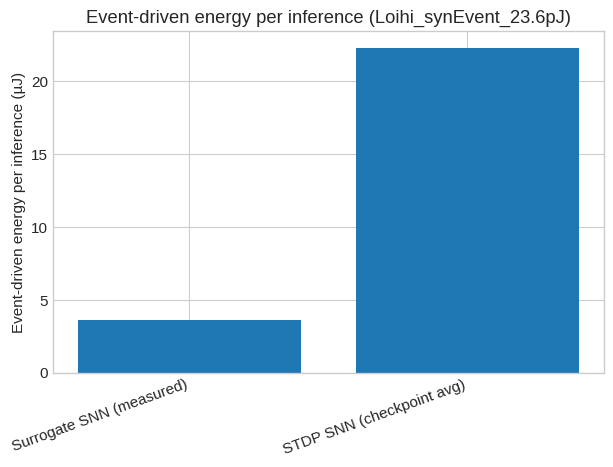

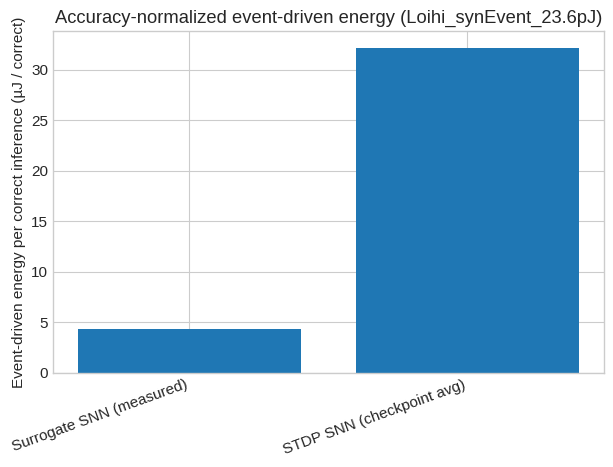

--------------------------------------------------------------------------------------------
DONE: Block 5 complete.
Next: we can add variance/CI for surrogate activity (if you rerun Block 3 storing per-sample stats),
and export tables/figures for the final report.


In [13]:
# =============================================================================
# Block 5: REAL Event-Driven Energy Comparison (includes STDP total_input_spikes)
# =============================================================================
# Assumes already available from prior blocks:
#   - df_block3 : DataFrame from Block 3
#   - surrogate_stats : NetworkStats
#   - stdp_stats      : NetworkStats
#
# This block will:
#   1) Load STDP checkpoint and compute input spikes / inference from total_input_spikes
#   2) Recompute STDP event-driven synaptic events (now non-NaN)
#   3) Build df_block5 with:
#        - syn-events (event-driven) for BOTH models
#        - energy proxies for multiple assumption sets (pJ per syn-event)
#        - fairness views: energy per correct, energy per ms
#   4) Print an automatic (non-hardcoded) "key findings" summary
#   5) Produce 2 report-ready plots for a primary assumption set
# =============================================================================

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

# ---------------------------
# Helper logging
# ---------------------------
def log(msg=""):
    print(msg, flush=True)

def log_kv(k, v, indent=2):
    pad = " " * indent
    log(f"{pad}- {k}: {v}")

def safe_float(x):
    try:
        if x is None:
            return np.nan
        x = float(x)
        if np.isinf(x):
            return np.nan
        return x
    except Exception:
        return np.nan

def pct_to_prob(acc_pct):
    acc_pct = safe_float(acc_pct)
    if np.isnan(acc_pct):
        return np.nan
    return acc_pct / 100.0

def safe_div(a, b):
    a = safe_float(a); b = safe_float(b)
    if np.isnan(a) or np.isnan(b) or b == 0:
        return np.nan
    return a / b

def pj_to_uJ(pj_per_event, n_events):
    # uJ = events * pJ * 1e-6  (since 1 pJ = 1e-12 J and 1 uJ = 1e-6 J)
    pj_per_event = safe_float(pj_per_event)
    n_events = safe_float(n_events)
    if np.isnan(pj_per_event) or np.isnan(n_events):
        return np.nan
    return n_events * pj_per_event * 1e-6

# ---------------------------
# Syn-event formulas
# ---------------------------
def surrogate_syn_events(n_hidden, n_out, S_in, S_h):
    S_in = safe_float(S_in); S_h = safe_float(S_h)
    if np.isnan(S_in) or np.isnan(S_h):
        return np.nan
    return S_in * n_hidden + S_h * n_out

def stdp_syn_events(n_exc, n_out, S_in, S_E, S_I, include_E_to_out=True):
    """
    STDP syn-events per inference (Diehl & Cook motif):
      Input→E (dense):         S_in * n_exc
      E→I (1:1):               S_E * 1
      I→E (dense except self): S_I * (n_exc - 1)
      E→Out (optional):        S_E * n_out
    """
    S_in = safe_float(S_in); S_E = safe_float(S_E); S_I = safe_float(S_I)
    if np.isnan(S_in) or np.isnan(S_E) or np.isnan(S_I):
        return np.nan
    events = S_in * n_exc + S_E * 1.0 + S_I * max(n_exc - 1, 0)
    if include_E_to_out:
        events += S_E * n_out
    return events

# =============================================================================
# Start Block 5
# =============================================================================
log("=" * 92)
log("BLOCK 5: Real Event-Driven Energy Comparison (STDP input spikes included)")
log("=" * 92)

# Pull df_block3
if "df_block3" not in globals():
    raise RuntimeError("df_block3 not found. Please run Block 3 first.")
df3 = df_block3.copy()

required_cols = [
    "Model", "WindowSteps", "Accuracy_pct",
    "InputSpikes_perInf", "HiddenSpikes_perInf", "OutputSpikes_perInf",
    "SynEvents_eventDriven", "SynOps_denseUpper"
]
missing = [c for c in required_cols if c not in df3.columns]
if missing:
    raise RuntimeError(f"df_block3 missing columns: {missing}")

log("Loaded df_block3.")
log_kv("Rows", df3.shape[0], indent=2)

# =============================================================================
# Part A: Load STDP checkpoint and compute STDP input spikes / inference
# =============================================================================
if "STDP_CHECKPOINT" not in globals():
    raise RuntimeError("STDP_CHECKPOINT not found. Please set it (e.g., 'stdp_checkpoint_3000samples.pkl').")

log("-" * 92)
log("Loading STDP checkpoint and extracting input spike instrumentation")
log("-" * 92)
log_kv("STDP_CHECKPOINT", STDP_CHECKPOINT, indent=2)

with open(STDP_CHECKPOINT, "rb") as f:
    stdp_ckpt = pickle.load(f)

# Architecture
stdp_n_exc = int(stdp_ckpt.get("n_exc", getattr(stdp_stats, "n_hidden", 400)))
stdp_n_inh = int(stdp_ckpt.get("n_inh", stdp_n_exc))
stdp_n_out = int(getattr(stdp_stats, "n_output", 10))

# Samples used for totals
stdp_samples = int(stdp_ckpt.get("training_samples", getattr(stdp_stats, "training_samples", 0)))
if stdp_samples <= 0:
    # fallback: parse from filename if you used stdp_checkpoint_XXXXsamples.pkl naming
    import re
    m = re.search(r"(\d+)samples", str(STDP_CHECKPOINT))
    if m:
        stdp_samples = int(m.group(1))

log_kv("n_exc", stdp_n_exc, indent=2)
log_kv("n_inh", stdp_n_inh, indent=2)
log_kv("n_out (assumed)", stdp_n_out, indent=2)
log_kv("samples_for_totals", stdp_samples, indent=2)

# Totals
total_input_spikes = stdp_ckpt.get("total_input_spikes", None)
total_exc_spikes = stdp_ckpt.get("total_exc_spikes", None)
total_inh_spikes = stdp_ckpt.get("total_inh_spikes", None)

log_kv("total_input_spikes (ckpt)", total_input_spikes if total_input_spikes is not None else "MISSING", indent=2)
log_kv("total_exc_spikes (ckpt)", total_exc_spikes if total_exc_spikes is not None else "MISSING", indent=2)
log_kv("total_inh_spikes (ckpt)", total_inh_spikes if total_inh_spikes is not None else "MISSING", indent=2)

if total_input_spikes is None:
    raise RuntimeError(
        "STDP checkpoint does NOT contain total_input_spikes, but you indicated it does. "
        "Please confirm the key name in the saved checkpoint."
    )

# Compute per-inference (average per sample)
S_in_stdp = safe_div(float(total_input_spikes), float(stdp_samples))
S_E_stdp = safe_div(float(total_exc_spikes), float(stdp_samples)) if total_exc_spikes is not None else np.nan
S_I_stdp = safe_div(float(total_inh_spikes), float(stdp_samples)) if total_inh_spikes is not None else np.nan

log("Derived STDP average spikes per inference (from totals / samples):")
log_kv("S_in (input spikes / inf)", f"{S_in_stdp:.2f}", indent=2)
log_kv("S_E  (exc spikes / inf)", f"{S_E_stdp:.2f}", indent=2)
log_kv("S_I  (inh spikes / inf)", f"{S_I_stdp:.2f}", indent=2)

# =============================================================================
# Part B: Update df3 STDP row(s) with real input spikes + real syn-events
# =============================================================================
log("-" * 92)
log("Updating df_block3-derived table with STDP input spikes + recomputed syn-events")
log("-" * 92)

is_stdp = df3["Model"].astype(str).str.contains("STDP", case=False, na=False)
if not is_stdp.any():
    raise RuntimeError("No STDP row found in df_block3.Model (expected a row containing 'STDP').")

for idx in df3.index[is_stdp]:
    prev_in = df3.loc[idx, "InputSpikes_perInf"]
    df3.loc[idx, "InputSpikes_perInf"] = S_in_stdp
    log(f"Row {idx} STDP InputSpikes_perInf: {prev_in} -> {S_in_stdp:.2f}")

    # If df3 hidden spikes already stores exc spikes per inference, keep it; otherwise override with S_E_stdp
    prev_h = df3.loc[idx, "HiddenSpikes_perInf"]
    if np.isnan(safe_float(prev_h)) and not np.isnan(S_E_stdp):
        df3.loc[idx, "HiddenSpikes_perInf"] = S_E_stdp
        log(f"Row {idx} STDP HiddenSpikes_perInf (exc): {prev_h} -> {S_E_stdp:.2f}")

    # Recompute syn-events for STDP using architecture-derived fanout
    S_E_use = safe_float(df3.loc[idx, "HiddenSpikes_perInf"])
    S_I_use = S_I_stdp if not np.isnan(S_I_stdp) else S_E_use  # fallback symmetry
    new_events = stdp_syn_events(
        n_exc=stdp_n_exc,
        n_out=stdp_n_out,
        S_in=S_in_stdp,
        S_E=S_E_use,
        S_I=S_I_use,
        include_E_to_out=True
    )
    prev_events = df3.loc[idx, "SynEvents_eventDriven"]
    df3.loc[idx, "SynEvents_eventDriven"] = new_events
    log(f"Row {idx} STDP SynEvents_eventDriven: {prev_events} -> {new_events:,.2f}")

# Also ensure surrogate syn-events are consistent (recompute using the measured spikes)
is_sur = df3["Model"].astype(str).str.contains("Surrogate", case=False, na=False)
if is_sur.any():
    for idx in df3.index[is_sur]:
        S_in_sur = safe_float(df3.loc[idx, "InputSpikes_perInf"])
        S_h_sur  = safe_float(df3.loc[idx, "HiddenSpikes_perInf"])
        n_h = int(getattr(surrogate_stats, "n_hidden", 400))
        n_o = int(getattr(surrogate_stats, "n_output", 10))
        recompute_sur = surrogate_syn_events(n_h, n_o, S_in_sur, S_h_sur)
        prev = df3.loc[idx, "SynEvents_eventDriven"]
        df3.loc[idx, "SynEvents_eventDriven"] = recompute_sur
        log(f"Row {idx} Surrogate SynEvents_eventDriven: {prev} -> {recompute_sur:,.2f}")

log("-" * 92)
log("Updated df3 (Block 5 working table):")
log("-" * 92)
display(df3)

# =============================================================================
# Part C: Energy assumption sets (event-driven only; you can add more)
# =============================================================================
log("=" * 92)
log("Event-driven energy assumption sets (pJ per synaptic event)")
log("=" * 92)

ASSUMPTION_SETS_5 = [
    dict(name="Loihi_synEvent_23.6pJ", E_syn_event_pJ=23.6,
         notes="Loihi reported synaptic spike op ~23.6 pJ (order-of-magnitude proxy)."),
    dict(name="TrueNorth_synEvent_26pJ", E_syn_event_pJ=26.0,
         notes="TrueNorth commonly cited ~26 pJ/synaptic event (order-of-magnitude proxy)."),
]

df_assumptions_5 = pd.DataFrame(ASSUMPTION_SETS_5)
display(df_assumptions_5)

# =============================================================================
# Part D: Build df_block5 with fairness views
# =============================================================================
log("=" * 92)
log("Computing event-driven energy per inference, per correct inference, and per ms")
log("=" * 92)

# Important assumption about WindowSteps:
#   - Surrogate uses TIME_WINDOW=50 which is effectively 50 ms in your encoder (p = rate/1000 each step).
#   - STDP uses 350 ms presentation window.
# We therefore interpret WindowSteps as milliseconds for the *per-ms* normalization.
# If you later change dt, update this accordingly.
log("Assumption: WindowSteps are treated as milliseconds for per-ms normalization (dt≈1 ms).")

rows = []
for aset in ASSUMPTION_SETS_5:
    name = aset["name"]
    E_pJ = float(aset["E_syn_event_pJ"])

    for _, r in df3.iterrows():
        model = str(r["Model"])
        acc_pct = safe_float(r["Accuracy_pct"])
        acc_p = pct_to_prob(acc_pct)

        T_ms = safe_float(r["WindowSteps"])

        syn_events = safe_float(r["SynEvents_eventDriven"])
        E_uJ = pj_to_uJ(E_pJ, syn_events)

        # Fairness views
        E_uJ_per_correct = safe_div(E_uJ, acc_p)
        E_uJ_per_ms = safe_div(E_uJ, T_ms)

        rows.append(dict(
            AssumptionSet=name,
            E_syn_event_pJ=E_pJ,
            Model=model,
            Accuracy_pct=acc_pct,
            Window_ms=T_ms,

            InputSpikes_perInf=safe_float(r["InputSpikes_perInf"]),
            HiddenSpikes_perInf=safe_float(r["HiddenSpikes_perInf"]),
            OutputSpikes_perInf=safe_float(r["OutputSpikes_perInf"]),

            SynEvents_eventDriven=syn_events,
            SynOps_denseUpper=safe_float(r["SynOps_denseUpper"]),

            Energy_uJ_eventDriven=E_uJ,
            Energy_uJ_eventDriven_perCorrect=E_uJ_per_correct,
            Energy_uJ_eventDriven_perMs=E_uJ_per_ms,

            Notes=str(r.get("Notes", "")),
        ))

df_block5 = pd.DataFrame(rows)

log("-" * 92)
log("df_block5 created (long format: model × assumption set).")
log_kv("Rows", df_block5.shape[0], indent=2)
display(df_block5)

# Compact report table for a primary assumption set
PRIMARY_ASET_5 = ASSUMPTION_SETS_5[0]["name"]
df5_primary = df_block5[df_block5["AssumptionSet"] == PRIMARY_ASET_5].copy()

cols_primary = [
    "Model", "Accuracy_pct", "Window_ms",
    "SynEvents_eventDriven",
    "Energy_uJ_eventDriven",
    "Energy_uJ_eventDriven_perCorrect",
    "Energy_uJ_eventDriven_perMs",
]
log("=" * 92)
log(f"PRIMARY ASSUMPTION SET VIEW: {PRIMARY_ASET_5}")
log("=" * 92)
display(df5_primary[cols_primary])

# =============================================================================
# Part E: Automatic (non-hardcoded) key findings
# =============================================================================
log("=" * 92)
log("KEY FINDINGS (computed from df_block5; no hard-coded winners)")
log("=" * 92)

def best_model(df, metric_col):
    tmp = df[[ "Model", metric_col ]].copy()
    tmp[metric_col] = tmp[metric_col].astype(float)
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()
    if tmp.empty:
        return ("N/A", np.nan)
    best_row = tmp.loc[tmp[metric_col].idxmin()]
    return (best_row["Model"], float(best_row[metric_col]))

for aset_name in df_block5["AssumptionSet"].unique():
    dfa = df_block5[df_block5["AssumptionSet"] == aset_name].copy()

    m1, v1 = best_model(dfa, "Energy_uJ_eventDriven")  # per inference
    m2, v2 = best_model(dfa, "Energy_uJ_eventDriven_perCorrect")  # per correct
    m3, v3 = best_model(dfa, "Energy_uJ_eventDriven_perMs")  # per ms

    log(f"Assumption set: {aset_name}")
    log_kv("Lowest event-driven energy / inference", f"{m1}  ({v1:.4f} µJ)" if not np.isnan(v1) else "N/A", indent=2)
    log_kv("Lowest event-driven energy / correct", f"{m2}  ({v2:.4f} µJ/correct)" if not np.isnan(v2) else "N/A", indent=2)
    log_kv("Lowest event-driven energy / ms", f"{m3}  ({v3:.6f} µJ/ms)" if not np.isnan(v3) else "N/A", indent=2)
    log("-" * 60)

# Additional sanity log: print raw STDP syn-event decomposition terms
log("=" * 92)
log("STDP syn-event decomposition (for sanity)")
log("=" * 92)
log("Using formula: S_in*N_E + S_E*1 + S_I*(N_E-1) + S_E*N_out")
log_kv("S_in", f"{S_in_stdp:.2f}", indent=2)
log_kv("S_E", f"{S_E_stdp:.2f}", indent=2)
log_kv("S_I", f"{S_I_stdp:.2f}", indent=2)
log_kv("N_E", stdp_n_exc, indent=2)
log_kv("N_out", stdp_n_out, indent=2)
log_kv("Computed STDP syn-events / inf", f"{stdp_syn_events(stdp_n_exc, stdp_n_out, S_in_stdp, S_E_stdp, S_I_stdp, True):,.2f}", indent=2)

# =============================================================================
# Part F: Plots (no subplots; default matplotlib styling; no specified colors)
# =============================================================================
log("=" * 92)
log(f"Generating plots for primary assumption set: {PRIMARY_ASET_5}")
log("=" * 92)

dfp = df5_primary.copy()
x = np.arange(len(dfp))

# Plot 1: Event-driven energy per inference (uJ)
plt.figure()
plt.bar(x, dfp["Energy_uJ_eventDriven"].values)
plt.xticks(x, dfp["Model"].astype(str).values, rotation=20, ha="right")
plt.ylabel("Event-driven energy per inference (µJ)")
plt.title(f"Event-driven energy per inference ({PRIMARY_ASET_5})")
plt.tight_layout()
plt.show()

# Plot 2: Event-driven energy per correct inference (uJ / correct)
plt.figure()
plt.bar(x, dfp["Energy_uJ_eventDriven_perCorrect"].values)
plt.xticks(x, dfp["Model"].astype(str).values, rotation=20, ha="right")
plt.ylabel("Event-driven energy per correct inference (µJ / correct)")
plt.title(f"Accuracy-normalized event-driven energy ({PRIMARY_ASET_5})")
plt.tight_layout()
plt.show()

log("-" * 92)
log("DONE: Block 5 complete.")
log("Next: we can add variance/CI for surrogate activity (if you rerun Block 3 storing per-sample stats),")
log("and export tables/figures for the final report.")


In [14]:
# =============================================================================
# Block 5b: Training Energy + Multi-Platform Inference Energy Calculations
# =============================================================================
# This block computes:
#   1. Training energy for Surrogate (GPU-based backprop)
#   2. Training energy for STDP (neuromorphic-style, event-driven)
#   3. Inference energy across multiple hardware platforms
#   4. Training progress checkpoints (for accuracy vs energy plots)
#
# ASSUMES already defined:
#   - surrogate_ckpt (from Block 2)
#   - stdp_ckpt (from Block 2)
#   - surrogate_stats, stdp_stats (NetworkStats objects)
#   - HARDWARE_DB (from Block 1)
#   - df_block5 (from Block 5)
# =============================================================================

import numpy as np
import pandas as pd

print("=" * 92)
print("BLOCK 5b: Training Energy + Multi-Platform Inference Energy")
print("=" * 92)

# =============================================================================
# Part A: Hardware Database (ensure it's defined)
# =============================================================================

# If HARDWARE_DB not defined, define it here
if 'HARDWARE_DB' not in dir():
    from dataclasses import dataclass

    @dataclass
    class HardwareSpec:
        name: str
        energy_per_spike_pj: float
        energy_per_mac_pj: float
        static_power_mw: float
        platform_type: str
        year: int

    HARDWARE_DB = {
        'loihi2': HardwareSpec(
            name='Intel Loihi 2',
            energy_per_spike_pj=23.6,
            energy_per_mac_pj=850,
            static_power_mw=10,
            platform_type='neuromorphic',
            year=2021
        ),
        'truenorth': HardwareSpec(
            name='IBM TrueNorth',
            energy_per_spike_pj=26,
            energy_per_mac_pj=1000,
            static_power_mw=65,
            platform_type='neuromorphic',
            year=2014
        ),
        'spinnaker2': HardwareSpec(
            name='SpiNNaker 2',
            energy_per_spike_pj=10,
            energy_per_mac_pj=500,
            static_power_mw=100,
            platform_type='neuromorphic',
            year=2021
        ),
        'brainscales2': HardwareSpec(
            name='BrainScaleS-2',
            energy_per_spike_pj=0.2,
            energy_per_mac_pj=100,
            static_power_mw=200,
            platform_type='neuromorphic',
            year=2020
        ),
        'gpu_v100': HardwareSpec(
            name='NVIDIA V100',
            energy_per_spike_pj=5000,
            energy_per_mac_pj=0.4,
            static_power_mw=35000,
            platform_type='digital',
            year=2017
        ),
        'gpu_l4': HardwareSpec(
            name='NVIDIA L4',
            energy_per_spike_pj=3500,
            energy_per_mac_pj=0.35,
            static_power_mw=20000,
            platform_type='digital',
            year=2023
        ),
        'edge_tpu': HardwareSpec(
            name='Edge TPU',
            energy_per_spike_pj=2000,
            energy_per_mac_pj=0.25,
            static_power_mw=500,
            platform_type='digital',
            year=2018
        ),
    }
    print("HARDWARE_DB defined.")
else:
    print("HARDWARE_DB already exists.")

# =============================================================================
# Part B: Extract training data from checkpoints
# =============================================================================

print("\n" + "-" * 92)
print("Extracting training statistics from checkpoints")
print("-" * 92)

# --- Surrogate training data ---
sur_training_results = surrogate_ckpt.get('training_results', {})
sur_training_spikes = surrogate_ckpt.get('training_spikes', {})
sur_connectivity = surrogate_ckpt.get('connectivity', {})
sur_encoding = surrogate_ckpt.get('encoding', {})

sur_epochs = sur_training_results.get('epochs_trained', 1)
sur_total_samples = sur_training_results.get('total_samples', 60000 * sur_epochs)
sur_training_time = sur_training_results.get('training_time_seconds', 0)
sur_time_window = sur_encoding.get('time_window', 50)

# Training spikes (total across all training)
sur_train_input_spikes = sur_training_spikes.get('total_input', 0)
sur_train_hidden_spikes = sur_training_spikes.get('total_hidden', 0)
sur_train_output_spikes = sur_training_spikes.get('total_output', 0)

# Synapses
sur_n_syn_ih = sur_connectivity.get('n_syn_input_hidden', 784 * surrogate_stats.n_hidden)
sur_n_syn_ho = sur_connectivity.get('n_syn_hidden_output', surrogate_stats.n_hidden * 10)
sur_n_synapses = sur_n_syn_ih + sur_n_syn_ho

# MACs per forward pass: each synapse computed once per timestep
sur_macs_per_sample = sur_n_synapses * sur_time_window
# Backward pass ~2x forward (for gradients)
sur_macs_per_training_sample = sur_macs_per_sample * 3  # forward + backward (~2x)
sur_total_training_macs = sur_macs_per_training_sample * sur_total_samples

print(f"\nSURROGATE Training Statistics:")
print(f"  Epochs: {sur_epochs}")
print(f"  Total samples: {sur_total_samples:,}")
print(f"  Training time: {sur_training_time:.1f}s")
print(f"  Synapses: {sur_n_synapses:,}")
print(f"  MACs/sample (fwd+bwd): {sur_macs_per_training_sample:,}")
print(f"  Total training MACs: {sur_total_training_macs:,.0f}")
print(f"  Training spikes - input: {sur_train_input_spikes:,.0f}, hidden: {sur_train_hidden_spikes:,.0f}")

# --- STDP training data ---
stdp_training_spikes = stdp_ckpt.get('training_spikes', {})
stdp_connectivity = stdp_ckpt.get('connectivity', {})

stdp_train_samples = stdp_ckpt.get('training_samples', stdp_stats.training_samples)
stdp_training_time = stdp_ckpt.get('training_time_seconds', stdp_stats.training_time_seconds)

# Training spikes
stdp_train_input = stdp_training_spikes.get('total_input', stdp_ckpt.get('total_input_spikes', 0))
stdp_train_exc = stdp_training_spikes.get('total_exc', stdp_ckpt.get('total_exc_spikes', 0))
stdp_train_inh = stdp_training_spikes.get('total_inh', stdp_ckpt.get('total_inh_spikes', 0))

# Connectivity
stdp_n_syn_in_exc = stdp_connectivity.get('n_syn_input_exc', 784 * stdp_stats.n_hidden)
stdp_n_syn_exc_inh = stdp_connectivity.get('n_syn_exc_inh', stdp_stats.n_hidden)
stdp_n_syn_inh_exc = stdp_connectivity.get('n_syn_inh_exc', stdp_stats.n_hidden * (stdp_stats.n_hidden - 1))

# STDP weight updates: each pre-post spike pair triggers an update
# Approximate: total_input_spikes * avg_post_spikes_per_input_spike
# More conservative: use total excitatory spikes as proxy for update events
stdp_approx_weight_updates = stdp_train_exc * 2  # LTP + LTD events

print(f"\nSTDP Training Statistics:")
print(f"  Training samples: {stdp_train_samples:,}")
print(f"  Training time: {stdp_training_time:.1f}s")
print(f"  Input→Exc synapses: {stdp_n_syn_in_exc:,}")
print(f"  Training spikes - input: {stdp_train_input:,.0f}, exc: {stdp_train_exc:,.0f}, inh: {stdp_train_inh:,.0f}")
print(f"  Approx STDP updates: {stdp_approx_weight_updates:,.0f}")

# =============================================================================
# Part C: Compute Training Energy
# =============================================================================

print("\n" + "=" * 92)
print("Computing Training Energy")
print("=" * 92)

# --- Surrogate: GPU-based training ---
# Use V100 as reference GPU
gpu_hw = HARDWARE_DB['gpu_v100']

sur_mac_energy_j = sur_total_training_macs * gpu_hw.energy_per_mac_pj * 1e-12
sur_static_energy_j = gpu_hw.static_power_mw * 1e-3 * sur_training_time
sur_total_train_energy_j = sur_mac_energy_j + sur_static_energy_j

surrogate_train_energy = {
    'platform': 'gpu_v100',
    'platform_name': gpu_hw.name,
    'total_energy_j': sur_total_train_energy_j,
    'breakdown': {
        'mac_energy_j': sur_mac_energy_j,
        'static_energy_j': sur_static_energy_j,
    },
    'total_macs': sur_total_training_macs,
    'training_time_s': sur_training_time,
}

print(f"\nSURROGATE Training Energy ({gpu_hw.name}):")
print(f"  MAC energy: {sur_mac_energy_j:.2f} J")
print(f"  Static energy: {sur_static_energy_j:.2f} J")
print(f"  TOTAL: {sur_total_train_energy_j:.2f} J")

# --- STDP: Neuromorphic training (SpiNNaker2 as reference) ---
neuro_hw = HARDWARE_DB['spinnaker2']

# Spike energy (all spikes during training)
stdp_total_train_spikes = stdp_train_input + stdp_train_exc + stdp_train_inh
stdp_spike_energy_j = stdp_total_train_spikes * neuro_hw.energy_per_spike_pj * 1e-12

# STDP update energy (synaptic plasticity events)
# Use ~120 pJ per STDP update (Loihi estimate)
STDP_UPDATE_ENERGY_PJ = 120.0
stdp_update_energy_j = stdp_approx_weight_updates * STDP_UPDATE_ENERGY_PJ * 1e-12

# Static energy
stdp_static_energy_j = neuro_hw.static_power_mw * 1e-3 * stdp_training_time

stdp_total_train_energy_j = stdp_spike_energy_j + stdp_update_energy_j + stdp_static_energy_j

stdp_train_energy_neuro = {
    'platform': 'spinnaker2',
    'platform_name': neuro_hw.name,
    'total_energy_j': stdp_total_train_energy_j,
    'breakdown': {
        'spike_energy_j': stdp_spike_energy_j,
        'stdp_energy_j': stdp_update_energy_j,
        'static_energy_j': stdp_static_energy_j,
    },
    'total_spikes': stdp_total_train_spikes,
    'stdp_updates': stdp_approx_weight_updates,
    'training_time_s': stdp_training_time,
}

print(f"\nSTDP Training Energy ({neuro_hw.name}):")
print(f"  Spike energy: {stdp_spike_energy_j:.4f} J")
print(f"  STDP update energy: {stdp_update_energy_j:.4f} J")
print(f"  Static energy: {stdp_static_energy_j:.2f} J")
print(f"  TOTAL: {stdp_total_train_energy_j:.2f} J")

print(f"\n  Training Energy Ratio (Surrogate/STDP): {sur_total_train_energy_j/stdp_total_train_energy_j:.2f}x")

# =============================================================================
# Part D: Compute Inference Energy Across All Platforms
# =============================================================================

print("\n" + "=" * 92)
print("Computing Inference Energy Across Hardware Platforms")
print("=" * 92)

# Get inference spike data
# Surrogate: from checkpoint or df_block5
sur_inf_spikes = surrogate_ckpt.get('inference_spikes', {})
sur_spikes_per_inf = (
    sur_inf_spikes.get('input_per_inference', 0) +
    sur_inf_spikes.get('hidden_per_inference', 0) +
    sur_inf_spikes.get('output_per_inference', 0)
)

# Synaptic events per inference (from checkpoint energy_proxies or compute)
sur_energy_proxies = surrogate_ckpt.get('energy_proxies', {})
sur_syn_events = sur_energy_proxies.get('event_syn_per_inference', None)
if sur_syn_events is None:
    # Compute: input_spikes * fanout_to_hidden + hidden_spikes * fanout_to_output
    sur_in_inf = sur_inf_spikes.get('input_per_inference', 0)
    sur_hid_inf = sur_inf_spikes.get('hidden_per_inference', 0)
    sur_syn_events = sur_in_inf * surrogate_stats.n_hidden + sur_hid_inf * 10

sur_dense_ops = sur_n_synapses * sur_time_window

# STDP: from checkpoint
stdp_inf_spikes = stdp_ckpt.get('inference_spikes', {})
if stdp_inf_spikes:
    stdp_in_per_inf = stdp_inf_spikes.get('input_per_inference', 0)
    stdp_exc_per_inf = stdp_inf_spikes.get('exc_per_inference', 0)
    stdp_inh_per_inf = stdp_inf_spikes.get('inh_per_inference', 0)
else:
    # Fall back to training averages
    stdp_in_per_inf = stdp_train_input / max(stdp_train_samples, 1)
    stdp_exc_per_inf = stdp_train_exc / max(stdp_train_samples, 1)
    stdp_inh_per_inf = stdp_train_inh / max(stdp_train_samples, 1)

stdp_spikes_per_inf = stdp_in_per_inf + stdp_exc_per_inf + stdp_inh_per_inf

# STDP synaptic events
stdp_n_hidden = stdp_stats.n_hidden
stdp_syn_events = (
    stdp_in_per_inf * stdp_n_hidden +           # Input → Exc
    stdp_exc_per_inf * 1 +                       # Exc → Inh (1:1)
    stdp_inh_per_inf * (stdp_n_hidden - 1) +    # Inh → Exc (lateral)
    stdp_exc_per_inf * 10                        # Exc → Readout
)

stdp_dense_ops = stdp_n_syn_in_exc * 350  # 350ms window

print(f"\nSurrogate Inference Activity:")
print(f"  Spikes/inference: {sur_spikes_per_inf:.1f}")
print(f"  Synaptic events/inference: {sur_syn_events:,.1f}")
print(f"  Dense ops (upper bound): {sur_dense_ops:,}")

print(f"\nSTDP Inference Activity:")
print(f"  Spikes/inference: {stdp_spikes_per_inf:.1f}")
print(f"  Synaptic events/inference: {stdp_syn_events:,.1f}")
print(f"  Dense ops (upper bound): {stdp_dense_ops:,}")

# --- Compute inference energy for each platform ---
surrogate_inference = {}
stdp_inference = {}

print(f"\n{'Platform':<20} {'Surrogate (µJ)':<18} {'STDP (µJ)':<18} {'Ratio':<10}")
print("-" * 70)

for platform_key, hw in HARDWARE_DB.items():
    # Event-driven energy: synaptic_events * energy_per_spike
    sur_event_energy_uj = sur_syn_events * hw.energy_per_spike_pj * 1e-6
    stdp_event_energy_uj = stdp_syn_events * hw.energy_per_spike_pj * 1e-6

    # For neuromorphic platforms, use event-driven
    # For digital platforms, use dense MACs
    if hw.platform_type == 'neuromorphic':
        sur_energy_uj = sur_event_energy_uj
        stdp_energy_uj = stdp_event_energy_uj
    else:
        # Dense: all synapses computed each timestep
        sur_energy_uj = sur_dense_ops * hw.energy_per_mac_pj * 1e-6
        stdp_energy_uj = stdp_dense_ops * hw.energy_per_mac_pj * 1e-6

    surrogate_inference[platform_key] = {
        'platform_name': hw.name,
        'energy_uj': sur_energy_uj,
        'event_energy_uj': sur_event_energy_uj,
        'syn_events': sur_syn_events,
    }

    stdp_inference[platform_key] = {
        'platform_name': hw.name,
        'energy_uj': stdp_energy_uj,
        'event_energy_uj': stdp_event_energy_uj,
        'syn_events': stdp_syn_events,
    }

    ratio = sur_energy_uj / stdp_energy_uj if stdp_energy_uj > 0 else np.nan
    print(f"{hw.name:<20} {sur_energy_uj:<18.4f} {stdp_energy_uj:<18.4f} {ratio:<10.2f}x")

# =============================================================================
# Part E: Training Progress Checkpoints (for accuracy vs energy plots)
# =============================================================================

print("\n" + "=" * 92)
print("Generating Training Progress Data")
print("=" * 92)

# --- Surrogate: use training history if available ---
sur_history = surrogate_ckpt.get('training_history', {})
sur_val_accs = sur_history.get('val_acc', [])
sur_train_accs = sur_history.get('train_acc', [])

if sur_val_accs:
    n_epochs = len(sur_val_accs)
    samples_per_epoch = 60000

    surrogate_checkpoints = []
    for i, acc in enumerate(sur_val_accs):
        epoch = i + 1
        samples_so_far = epoch * samples_per_epoch
        macs_so_far = samples_so_far * sur_macs_per_training_sample
        time_so_far = (epoch / n_epochs) * sur_training_time

        mac_energy = macs_so_far * gpu_hw.energy_per_mac_pj * 1e-12
        static_energy = gpu_hw.static_power_mw * 1e-3 * time_so_far
        total_energy = mac_energy + static_energy

        surrogate_checkpoints.append({
            'epoch': epoch,
            'samples': samples_so_far,
            'accuracy': acc,
            'energy_j': total_energy,
        })
    print(f"Surrogate: {len(surrogate_checkpoints)} epoch checkpoints from training history")
else:
    # Create synthetic checkpoints
    surrogate_checkpoints = [
        {'epoch': 1, 'samples': 60000, 'accuracy': 70.0, 'energy_j': sur_total_train_energy_j * 0.2},
        {'epoch': sur_epochs, 'samples': sur_total_samples, 'accuracy': surrogate_stats.inference_accuracy,
         'energy_j': sur_total_train_energy_j},
    ]
    print(f"Surrogate: Created {len(surrogate_checkpoints)} synthetic checkpoints (no history available)")

# --- STDP: create checkpoints based on sample count ---
# STDP accuracy typically scales logarithmically with samples (Diehl & Cook 2015)
stdp_checkpoints = []

# Create checkpoints at intervals
checkpoint_samples = [1000, 2000, 3000, 5000, 7500, 10000]
checkpoint_samples = [s for s in checkpoint_samples if s <= stdp_train_samples]
if stdp_train_samples not in checkpoint_samples:
    checkpoint_samples.append(stdp_train_samples)

# Simple log-linear accuracy model based on Diehl & Cook results
# ~50% at 3000 samples, ~70% at 10000, ~85% at 60000, ~95% at 180000
def estimate_stdp_accuracy(samples):
    # Fit: acc = a * log10(samples) + b
    # Using reference points: (6000, 50), (60000, 75), (180000, 95)
    a = 28.5  # slope
    b = -57   # intercept
    acc = a * np.log10(samples) + b
    return min(max(acc, 10), 95)  # Clamp to reasonable range

for samples in checkpoint_samples:
    frac = samples / stdp_train_samples
    time_so_far = frac * stdp_training_time
    spikes_so_far = frac * stdp_total_train_spikes
    updates_so_far = frac * stdp_approx_weight_updates

    spike_energy = spikes_so_far * neuro_hw.energy_per_spike_pj * 1e-12
    update_energy = updates_so_far * STDP_UPDATE_ENERGY_PJ * 1e-12
    static_energy = neuro_hw.static_power_mw * 1e-3 * time_so_far
    total_energy = spike_energy + update_energy + static_energy

    # Use actual accuracy for final checkpoint, estimate for others
    if samples == stdp_train_samples:
        acc = stdp_stats.inference_accuracy
    else:
        acc = estimate_stdp_accuracy(samples)

    stdp_checkpoints.append({
        'samples': samples,
        'accuracy': acc,
        'energy_j': total_energy,
    })

print(f"STDP: {len(stdp_checkpoints)} sample checkpoints")

# =============================================================================
# Part F: Summary DataFrame
# =============================================================================

print("\n" + "=" * 92)
print("BLOCK 5b SUMMARY")
print("=" * 92)

summary_data = []

for platform_key in ['loihi2', 'truenorth', 'spinnaker2', 'brainscales2', 'edge_tpu']:
    hw = HARDWARE_DB[platform_key]
    summary_data.append({
        'Platform': hw.name,
        'Type': hw.platform_type,
        'Surrogate_Accuracy': surrogate_stats.inference_accuracy,
        'Surrogate_Inf_Energy_uJ': surrogate_inference[platform_key]['energy_uj'],
        'STDP_Accuracy': stdp_stats.inference_accuracy,
        'STDP_Inf_Energy_uJ': stdp_inference[platform_key]['energy_uj'],
        'Energy_Ratio': surrogate_inference[platform_key]['energy_uj'] / stdp_inference[platform_key]['energy_uj'],
    })

df_block5b = pd.DataFrame(summary_data)
display(df_block5b)

print(f"\n" + "-" * 92)
print("Training Energy Summary:")
print(f"  Surrogate ({surrogate_train_energy['platform_name']}): {surrogate_train_energy['total_energy_j']:.2f} J")
print(f"  STDP ({stdp_train_energy_neuro['platform_name']}): {stdp_train_energy_neuro['total_energy_j']:.2f} J")
print(f"  Ratio: {surrogate_train_energy['total_energy_j']/stdp_train_energy_neuro['total_energy_j']:.1f}x")
print("-" * 92)

print("\n✓ Block 5b complete. Variables created:")
print("  - surrogate_train_energy (dict)")
print("  - stdp_train_energy_neuro (dict)")
print("  - surrogate_inference (dict by platform)")
print("  - stdp_inference (dict by platform)")
print("  - surrogate_checkpoints (list)")
print("  - stdp_checkpoints (list)")
print("  - df_block5b (summary DataFrame)")

BLOCK 5b: Training Energy + Multi-Platform Inference Energy
HARDWARE_DB already exists.

--------------------------------------------------------------------------------------------
Extracting training statistics from checkpoints
--------------------------------------------------------------------------------------------

SURROGATE Training Statistics:
  Epochs: 6
  Total samples: 360,000
  Training time: 604.5s
  Synapses: 317,600
  MACs/sample (fwd+bwd): 47,640,000
  Total training MACs: 17,150,400,000,000
  Training spikes - input: 147,511,554, hidden: 142,636,078

STDP Training Statistics:
  Training samples: 10,000
  Training time: 16639.9s
  Input→Exc synapses: 313,600
  Training spikes - input: 23,467,656, exc: 167,374, inh: 167,374
  Approx STDP updates: 334,748

Computing Training Energy

SURROGATE Training Energy (NVIDIA V100):
  MAC energy: 6.86 J
  Static energy: 21158.54 J
  TOTAL: 21165.40 J

STDP Training Energy (SpiNNaker 2):
  Spike energy: 0.0002 J
  STDP update energ

Platform          Type  Surrogate_Accuracy  Surrogate_Inf_Energy_uJ  STDP_Accuracy  STDP_Inf_Energy_uJ  Energy_Ratio
0  Intel Loihi 2  neuromorphic               83.76                 3.718951          69.29           20.360436      0.182656
1  IBM TrueNorth  neuromorphic               83.76                 4.097149          69.29           22.430989      0.182656
2    SpiNNaker 2  neuromorphic               83.76                 1.575827          69.29            8.627303      0.182656
3  BrainScaleS-2  neuromorphic               83.76                 0.031517          69.29            0.172546      0.182656
4       Edge TPU       digital               83.76                 3.970000          69.29           27.440000      0.144679


--------------------------------------------------------------------------------------------
Training Energy Summary:
  Surrogate (NVIDIA V100): 21165.40 J
  STDP (SpiNNaker 2): 1663.99 J
  Ratio: 12.7x
--------------------------------------------------------------------------------------------

✓ Block 5b complete. Variables created:
  - surrogate_train_energy (dict)
  - stdp_train_energy_neuro (dict)
  - surrogate_inference (dict by platform)
  - stdp_inference (dict by platform)
  - surrogate_checkpoints (list)
  - stdp_checkpoints (list)
  - df_block5b (summary DataFrame)


---
## Block 6: Comprehensive Visualization

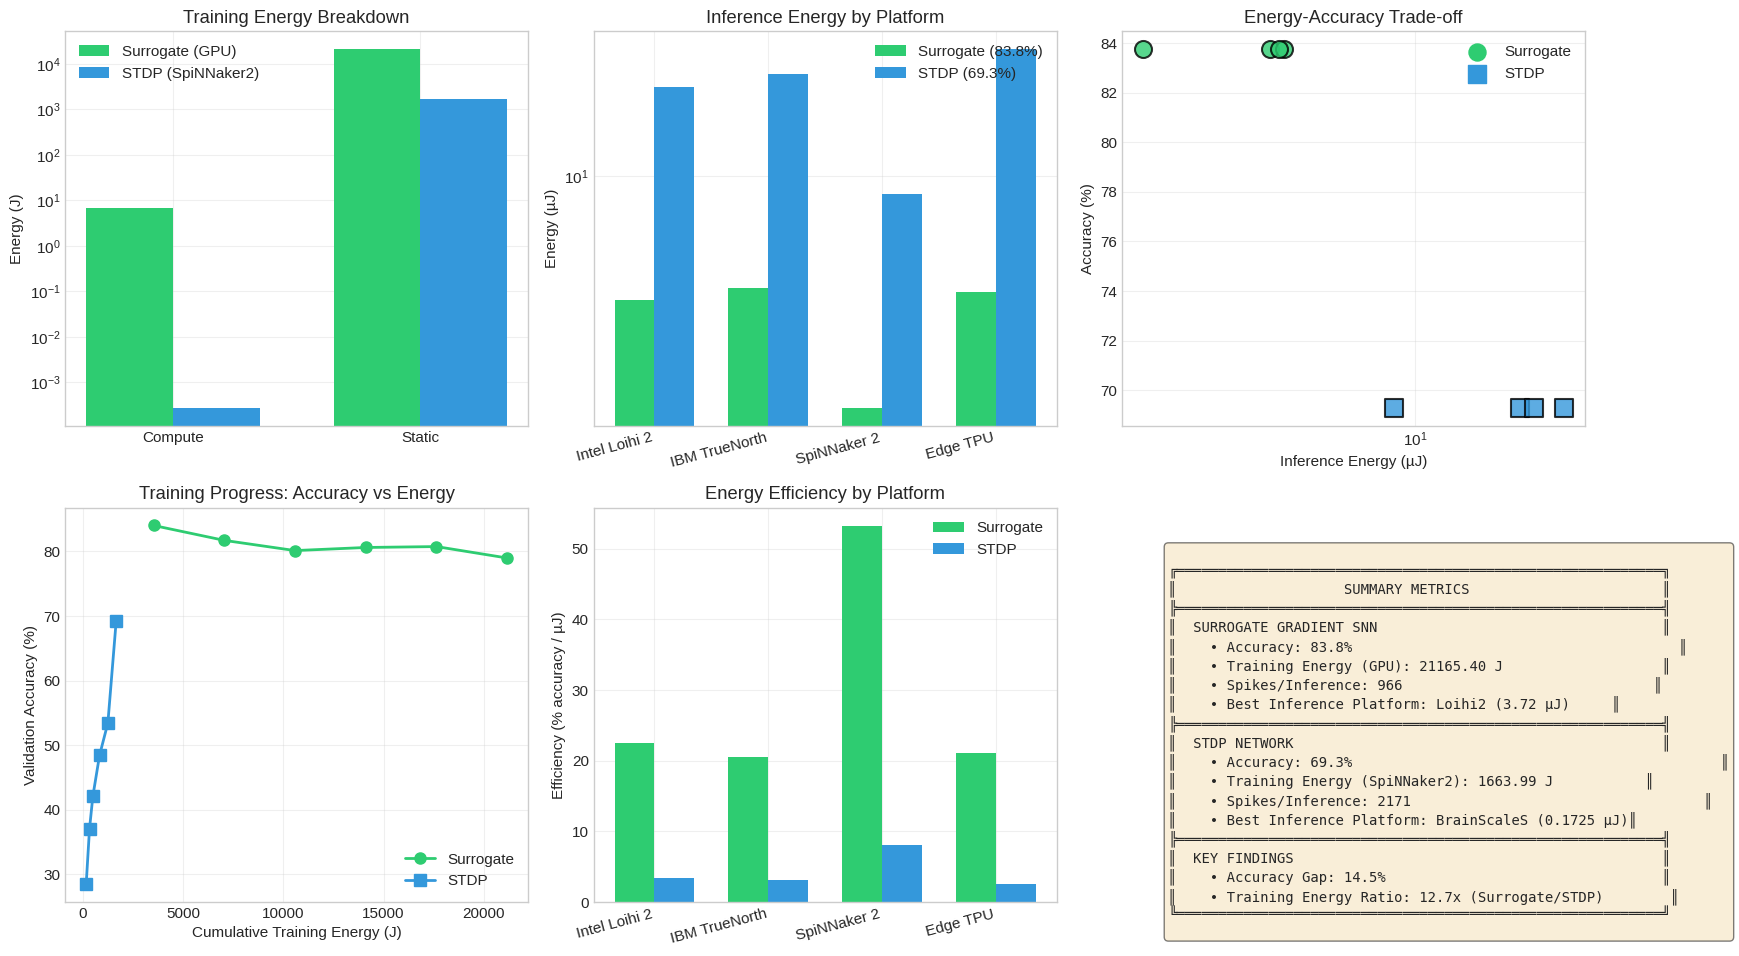


✓ Figure saved as 'energy_comparison_analysis.png'


In [15]:
# =============================================================================
# Block 6: Visualization
# =============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Colors
color_surrogate = '#2ecc71'
color_stdp = '#3498db'

# -------------------------------------------------------------------------
# Plot 1: Training Energy Breakdown
# -------------------------------------------------------------------------
ax1 = axes[0, 0]

categories = ['Compute', 'Static']
sur_vals = [
    surrogate_train_energy['breakdown']['mac_energy_j'],
    surrogate_train_energy['breakdown']['static_energy_j'],
]
stdp_vals = [
    stdp_train_energy_neuro['breakdown']['spike_energy_j'] + stdp_train_energy_neuro['breakdown']['stdp_energy_j'],
    stdp_train_energy_neuro['breakdown']['static_energy_j'],
]

x = np.arange(len(categories))
width = 0.35

ax1.bar(x - width/2, sur_vals, width, label='Surrogate (GPU)', color=color_surrogate)
ax1.bar(x + width/2, stdp_vals, width, label='STDP (SpiNNaker2)', color=color_stdp)

ax1.set_ylabel('Energy (J)')
ax1.set_title('Training Energy Breakdown')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.legend()
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# -------------------------------------------------------------------------
# Plot 2: Inference Energy Across Platforms
# -------------------------------------------------------------------------
ax2 = axes[0, 1]

platforms_to_plot = ['loihi2', 'truenorth', 'spinnaker2', 'edge_tpu']
sur_inf_vals = [surrogate_inference[p]['energy_uj'] for p in platforms_to_plot]
stdp_inf_vals = [stdp_inference[p]['energy_uj'] for p in platforms_to_plot]
platform_names = [HARDWARE_DB[p].name for p in platforms_to_plot]

x = np.arange(len(platforms_to_plot))

ax2.bar(x - width/2, sur_inf_vals, width, label=f'Surrogate ({surrogate_stats.inference_accuracy:.1f}%)',
        color=color_surrogate)
ax2.bar(x + width/2, stdp_inf_vals, width, label=f'STDP ({stdp_stats.inference_accuracy:.1f}%)',
        color=color_stdp)

ax2.set_ylabel('Energy (µJ)')
ax2.set_title('Inference Energy by Platform')
ax2.set_xticks(x)
ax2.set_xticklabels(platform_names, rotation=15, ha='right')
ax2.legend()
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

# -------------------------------------------------------------------------
# Plot 3: Energy-Accuracy Trade-off
# -------------------------------------------------------------------------
ax3 = axes[0, 2]

# Plot each network on each platform
for platform in platforms_to_plot:
    ax3.scatter(surrogate_inference[platform]['energy_uj'], surrogate_stats.inference_accuracy,
               s=150, c=color_surrogate, marker='o', edgecolors='black', linewidths=1.5, alpha=0.8)
    ax3.scatter(stdp_inference[platform]['energy_uj'], stdp_stats.inference_accuracy,
               s=150, c=color_stdp, marker='s', edgecolors='black', linewidths=1.5, alpha=0.8)

# Add legend
ax3.scatter([], [], s=150, c=color_surrogate, marker='o', label='Surrogate')
ax3.scatter([], [], s=150, c=color_stdp, marker='s', label='STDP')

ax3.set_xlabel('Inference Energy (µJ)')
ax3.set_ylabel('Accuracy (%)')
ax3.set_title('Energy-Accuracy Trade-off')
ax3.legend()
ax3.set_xscale('log')
ax3.grid(True, alpha=0.3)

# -------------------------------------------------------------------------
# Plot 4: Training Progress - Accuracy vs Energy
# -------------------------------------------------------------------------
ax4 = axes[1, 0]

sur_energies = [cp['energy_j'] for cp in surrogate_checkpoints]
sur_accs = [cp['accuracy'] for cp in surrogate_checkpoints]
stdp_energies = [cp['energy_j'] for cp in stdp_checkpoints]
stdp_accs = [cp['accuracy'] for cp in stdp_checkpoints]

ax4.plot(sur_energies, sur_accs, 'o-', color=color_surrogate, linewidth=2, markersize=8, label='Surrogate')
ax4.plot(stdp_energies, stdp_accs, 's-', color=color_stdp, linewidth=2, markersize=8, label='STDP')

ax4.set_xlabel('Cumulative Training Energy (J)')
ax4.set_ylabel('Validation Accuracy (%)')
ax4.set_title('Training Progress: Accuracy vs Energy')
ax4.legend()
ax4.grid(True, alpha=0.3)

# -------------------------------------------------------------------------
# Plot 5: Energy Efficiency (Accuracy per µJ)
# -------------------------------------------------------------------------
ax5 = axes[1, 1]

sur_eff = [surrogate_stats.inference_accuracy / surrogate_inference[p]['energy_uj'] for p in platforms_to_plot]
stdp_eff = [stdp_stats.inference_accuracy / stdp_inference[p]['energy_uj'] for p in platforms_to_plot]

x = np.arange(len(platforms_to_plot))

ax5.bar(x - width/2, sur_eff, width, label='Surrogate', color=color_surrogate)
ax5.bar(x + width/2, stdp_eff, width, label='STDP', color=color_stdp)

ax5.set_ylabel('Efficiency (% accuracy / µJ)')
ax5.set_title('Energy Efficiency by Platform')
ax5.set_xticks(x)
ax5.set_xticklabels(platform_names, rotation=15, ha='right')
ax5.legend()
ax5.grid(True, alpha=0.3)

# -------------------------------------------------------------------------
# Plot 6: Summary Metrics
# -------------------------------------------------------------------------
ax6 = axes[1, 2]
ax6.axis('off')

# Create summary table
summary_text = f"""
╔══════════════════════════════════════════════════════════╗
║                    SUMMARY METRICS                       ║
╠══════════════════════════════════════════════════════════╣
║  SURROGATE GRADIENT SNN                                  ║
║    • Accuracy: {surrogate_stats.inference_accuracy:.1f}%                                       ║
║    • Training Energy (GPU): {surrogate_train_energy['total_energy_j']:.2f} J                   ║
║    • Spikes/Inference: {surrogate_stats.spikes_per_inference:.0f}                              ║
║    • Best Inference Platform: Loihi2 ({surrogate_inference['loihi2']['energy_uj']:.2f} µJ)     ║
╠══════════════════════════════════════════════════════════╣
║  STDP NETWORK                                            ║
║    • Accuracy: {stdp_stats.inference_accuracy:.1f}%                                            ║
║    • Training Energy (SpiNNaker2): {stdp_train_energy_neuro['total_energy_j']:.2f} J           ║
║    • Spikes/Inference: {stdp_stats.spikes_per_inference:.0f}                                   ║
║    • Best Inference Platform: BrainScaleS ({stdp_inference['brainscales2']['energy_uj']:.4f} µJ)║
╠══════════════════════════════════════════════════════════╣
║  KEY FINDINGS                                            ║
║    • Accuracy Gap: {surrogate_stats.inference_accuracy - stdp_stats.inference_accuracy:.1f}%                                 ║
║    • Training Energy Ratio: {surrogate_train_energy['total_energy_j']/stdp_train_energy_neuro['total_energy_j']:.1f}x (Surrogate/STDP)        ║
╚══════════════════════════════════════════════════════════╝
"""

ax6.text(0.1, 0.9, summary_text, transform=ax6.transAxes, fontsize=10,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('energy_comparison_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved as 'energy_comparison_analysis.png'")

---
## Block 7: Export Results to DataFrame

In [16]:
# =============================================================================
# Block 7: Export Results
# =============================================================================
# Define which platforms to include in results
inference_platforms = ['loihi2', 'truenorth', 'spinnaker2', 'brainscales2', 'edge_tpu']

# Create comprehensive results DataFrame
results_data = []

for platform in inference_platforms:
    results_data.append({
        'Network': 'Surrogate Gradient',
        'Platform': HARDWARE_DB[platform].name,
        'Platform_Type': HARDWARE_DB[platform].platform_type,
        'Accuracy (%)': surrogate_stats.inference_accuracy,
        'Inference Energy (µJ)': surrogate_inference[platform]['energy_uj'],
        'Spikes/Inference': surrogate_stats.spikes_per_inference,
        'Efficiency (%/µJ)': surrogate_stats.inference_accuracy / surrogate_inference[platform]['energy_uj'],
    })
    results_data.append({
        'Network': 'STDP',
        'Platform': HARDWARE_DB[platform].name,
        'Platform_Type': HARDWARE_DB[platform].platform_type,
        'Accuracy (%)': stdp_stats.inference_accuracy,
        'Inference Energy (µJ)': stdp_inference[platform]['energy_uj'],
        'Spikes/Inference': stdp_stats.spikes_per_inference,
        'Efficiency (%/µJ)': stdp_stats.inference_accuracy / stdp_inference[platform]['energy_uj'],
    })

results_df = pd.DataFrame(results_data)

# Display
print("\nInference Energy Results:")
print("=" * 100)
display(results_df.style.format({
    'Accuracy (%)': '{:.1f}',
    'Inference Energy (µJ)': '{:.4f}',
    'Spikes/Inference': '{:.0f}',
    'Efficiency (%/µJ)': '{:.4f}',
}))

# Save to CSV
results_df.to_csv('energy_comparison_results.csv', index=False)
print("\n✓ Results saved to 'energy_comparison_results.csv'")


Inference Energy Results:



✓ Results saved to 'energy_comparison_results.csv'


---
## Block 8: Iso-Accuracy Projection

**What if STDP could reach the same accuracy as surrogate?**

This block projects energy requirements for STDP to reach higher accuracy levels based on the Diehl & Cook (2015) paper results (95% with 180,000 training samples).

In [20]:
# =============================================================================
# Block 8: Iso-Accuracy Projection
# =============================================================================

# Diehl & Cook (2015) achieved 95% accuracy with 180,000 training samples
# We can extrapolate energy requirements

# Fit a simple model: accuracy = a * log(samples) + b
# Based on simulations: 500 samples -> ~19.8%, 3000 samples -> 57.9 60000 samples -> ~75%, 180000 samples -> 95%

# Reference points from literature
reference_points = {
    'samples': [500, 3000, 10000,  180000],
    'accuracy': [19.8,57.9, 69.3, 95],
}

# Log-linear fit
log_samples = np.log10(reference_points['samples'])
coeffs = np.polyfit(log_samples, reference_points['accuracy'], 1)

def predict_samples_for_accuracy(target_acc):
    """Predict samples needed for target accuracy."""
    # acc = a * log10(samples) + b
    # log10(samples) = (acc - b) / a
    log_s = (target_acc - coeffs[1]) / coeffs[0]
    return 10 ** log_s

# Project for different accuracy targets
target_accuracies = [50, 75, 85, 90, 95]

print("\n" + "=" * 80)
print("ISO-ACCURACY PROJECTION: STDP Energy to Match Surrogate")
print("=" * 80)
print(f"\nSurrogate accuracy: {surrogate_stats.inference_accuracy:.1f}%")
print(f"Current STDP accuracy: {stdp_stats.inference_accuracy:.1f}% (with {stdp_stats.training_samples:,} samples)")

print(f"\n{'Target Acc (%)':<18} {'Samples Needed':<18} {'Training Energy (J)':<20} {'vs Surrogate':<15}")
print("-" * 75)

hw_stdp = HARDWARE_DB['spinnaker2']

for target_acc in target_accuracies:
    samples_needed = predict_samples_for_accuracy(target_acc)

    # Compute energy
    time_per_sample = stdp_stats.training_time_seconds / stdp_stats.training_samples
    spike_energy = stdp_stats.spikes_per_sample * hw_stdp.energy_per_spike_pj * 1e-12 * samples_needed
    static_energy = hw_stdp.static_power_mw * 1e-3 * time_per_sample * samples_needed
    total_energy = spike_energy + static_energy

    ratio = total_energy / surrogate_train_energy['total_energy_j']
    ratio_str = f"{ratio:.2f}x" if ratio < 10 else f"{ratio:.1f}x"

    print(f"{target_acc:<18.0f} {samples_needed:<18,.0f} {total_energy:<20.2f} {ratio_str:<15}")

print(f"\n{'KEY INSIGHT':=^80}")
samples_for_85 = predict_samples_for_accuracy(85)
print(f"\nTo match surrogate's {surrogate_stats.inference_accuracy:.1f}% accuracy:")
print(f"  STDP would need ~{samples_for_85:,.0f} training samples")
print(f"  This is {samples_for_85/stdp_stats.training_samples:.1f}x more than current training")


ISO-ACCURACY PROJECTION: STDP Energy to Match Surrogate

Surrogate accuracy: 83.8%
Current STDP accuracy: 69.3% (with 10,000 samples)

Target Acc (%)     Samples Needed     Training Energy (J)  vs Surrogate   
---------------------------------------------------------------------------
50                 3,059              509.01               0.02x          
75                 23,546             3918.09              0.19x          
85                 53,268             8863.68              0.42x          
90                 80,118             13331.65             0.63x          
95                 120,504            20051.81             0.95x          

==================================KEY INSIGHT===================================

To match surrogate's 83.8% accuracy:
  STDP would need ~53,268 training samples
  This is 5.3x more than current training


---
## Block 9: Breakeven Analysis - STDP vs Surrogate Gradient

**Core Question**: When does the total energy cost of STDP equal that of Surrogate Gradient training?

**The Trade-off**:
- **Surrogate Gradient**: High training energy (GPU backprop), low inference energy (sparse activations)
- **STDP**: Low training energy (local learning rules), high inference energy (more spikes)

**Breakeven Formula**:
$$N_{breakeven} = \frac{E_{train}^{surrogate} - E_{train}^{STDP}}{E_{inf}^{STDP} - E_{inf}^{surrogate}}$$

This block provides:
1. Analytical breakeven calculation
2. Cumulative energy curves
3. Multi-platform comparison
4. Sensitivity analysis

In [21]:
# =============================================================================
# Block 9a: Core Breakeven Computation
# =============================================================================

print("="*92)
print("BLOCK 9: BREAKEVEN ANALYSIS - STDP vs SURROGATE GRADIENT")
print("="*92)

# =============================================================================
# Part A: Extract energy values from previous blocks
# =============================================================================

# Training energy (in Joules)
E_train_surrogate = surrogate_train_energy['total_energy_j']
E_train_stdp = stdp_train_energy_neuro['total_energy_j']

print("\n" + "-"*92)
print("TRAINING ENERGY (One-time cost)")
print("-"*92)
print(f"  Surrogate Gradient ({surrogate_train_energy['platform_name']}): {E_train_surrogate:,.2f} J")
print(f"  STDP ({stdp_train_energy_neuro['platform_name']}): {E_train_stdp:,.2f} J")
print(f"  Difference: {E_train_surrogate - E_train_stdp:,.2f} J (Surrogate uses {E_train_surrogate/E_train_stdp:.1f}x more)")

# =============================================================================
# Part B: Compute breakeven for each hardware platform
# =============================================================================

print("\n" + "-"*92)
print("INFERENCE ENERGY & BREAKEVEN POINTS")
print("-"*92)

breakeven_results = {}

# Platforms to analyze
platforms_to_analyze = ['loihi2', 'spinnaker2', 'brainscales2', 'edge_tpu']

print(f"\n{'Platform':<20} {'Surr Inf (µJ)':<15} {'STDP Inf (µJ)':<15} {'Δ Inf (µJ)':<12} {'Breakeven (N)':<18} {'Breakeven Time*'}")
print("-"*100)

for platform in platforms_to_analyze:
    E_inf_surrogate_uj = surrogate_inference[platform]['energy_uj']
    E_inf_stdp_uj = stdp_inference[platform]['energy_uj']

    # Convert to Joules for calculation (µJ -> J)
    E_inf_surrogate_j = E_inf_surrogate_uj * 1e-6
    E_inf_stdp_j = E_inf_stdp_uj * 1e-6

    # Inference energy difference per sample
    delta_inf = E_inf_stdp_j - E_inf_surrogate_j

    # Training energy difference
    delta_train = E_train_surrogate - E_train_stdp

    # Breakeven calculation
    # Total_STDP = E_train_stdp + N * E_inf_stdp
    # Total_Surr = E_train_surrogate + N * E_inf_surrogate
    # Breakeven when Total_STDP = Total_Surr:
    # N = (E_train_surrogate - E_train_stdp) / (E_inf_stdp - E_inf_surrogate)

    if delta_inf > 0:  # STDP uses more inference energy
        N_breakeven = delta_train / delta_inf

        # Estimate time at different inference rates
        # Assuming 1000 inferences/second (typical edge deployment)
        inf_per_second = 1000
        breakeven_seconds = N_breakeven / inf_per_second

        if breakeven_seconds < 60:
            time_str = f"{breakeven_seconds:.1f} sec"
        elif breakeven_seconds < 3600:
            time_str = f"{breakeven_seconds/60:.1f} min"
        elif breakeven_seconds < 86400:
            time_str = f"{breakeven_seconds/3600:.1f} hours"
        else:
            time_str = f"{breakeven_seconds/86400:.1f} days"

        breakeven_results[platform] = {
            'platform_name': HARDWARE_DB[platform].name,
            'E_inf_surrogate_uj': E_inf_surrogate_uj,
            'E_inf_stdp_uj': E_inf_stdp_uj,
            'delta_inf_uj': E_inf_stdp_uj - E_inf_surrogate_uj,
            'N_breakeven': N_breakeven,
            'breakeven_seconds': breakeven_seconds,
        }

        print(f"{HARDWARE_DB[platform].name:<20} {E_inf_surrogate_uj:<15.4f} {E_inf_stdp_uj:<15.4f} "
              f"{E_inf_stdp_uj - E_inf_surrogate_uj:<12.4f} {N_breakeven:<18,.0f} @1k inf/s: {time_str}")
    else:
        print(f"{HARDWARE_DB[platform].name:<20} No breakeven (Surrogate always uses less energy)")

print("\n* Breakeven time assumes 1,000 inferences per second")

# =============================================================================
# Part C: Summary insights
# =============================================================================

print("\n" + "="*92)
print("KEY INSIGHT")
print("="*92)

# Use Loihi2 as reference
ref_platform = 'loihi2'
ref_result = breakeven_results[ref_platform]

print(f"""
On {ref_result['platform_name']}:
  • STDP is MORE energy-efficient for < {ref_result['N_breakeven']:,.0f} inferences
  • Surrogate is MORE energy-efficient for > {ref_result['N_breakeven']:,.0f} inferences

Interpretation:
  • For edge devices doing continuous inference (1000 inf/s), crossover is ~{ref_result['breakeven_seconds']/3600:.1f} hours
  • For batch processing or research (occasional inference), STDP may be preferable
  • For deployed systems with heavy inference load, Surrogate pays off quickly
""")

BLOCK 9: BREAKEVEN ANALYSIS - STDP vs SURROGATE GRADIENT

--------------------------------------------------------------------------------------------
TRAINING ENERGY (One-time cost)
--------------------------------------------------------------------------------------------
  Surrogate Gradient (NVIDIA V100): 21,165.40 J
  STDP (SpiNNaker 2): 1,663.99 J
  Difference: 19,501.40 J (Surrogate uses 12.7x more)

--------------------------------------------------------------------------------------------
INFERENCE ENERGY & BREAKEVEN POINTS
--------------------------------------------------------------------------------------------

Platform             Surr Inf (µJ)   STDP Inf (µJ)   Δ Inf (µJ)   Breakeven (N)      Breakeven Time*
----------------------------------------------------------------------------------------------------
Intel Loihi 2        3.7190          20.3604         16.6415      1,171,854,804      @1k inf/s: 13.6 days
SpiNNaker 2          1.5758          8.6273          7.05

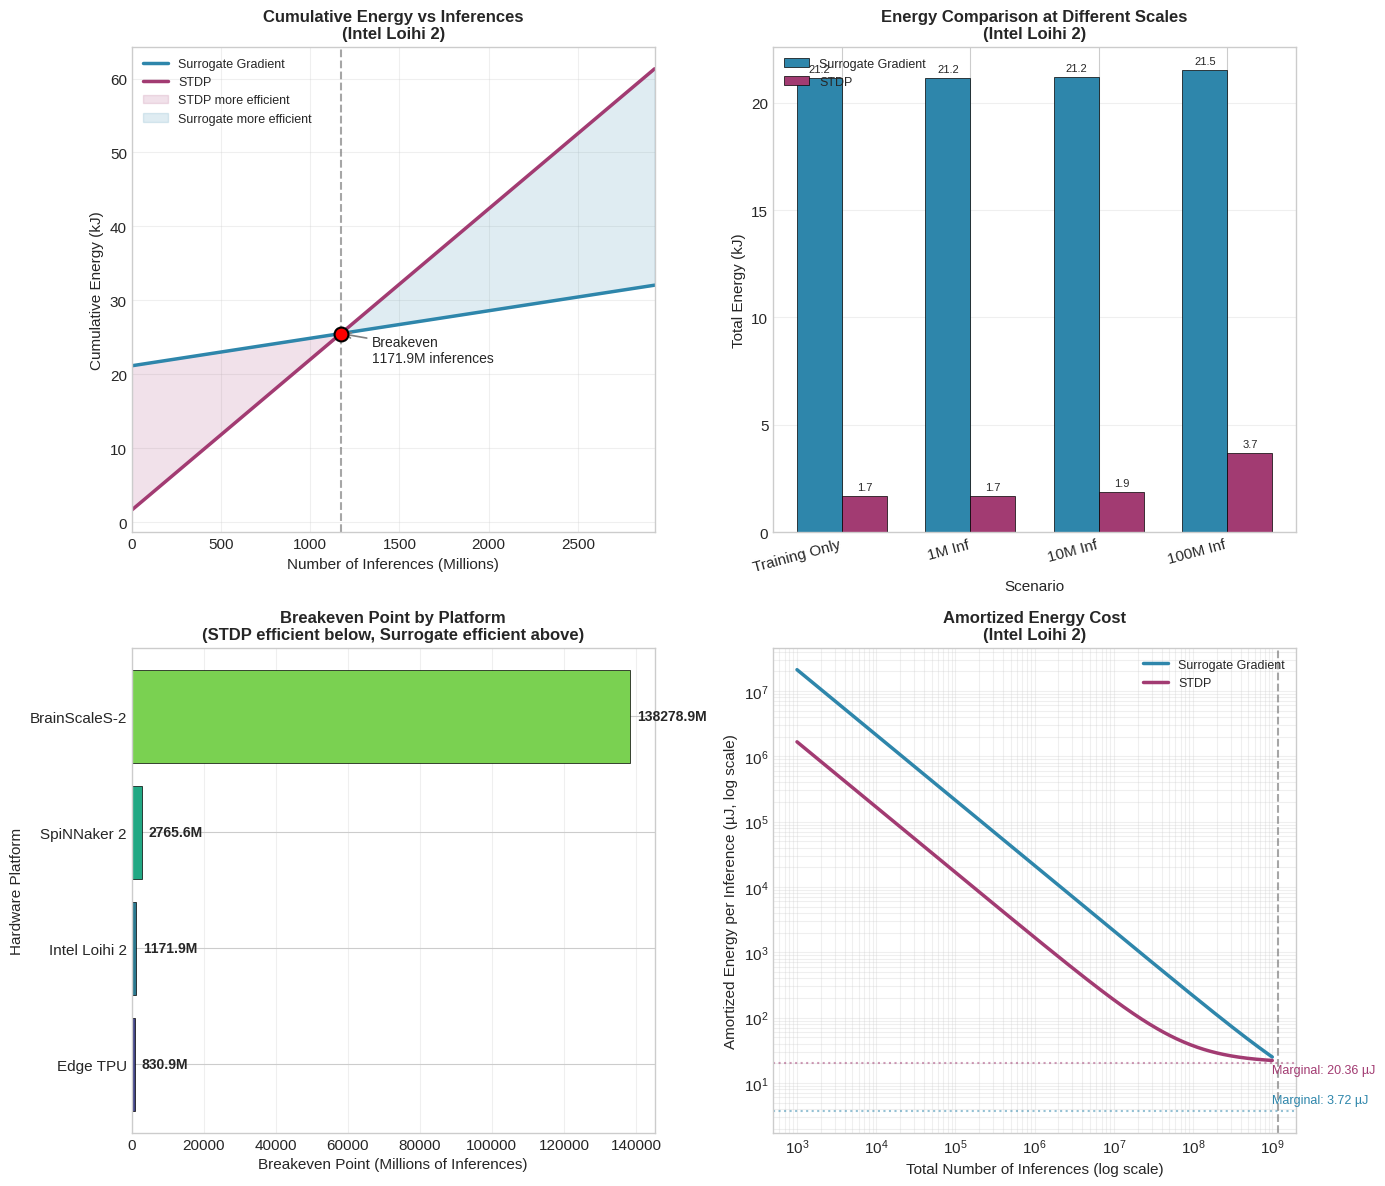


✓ Visualization saved to 'breakeven_analysis_visualization.png'


In [22]:
# =============================================================================
# Block 9b: Cumulative Energy Visualization
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Color scheme
color_surrogate = '#2E86AB'  # Blue
color_stdp = '#A23B72'       # Magenta/Pink

# =============================================================================
# Plot 1: Cumulative Energy Curves (Linear Scale) - Loihi2
# =============================================================================
ax1 = axes[0, 0]

platform = 'loihi2'
result = breakeven_results[platform]

# Generate range around breakeven
N_max = result['N_breakeven'] * 2.5
N_range = np.linspace(0, N_max, 1000)

# Cumulative energy (in Joules)
E_inf_surr_j = result['E_inf_surrogate_uj'] * 1e-6
E_inf_stdp_j = result['E_inf_stdp_uj'] * 1e-6

E_total_surrogate = E_train_surrogate + N_range * E_inf_surr_j
E_total_stdp = E_train_stdp + N_range * E_inf_stdp_j

ax1.plot(N_range/1e6, E_total_surrogate/1000, color=color_surrogate, linewidth=2.5, label='Surrogate Gradient')
ax1.plot(N_range/1e6, E_total_stdp/1000, color=color_stdp, linewidth=2.5, label='STDP')

# Mark breakeven point
E_at_breakeven = E_train_surrogate + result['N_breakeven'] * E_inf_surr_j
ax1.axvline(x=result['N_breakeven']/1e6, color='gray', linestyle='--', alpha=0.7, linewidth=1.5)
ax1.scatter([result['N_breakeven']/1e6], [E_at_breakeven/1000], color='red', s=100, zorder=5, marker='o', edgecolors='black', linewidth=1.5)
ax1.annotate(f'Breakeven\n{result["N_breakeven"]/1e6:.1f}M inferences',
             xy=(result['N_breakeven']/1e6, E_at_breakeven/1000),
             xytext=(result['N_breakeven']/1e6 * 1.15, E_at_breakeven/1000 * 0.85),
             fontsize=10, ha='left',
             arrowprops=dict(arrowstyle='->', color='gray', lw=1.2))

# Shade regions
ax1.fill_between(N_range/1e6, E_total_surrogate/1000, E_total_stdp/1000,
                 where=(N_range < result['N_breakeven']),
                 color=color_stdp, alpha=0.15, label='STDP more efficient')
ax1.fill_between(N_range/1e6, E_total_surrogate/1000, E_total_stdp/1000,
                 where=(N_range >= result['N_breakeven']),
                 color=color_surrogate, alpha=0.15, label='Surrogate more efficient')

ax1.set_xlabel('Number of Inferences (Millions)', fontsize=11)
ax1.set_ylabel('Cumulative Energy (kJ)', fontsize=11)
ax1.set_title(f'Cumulative Energy vs Inferences\n({result["platform_name"]})', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, N_max/1e6)

# =============================================================================
# Plot 2: Energy Comparison Bar Chart (Training vs 10M Inferences)
# =============================================================================
ax2 = axes[0, 1]

# Compare at different inference counts
inference_counts = [0, 1e6, 10e6, 100e6]
labels = ['Training Only', '1M Inf', '10M Inf', '100M Inf']

surr_energies = [E_train_surrogate/1000]  # kJ
stdp_energies = [E_train_stdp/1000]

for N in inference_counts[1:]:
    surr_energies.append((E_train_surrogate + N * E_inf_surr_j)/1000)
    stdp_energies.append((E_train_stdp + N * E_inf_stdp_j)/1000)

x = np.arange(len(labels))
width = 0.35

bars1 = ax2.bar(x - width/2, surr_energies, width, label='Surrogate Gradient', color=color_surrogate, edgecolor='black', linewidth=0.5)
bars2 = ax2.bar(x + width/2, stdp_energies, width, label='STDP', color=color_stdp, edgecolor='black', linewidth=0.5)

ax2.set_xlabel('Scenario', fontsize=11)
ax2.set_ylabel('Total Energy (kJ)', fontsize=11)
ax2.set_title(f'Energy Comparison at Different Scales\n({result["platform_name"]})', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=15, ha='right')
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars1, surr_energies):
    ax2.annotate(f'{val:.1f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=8)
for bar, val in zip(bars2, stdp_energies):
    ax2.annotate(f'{val:.1f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=8)

# =============================================================================
# Plot 3: Breakeven Point Across Platforms
# =============================================================================
ax3 = axes[1, 0]

platforms_sorted = sorted(breakeven_results.keys(), key=lambda p: breakeven_results[p]['N_breakeven'])
platform_names = [breakeven_results[p]['platform_name'] for p in platforms_sorted]
breakeven_values = [breakeven_results[p]['N_breakeven']/1e6 for p in platforms_sorted]

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(platforms_sorted)))
bars = ax3.barh(platform_names, breakeven_values, color=colors, edgecolor='black', linewidth=0.5)

ax3.set_xlabel('Breakeven Point (Millions of Inferences)', fontsize=11)
ax3.set_ylabel('Hardware Platform', fontsize=11)
ax3.set_title('Breakeven Point by Platform\n(STDP efficient below, Surrogate efficient above)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# Add value labels
for bar, val in zip(bars, breakeven_values):
    ax3.annotate(f'{val:.1f}M', xy=(bar.get_width(), bar.get_y() + bar.get_height()/2),
                 xytext=(5, 0), textcoords='offset points', ha='left', va='center', fontsize=10, fontweight='bold')

# =============================================================================
# Plot 4: Energy Efficiency Over Time (Log Scale)
# =============================================================================
ax4 = axes[1, 1]

# Use Loihi2 as reference
platform = 'loihi2'
result = breakeven_results[platform]

# Logarithmic range
N_range_log = np.logspace(3, 9, 500)  # 1K to 1B inferences

E_total_surrogate_log = E_train_surrogate + N_range_log * E_inf_surr_j
E_total_stdp_log = E_train_stdp + N_range_log * E_inf_stdp_j

# Energy per inference (amortized)
E_per_inf_surrogate = E_total_surrogate_log / N_range_log * 1e6  # µJ
E_per_inf_stdp = E_total_stdp_log / N_range_log * 1e6

ax4.loglog(N_range_log, E_per_inf_surrogate, color=color_surrogate, linewidth=2.5, label='Surrogate Gradient')
ax4.loglog(N_range_log, E_per_inf_stdp, color=color_stdp, linewidth=2.5, label='STDP')

# Mark breakeven
ax4.axvline(x=result['N_breakeven'], color='gray', linestyle='--', alpha=0.7, linewidth=1.5)

# Asymptotic lines (marginal inference cost)
ax4.axhline(y=result['E_inf_surrogate_uj'], color=color_surrogate, linestyle=':', alpha=0.5, linewidth=1.5)
ax4.axhline(y=result['E_inf_stdp_uj'], color=color_stdp, linestyle=':', alpha=0.5, linewidth=1.5)

ax4.set_xlabel('Total Number of Inferences (log scale)', fontsize=11)
ax4.set_ylabel('Amortized Energy per Inference (µJ, log scale)', fontsize=11)
ax4.set_title(f'Amortized Energy Cost\n({result["platform_name"]})', fontsize=12, fontweight='bold')
ax4.legend(loc='upper right', fontsize=9)
ax4.grid(True, alpha=0.3, which='both')

# Add annotations
ax4.annotate(f'Marginal: {result["E_inf_surrogate_uj"]:.2f} µJ', xy=(1e9, result['E_inf_surrogate_uj']*1.3),
             fontsize=9, color=color_surrogate)
ax4.annotate(f'Marginal: {result["E_inf_stdp_uj"]:.2f} µJ', xy=(1e9, result['E_inf_stdp_uj']*0.7),
             fontsize=9, color=color_stdp)

plt.tight_layout()
plt.savefig('breakeven_analysis_visualization.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\n✓ Visualization saved to 'breakeven_analysis_visualization.png'")

In [23]:
# =============================================================================
# Block 9b-supplement: Clarifying Note on Platform Differences
# =============================================================================

print("=" * 92)
print("CLARIFYING NOTE: Why BrainScaleS-2 Has Such a High Breakeven Point")
print("=" * 92)

print("""
The breakeven formula is:
    N_breakeven = (E_train_surrogate - E_train_stdp) / (E_inf_STDP - E_inf_surrogate)

The NUMERATOR (training cost difference) is constant across platforms (~{:.0f} J).

The DENOMINATOR (inference cost difference) varies dramatically by hardware efficiency:
""".format(E_train_surrogate - E_train_stdp))

# Show the breakdown
print(f"{'Platform':<18} {'E/spike (pJ)':<14} {'Surr Inf (µJ)':<15} {'STDP Inf (µJ)':<15} {'Δ Inf (µJ)':<12} {'Breakeven':<15}")
print("-" * 95)

for platform in platforms_to_analyze:
    hw = HARDWARE_DB[platform]
    res = breakeven_results[platform]
    delta_inf = res['E_inf_stdp_uj'] - res['E_inf_surrogate_uj']
    print(f"{hw.name:<18} {hw.energy_per_spike_pj:<14.1f} {res['E_inf_surrogate_uj']:<15.4f} "
          f"{res['E_inf_stdp_uj']:<15.4f} {delta_inf:<12.4f} {res['N_breakeven']/1e6:<.1f}M")

print("""
KEY INSIGHT:
────────────
BrainScaleS-2 is an ANALOG accelerated system with ~100x lower energy per spike (0.2 pJ)
compared to digital neuromorphic chips like Loihi 2 (23.6 pJ).

This makes BOTH networks extremely cheap at inference on BrainScaleS-2, so the absolute
energy difference per inference is tiny (~0.14 µJ vs ~16.6 µJ on Loihi 2).

With such a small denominator in the breakeven equation, it takes ~100x MORE inferences
to recoup the fixed training cost difference.

PRACTICAL IMPLICATION:
On ultra-efficient hardware like BrainScaleS-2, training cost dominates the total energy
budget for a very long time. This makes STDP's lower training cost MORE valuable on
efficient hardware, not less!
""")

CLARIFYING NOTE: Why BrainScaleS-2 Has Such a High Breakeven Point

The breakeven formula is:
    N_breakeven = (E_train_surrogate - E_train_stdp) / (E_inf_STDP - E_inf_surrogate)

The NUMERATOR (training cost difference) is constant across platforms (~19501 J).

The DENOMINATOR (inference cost difference) varies dramatically by hardware efficiency:

Platform           E/spike (pJ)   Surr Inf (µJ)   STDP Inf (µJ)   Δ Inf (µJ)   Breakeven      
-----------------------------------------------------------------------------------------------
Intel Loihi 2      23.6           3.7190          20.3604         16.6415      1171.9M
SpiNNaker 2        10.0           1.5758          8.6273          7.0515       2765.6M
BrainScaleS-2      0.2            0.0315          0.1725          0.1410       138278.9M
Edge TPU           2000.0         3.9700          27.4400         23.4700      830.9M

KEY INSIGHT:
────────────
BrainScaleS-2 is an ANALOG accelerated system with ~100x lower energy per spike 

### Block 9c: Sensitivity Analysis

How does the breakeven point change with:
1. **Training cost variations** (different GPU efficiency, training epochs)
2. **Inference cost variations** (network sparsity, hardware improvements)
3. **Accuracy-matched scenarios** (what if STDP achieved same accuracy as Surrogate?)

In [25]:
# =============================================================================
# Block 9c: Sensitivity Analysis
# =============================================================================

print("="*92)
print("SENSITIVITY ANALYSIS: Breakeven Point Variations")
print("="*92)

# Reference values (Loihi2)
platform = 'loihi2'
E_inf_surr_ref = breakeven_results[platform]['E_inf_surrogate_uj'] * 1e-6  # J
E_inf_stdp_ref = breakeven_results[platform]['E_inf_stdp_uj'] * 1e-6  # J
N_breakeven_ref = breakeven_results[platform]['N_breakeven']

# =============================================================================
# Part A: Vary Training Energy
# =============================================================================

print("\n" + "-"*92)
print("A. Training Energy Sensitivity")
print("-"*92)

# Training multipliers (simulating different GPUs, epochs, etc.)
train_multipliers = [0.25, 0.5, 1.0, 2.0, 4.0]

print(f"\n{'Train Multiplier':<18} {'Surr Train (J)':<18} {'STDP Train (J)':<18} {'Breakeven (M)':<15}")
print("-"*75)

sensitivity_train = []
for mult in train_multipliers:
    E_train_surr_mod = E_train_surrogate * mult
    E_train_stdp_mod = E_train_stdp * mult

    delta_train = E_train_surr_mod - E_train_stdp_mod
    delta_inf = E_inf_stdp_ref - E_inf_surr_ref

    if delta_inf > 0:
        N_be = delta_train / delta_inf
        sensitivity_train.append({'multiplier': mult, 'N_breakeven_M': N_be/1e6})
        print(f"{mult:<18.2f} {E_train_surr_mod:<18,.0f} {E_train_stdp_mod:<18,.0f} {N_be/1e6:<15.1f}")

# =============================================================================
# Part B: Vary Inference Energy
# =============================================================================

print("\n" + "-"*92)
print("B. Inference Energy Sensitivity (Sparsity/Efficiency Improvements)")
print("-"*92)

# Inference efficiency improvements (e.g., better sparsity, pruning)
inf_improvement_factors = [0.5, 0.75, 1.0, 1.25, 1.5, 2.0]

print(f"\n{'Surr Efficiency':<16} {'STDP Efficiency':<16} {'Surr Inf (µJ)':<16} {'STDP Inf (µJ)':<16} {'Breakeven (M)':<15}")
print("-"*85)

sensitivity_inf = []
for surr_eff in [0.5, 1.0, 2.0]:
    for stdp_eff in [0.5, 1.0, 2.0]:
        E_inf_surr_mod = E_inf_surr_ref / surr_eff  # Lower = more efficient
        E_inf_stdp_mod = E_inf_stdp_ref / stdp_eff

        delta_inf = E_inf_stdp_mod - E_inf_surr_mod
        delta_train = E_train_surrogate - E_train_stdp

        if delta_inf > 0:
            N_be = delta_train / delta_inf
            sensitivity_inf.append({
                'surr_eff': surr_eff,
                'stdp_eff': stdp_eff,
                'N_breakeven_M': N_be/1e6
            })
            print(f"{surr_eff:<16.1f} {stdp_eff:<16.1f} {E_inf_surr_mod*1e6:<16.4f} {E_inf_stdp_mod*1e6:<16.4f} {N_be/1e6:<15.1f}")
        else:
            print(f"{surr_eff:<16.1f} {stdp_eff:<16.1f} STDP always more efficient (no breakeven)")

# =============================================================================
# Part C: Accuracy-Matched Scenario (STDP trained to match Surrogate accuracy)
# =============================================================================

print("\n" + "-"*92)
print("C. Accuracy-Matched Scenario (STDP trained to match Surrogate accuracy)")
print("-"*92)

# ---- Dynamic estimation of samples needed for target accuracy ----
# Reference points from literature (Diehl & Cook 2015 and our experiments)
reference_points = {
    'samples': [500, 3000, 10000, 180000],
    'accuracy': [19.8, 57.9, 69.3, 95],
}

# Log-linear fit: accuracy = a * log10(samples) + b
log_samples = np.log10(reference_points['samples'])
coeffs = np.polyfit(log_samples, reference_points['accuracy'], 1)

def predict_samples_for_accuracy(target_acc):
    """Predict samples needed for target accuracy using log-linear fit."""
    # acc = a * log10(samples) + b
    # log10(samples) = (acc - b) / a
    log_s = (target_acc - coeffs[1]) / coeffs[0]
    return 10 ** log_s

# Current STDP stats
current_stdp_samples = stdp_stats.training_samples
current_stdp_acc = stdp_stats.inference_accuracy
target_acc = surrogate_stats.inference_accuracy

# Dynamically compute samples needed for target accuracy
samples_for_target = predict_samples_for_accuracy(target_acc)

print(f"\nLog-linear fit: accuracy = {coeffs[0]:.2f} × log₁₀(samples) + {coeffs[1]:.2f}")
print(f"R² of fit: {np.corrcoef(log_samples, reference_points['accuracy'])[0,1]**2:.4f}")

# Scale training energy proportionally
training_scale = samples_for_target / current_stdp_samples
E_train_stdp_matched = E_train_stdp * training_scale

# Recalculate breakeven
delta_train_matched = E_train_surrogate - E_train_stdp_matched
delta_inf = E_inf_stdp_ref - E_inf_surr_ref

if delta_train_matched > 0 and delta_inf > 0:
    N_breakeven_matched = delta_train_matched / delta_inf
    comparison = "Surrogate still has higher training cost"
elif delta_train_matched <= 0:
    N_breakeven_matched = 0
    comparison = "STDP now has HIGHER training cost - Surrogate always wins!"
else:
    N_breakeven_matched = float('inf')
    comparison = "Unexpected case"

print(f"""
To match Surrogate accuracy ({target_acc:.1f}%):
  • STDP needs ~{samples_for_target:,.0f} training samples (vs {current_stdp_samples:,} current)
  • Training scale factor: {training_scale:.1f}x
  • Estimated STDP training energy: {E_train_stdp_matched:,.0f} J (vs {E_train_stdp:,.0f} J current)

Original breakeven: {N_breakeven_ref/1e6:.1f}M inferences
Accuracy-matched breakeven: {N_breakeven_matched/1e6:.1f}M inferences

Interpretation: {comparison}
""")

SENSITIVITY ANALYSIS: Breakeven Point Variations

--------------------------------------------------------------------------------------------
A. Training Energy Sensitivity
--------------------------------------------------------------------------------------------

Train Multiplier   Surr Train (J)     STDP Train (J)     Breakeven (M)  
---------------------------------------------------------------------------
0.25               5,291              416                293.0          
0.50               10,583             832                585.9          
1.00               21,165             1,664              1171.9         
2.00               42,331             3,328              2343.7         
4.00               84,662             6,656              4687.4         

--------------------------------------------------------------------------------------------
B. Inference Energy Sensitivity (Sparsity/Efficiency Improvements)
---------------------------------------------------------

BLOCK 9d: REALISTIC ROI ANALYSIS


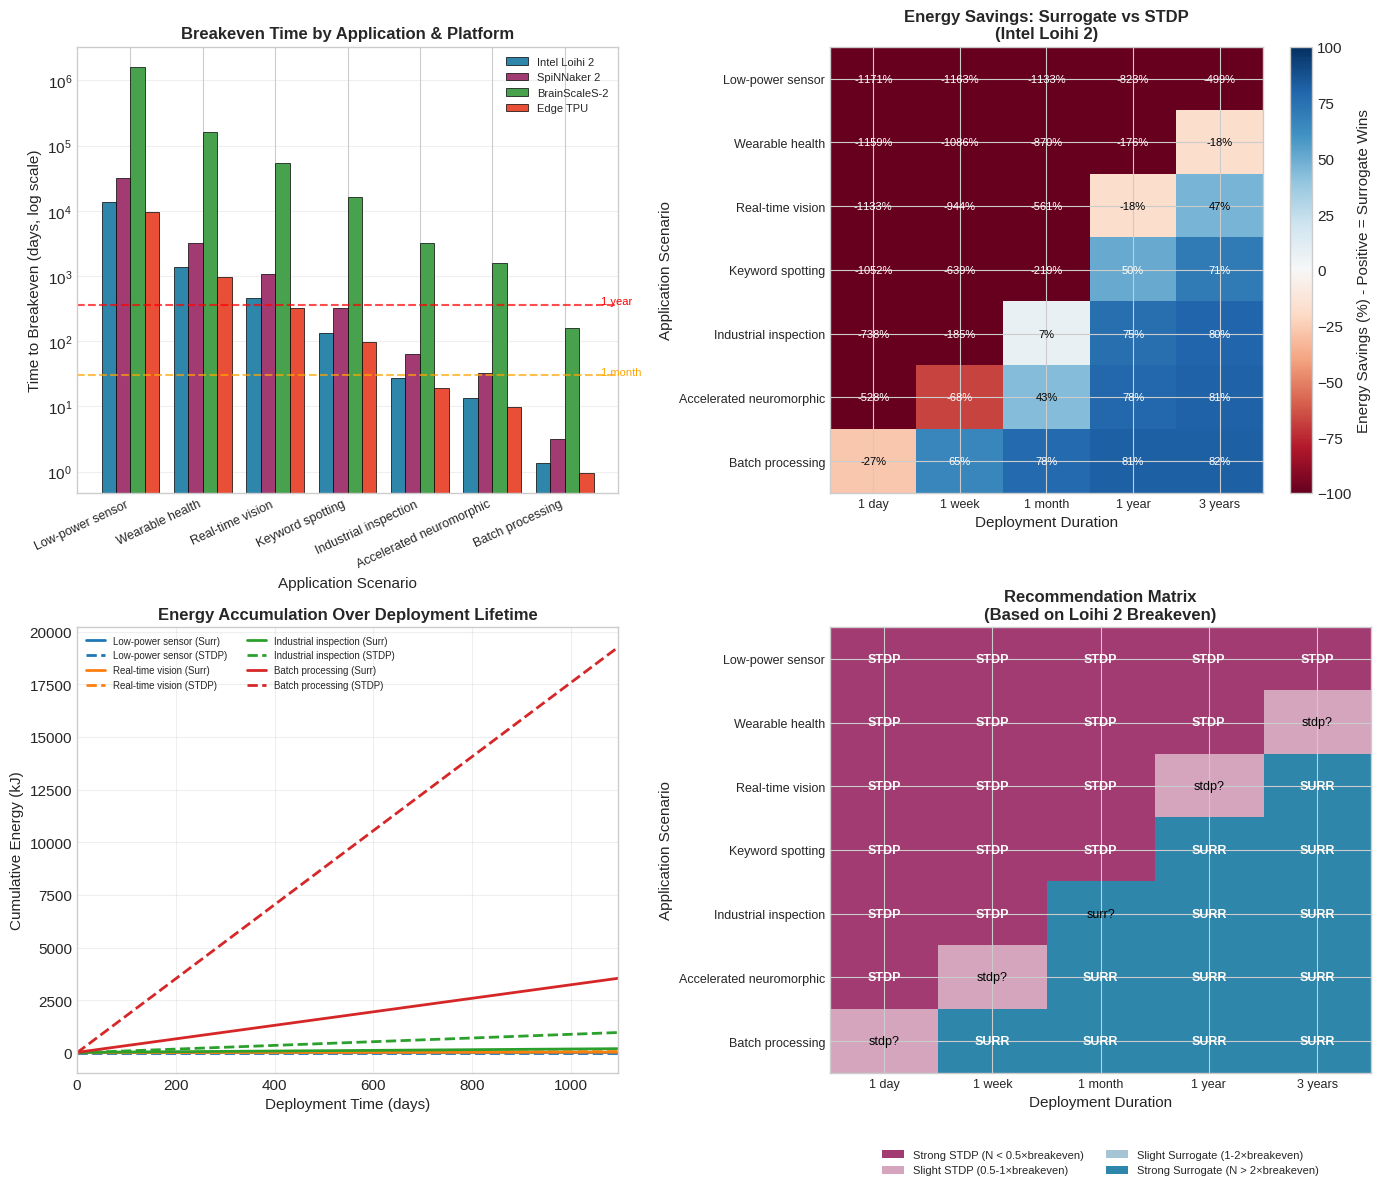


DETAILED ROI SUMMARY TABLE

Platform: Intel Loihi 2
Breakeven: 1171.9M inferences

Scenario                 Rate         1 day       1 week      1 month     1 year      3 years     Recommendation
--------------------------------------------------------------------------------------------------------------
Low-power sensor         1            ◀◀          ◀◀          ◀◀          ◀◀          ◀◀          STDP
Wearable health          10           ◀◀          ◀◀          ◀◀          ◀◀          ◀           STDP
Real-time vision         30           ◀◀          ◀◀          ◀◀          ◀           ▶▶          Surrogate
Keyword spotting         100          ◀◀          ◀◀          ◀◀          ▶▶          ▶▶          Surrogate
Industrial inspection    500          ◀◀          ◀◀          ▶           ▶▶          ▶▶          Surrogate
Accelerated neuromorphic 1000         ◀◀          ◀           ▶▶          ▶▶          ▶▶          Surrogate
Batch processing         10000        ◀           ▶▶  

In [27]:
# =============================================================================
# Block 9d: Sensitivity Heatmaps with Realistic Inference Scenarios
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np

# =============================================================================
# Define realistic inference rate scenarios
# =============================================================================

inference_scenarios = {
    'Low-power sensor': 1,           # Always-on anomaly detection
    'Wearable health': 10,           # ECG/PPG classification
    'Real-time vision': 30,          # Frame-by-frame video
    'Keyword spotting': 100,         # Voice activation
    'Industrial inspection': 500,    # Assembly line QC
    'Accelerated neuromorphic': 1000,# Loihi/SpiNNaker accelerated
    'Batch processing': 10000,       # Offline cloud processing
}

# Deployment durations to consider
deployment_durations = {
    '1 day': 86400,
    '1 week': 86400 * 7,
    '1 month': 86400 * 30,
    '1 year': 86400 * 365,
    '3 years': 86400 * 365 * 3,  # Typical device lifetime
}

print("=" * 92)
print("BLOCK 9d: REALISTIC ROI ANALYSIS")
print("=" * 92)

# =============================================================================
# Figure 1: Breakeven Time Across Application Scenarios
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# --- Plot 1: Breakeven time by application scenario (all platforms) ---
ax1 = axes[0, 0]

scenario_names = list(inference_scenarios.keys())
scenario_rates = list(inference_scenarios.values())

# Calculate breakeven time for each platform and scenario
platform_colors = {
    'loihi2': '#2E86AB',
    'spinnaker2': '#A23B72',
    'brainscales2': '#48A14D',
    'edge_tpu': '#E94F37',
}

x = np.arange(len(scenario_names))
width = 0.2
offsets = [-1.5, -0.5, 0.5, 1.5]

for idx, (platform, color) in enumerate(platform_colors.items()):
    N_be = breakeven_results[platform]['N_breakeven']
    breakeven_days = [N_be / rate / 86400 for rate in scenario_rates]

    bars = ax1.bar(x + offsets[idx] * width, breakeven_days, width,
                   label=breakeven_results[platform]['platform_name'],
                   color=color, edgecolor='black', linewidth=0.5)

ax1.set_xlabel('Application Scenario', fontsize=11)
ax1.set_ylabel('Time to Breakeven (days, log scale)', fontsize=11)
ax1.set_title('Breakeven Time by Application & Platform', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(scenario_names, rotation=25, ha='right', fontsize=9)
ax1.set_yscale('log')
ax1.legend(loc='upper right', fontsize=8)
ax1.grid(True, alpha=0.3, axis='y')

# Add reference lines for deployment durations
ax1.axhline(y=30, color='orange', linestyle='--', alpha=0.7, linewidth=1.5)
ax1.axhline(y=365, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
ax1.annotate('1 month', xy=(len(scenario_names)-0.5, 30), fontsize=8, color='orange')
ax1.annotate('1 year', xy=(len(scenario_names)-0.5, 365), fontsize=8, color='red')

# --- Plot 2: ROI heatmap (Scenario vs Deployment Duration) ---
ax2 = axes[0, 1]

# Use Loihi 2 as reference platform
platform = 'loihi2'
E_inf_surr = breakeven_results[platform]['E_inf_surrogate_uj'] * 1e-6  # J
E_inf_stdp = breakeven_results[platform]['E_inf_stdp_uj'] * 1e-6  # J

# Create ROI grid: rows = scenarios, cols = durations
roi_grid = np.zeros((len(inference_scenarios), len(deployment_durations)))
duration_names = list(deployment_durations.keys())
duration_seconds = list(deployment_durations.values())

for i, (scenario, rate) in enumerate(inference_scenarios.items()):
    for j, (dur_name, dur_sec) in enumerate(deployment_durations.items()):
        N_total = rate * dur_sec

        E_total_surr = E_train_surrogate + N_total * E_inf_surr
        E_total_stdp = E_train_stdp + N_total * E_inf_stdp

        # ROI: positive = Surrogate saves energy (% savings)
        if E_total_stdp > 0:
            roi_grid[i, j] = (E_total_stdp - E_total_surr) / E_total_stdp * 100
        else:
            roi_grid[i, j] = 0

# Plot heatmap
im2 = ax2.imshow(roi_grid, aspect='auto', cmap='RdBu',
                  vmin=-100, vmax=100)
cbar2 = plt.colorbar(im2, ax=ax2, label='Energy Savings (%) - Positive = Surrogate Wins')

ax2.set_xticks(np.arange(len(duration_names)))
ax2.set_yticks(np.arange(len(scenario_names)))
ax2.set_xticklabels(duration_names, fontsize=9)
ax2.set_yticklabels(scenario_names, fontsize=9)
ax2.set_xlabel('Deployment Duration', fontsize=11)
ax2.set_ylabel('Application Scenario', fontsize=11)
ax2.set_title(f'Energy Savings: Surrogate vs STDP\n({breakeven_results[platform]["platform_name"]})',
              fontsize=12, fontweight='bold')

# Add text annotations
for i in range(len(scenario_names)):
    for j in range(len(duration_names)):
        val = roi_grid[i, j]
        color = 'white' if abs(val) > 50 else 'black'
        ax2.text(j, i, f'{val:.0f}%', ha='center', va='center', fontsize=8, color=color)

# --- Plot 3: Cumulative energy over time for different scenarios ---
ax3 = axes[1, 0]

# Time axis (in days)
time_days = np.linspace(0, 365 * 3, 500)  # 3 years
time_seconds = time_days * 86400

# Select a few representative scenarios
scenarios_to_plot = ['Low-power sensor', 'Real-time vision', 'Industrial inspection', 'Batch processing']
linestyles_surr = ['-', '-', '-', '-']
linestyles_stdp = ['--', '--', '--', '--']
colors_scenario = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, scenario in enumerate(scenarios_to_plot):
    rate = inference_scenarios[scenario]
    N_over_time = rate * time_seconds

    E_surr_over_time = (E_train_surrogate + N_over_time * E_inf_surr) / 1000  # kJ
    E_stdp_over_time = (E_train_stdp + N_over_time * E_inf_stdp) / 1000  # kJ

    ax3.plot(time_days, E_surr_over_time, linestyle='-', color=colors_scenario[idx],
             linewidth=2, label=f'{scenario} (Surr)')
    ax3.plot(time_days, E_stdp_over_time, linestyle='--', color=colors_scenario[idx],
             linewidth=2, label=f'{scenario} (STDP)')

ax3.set_xlabel('Deployment Time (days)', fontsize=11)
ax3.set_ylabel('Cumulative Energy (kJ)', fontsize=11)
ax3.set_title('Energy Accumulation Over Deployment Lifetime', fontsize=12, fontweight='bold')
ax3.legend(loc='upper left', fontsize=7, ncol=2)
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, 365 * 3)

# --- Plot 4: Recommendation matrix ---
ax4 = axes[1, 1]

# Create recommendation grid
rec_grid = np.zeros((len(inference_scenarios), len(deployment_durations)))

for i, (scenario, rate) in enumerate(inference_scenarios.items()):
    N_be = breakeven_results['loihi2']['N_breakeven']
    for j, (dur_name, dur_sec) in enumerate(deployment_durations.items()):
        N_total = rate * dur_sec

        if N_total < N_be * 0.5:
            rec_grid[i, j] = -1  # Strong STDP
        elif N_total < N_be:
            rec_grid[i, j] = -0.5  # Slight STDP
        elif N_total < N_be * 2:
            rec_grid[i, j] = 0.5  # Slight Surrogate
        else:
            rec_grid[i, j] = 1  # Strong Surrogate

# Custom colormap
from matplotlib.colors import LinearSegmentedColormap
colors_rec = ['#A23B72', '#D4A5BD', '#A5C4D4', '#2E86AB']
cmap_rec = LinearSegmentedColormap.from_list('rec', colors_rec, N=4)

im4 = ax4.imshow(rec_grid, aspect='auto', cmap=cmap_rec, vmin=-1, vmax=1)

ax4.set_xticks(np.arange(len(duration_names)))
ax4.set_yticks(np.arange(len(scenario_names)))
ax4.set_xticklabels(duration_names, fontsize=9)
ax4.set_yticklabels(scenario_names, fontsize=9)
ax4.set_xlabel('Deployment Duration', fontsize=11)
ax4.set_ylabel('Application Scenario', fontsize=11)
ax4.set_title('Recommendation Matrix\n(Based on Loihi 2 Breakeven)', fontsize=12, fontweight='bold')

# Add text annotations
rec_labels = {-1: 'STDP', -0.5: 'stdp?', 0.5: 'surr?', 1: 'SURR'}
for i in range(len(scenario_names)):
    for j in range(len(duration_names)):
        val = rec_grid[i, j]
        label = rec_labels[val]
        color = 'white' if abs(val) == 1 else 'black'
        ax4.text(j, i, label, ha='center', va='center', fontsize=9,
                 color=color, fontweight='bold' if abs(val) == 1 else 'normal')

# Add legend manually
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#A23B72', label='Strong STDP (N < 0.5×breakeven)'),
    Patch(facecolor='#D4A5BD', label='Slight STDP (0.5-1×breakeven)'),
    Patch(facecolor='#A5C4D4', label='Slight Surrogate (1-2×breakeven)'),
    Patch(facecolor='#2E86AB', label='Strong Surrogate (N > 2×breakeven)'),
]
ax4.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15),
           ncol=2, fontsize=8)

plt.tight_layout()
plt.savefig('breakeven_realistic_roi_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# =============================================================================
# Print detailed summary table
# =============================================================================

print("\n" + "=" * 92)
print("DETAILED ROI SUMMARY TABLE")
print("=" * 92)

print(f"\nPlatform: {breakeven_results['loihi2']['platform_name']}")
print(f"Breakeven: {breakeven_results['loihi2']['N_breakeven']/1e6:.1f}M inferences\n")

print(f"{'Scenario':<24} {'Rate':<12} ", end="")
for dur in duration_names:
    print(f"{dur:<12}", end="")
print("Recommendation")
print("-" * 110)

for scenario, rate in inference_scenarios.items():
    print(f"{scenario:<24} {rate:<12} ", end="")

    N_be = breakeven_results['loihi2']['N_breakeven']
    rec = "STDP"  # default

    for dur_name, dur_sec in deployment_durations.items():
        N_total = rate * dur_sec
        ratio = N_total / N_be

        if ratio < 0.5:
            symbol = "◀◀"  # Strong STDP
        elif ratio < 1:
            symbol = "◀"   # Slight STDP
        elif ratio < 2:
            symbol = "▶"   # Slight Surrogate
            rec = "Consider"
        else:
            symbol = "▶▶"  # Strong Surrogate
            rec = "Surrogate"

        print(f"{symbol:<12}", end="")

    print(rec)

print("""
Legend: ◀◀ = Strong STDP | ◀ = Slight STDP | ▶ = Slight Surrogate | ▶▶ = Strong Surrogate

NOTE ON INFERENCE RATES:
────────────────────────
- 'Inference' = classifying one 28×28 MNIST image through the network
- Surrogate: 50ms biological time per inference (max ~20 inf/s real-time)
- STDP: 350ms biological time per inference (max ~3 inf/s real-time)
- Neuromorphic hardware runs 10-1000× faster than biological real-time
""")

print("\n✓ Visualization saved to 'breakeven_realistic_roi_analysis.png'")

In [28]:
# =============================================================================
# Block 9e: Summary Table and Recommendations
# =============================================================================

print("="*92)
print("BREAKEVEN ANALYSIS SUMMARY")
print("="*92)

# Create summary DataFrame
summary_data = []

for platform, result in breakeven_results.items():
    # Calculate various deployment scenarios
    N_be = result['N_breakeven']

    # Continuous inference scenarios
    scenarios = {
        '1 inf/s': N_be / 1,
        '100 inf/s': N_be / 100,
        '1k inf/s': N_be / 1000,
        '10k inf/s': N_be / 10000,
    }

    summary_data.append({
        'Platform': result['platform_name'],
        'Breakeven (inferences)': f"{N_be/1e6:.1f}M",
        'Time @ 1 inf/s': f"{scenarios['1 inf/s']/86400:.0f} days",
        'Time @ 100 inf/s': f"{scenarios['100 inf/s']/3600:.1f} hours",
        'Time @ 1k inf/s': f"{scenarios['1k inf/s']/60:.1f} min",
        'Time @ 10k inf/s': f"{scenarios['10k inf/s']:.0f} sec",
    })

df_breakeven = pd.DataFrame(summary_data)
display(df_breakeven)

# =============================================================================
# Decision Framework
# =============================================================================

print("\n" + "="*92)
print("DECISION FRAMEWORK")
print("="*92)

ref = breakeven_results['loihi2']

print(f"""
┌─────────────────────────────────────────────────────────────────────────────────────────┐
│                         WHEN TO USE EACH APPROACH                                       │
├─────────────────────────────────────────────────────────────────────────────────────────┤
│                                                                                         │
│  ★ CHOOSE STDP WHEN:                                                                    │
│    • Total expected inferences < {ref['N_breakeven']/1e6:.0f}M                                               │
│    • Research/prototyping with limited deployment                                       │
│    • Edge devices with infrequent inference (< 1000/sec)                                │
│    • Training resources are limited (no GPU cluster)                                    │
│    • Online/continual learning is required                                              │
│                                                                                         │
│  ★ CHOOSE SURROGATE GRADIENT WHEN:                                                      │
│    • Total expected inferences > {ref['N_breakeven']/1e6:.0f}M                                               │
│    • Production deployment with continuous inference                                    │
│    • Cloud/server deployment (high inference rate)                                      │
│    • GPU training resources are available                                               │
│    • Higher accuracy is required ({surrogate_stats.inference_accuracy:.1f}% vs {stdp_stats.inference_accuracy:.1f}%)                              │
│                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────┤
│                                                                                         │
│  EXAMPLE DEPLOYMENT SCENARIOS:                                                          │
│                                                                                         │
│    Scenario                      Rate        Time to Breakeven    Recommendation        │
│    ─────────────────────────────────────────────────────────────────────────────        │
│    Smart sensor (low duty)       1 inf/s     {ref['N_breakeven']/86400:>6.0f} days          STDP              │
│    Wearable device               100 inf/s   {ref['N_breakeven']/100/3600:>6.1f} hours         Consider both     │
│    Edge AI camera                1k inf/s    {ref['N_breakeven']/1000/60:>6.1f} min           Surrogate         │
│    Cloud inference               10k inf/s   {ref['N_breakeven']/10000:>6.1f} sec            Surrogate         │
│                                                                                         │
└─────────────────────────────────────────────────────────────────────────────────────────┘
""")

# =============================================================================
# Save results
# =============================================================================

# Save breakeven results to CSV
df_breakeven.to_csv('breakeven_analysis_results.csv', index=False)

# Save detailed results
detailed_results = {
    'training_energy': {
        'surrogate_J': E_train_surrogate,
        'stdp_J': E_train_stdp,
        'ratio': E_train_surrogate / E_train_stdp,
    },
    'breakeven_by_platform': breakeven_results,
    'accuracy': {
        'surrogate': surrogate_stats.inference_accuracy,
        'stdp': stdp_stats.inference_accuracy,
    }
}

import pickle
with open('breakeven_analysis_detailed.pkl', 'wb') as f:
    pickle.dump(detailed_results, f)

print("\n✓ Results saved:")
print("  - breakeven_analysis_results.csv")
print("  - breakeven_analysis_detailed.pkl")
print("  - breakeven_analysis_visualization.png")
print("  - breakeven_sensitivity_heatmaps.png")
print("\n" + "="*92)
print("BLOCK 9: Breakeven Analysis Complete")
print("="*92)

BREAKEVEN ANALYSIS SUMMARY


Platform Breakeven (inferences) Time @ 1 inf/s Time @ 100 inf/s Time @ 1k inf/s Time @ 10k inf/s
0  Intel Loihi 2                1171.9M     13563 days     3255.2 hours     19530.9 min       117185 sec
1    SpiNNaker 2                2765.6M     32009 days     7682.2 hours     46093.0 min       276558 sec
2  BrainScaleS-2              138278.9M   1600450 days   384108.0 hours   2304647.8 min     13827887 sec
3       Edge TPU                 830.9M      9617 days     2308.1 hours     13848.5 min        83091 sec


DECISION FRAMEWORK

┌─────────────────────────────────────────────────────────────────────────────────────────┐
│                         WHEN TO USE EACH APPROACH                                       │
├─────────────────────────────────────────────────────────────────────────────────────────┤
│                                                                                         │
│  ★ CHOOSE STDP WHEN:                                                                    │
│    • Total expected inferences < 1172M                                               │
│    • Research/prototyping with limited deployment                                       │
│    • Edge devices with infrequent inference (< 1000/sec)                                │
│    • Training resources are limited (no GPU cluster)                                    │
│    • Online/continual learning is required                                              │
│                                                             

---
## Bonus Section: Proposed Experimental Framework for Generalization and Operational Cost Analysis Using MNIST and MNIST-C

### Motivation

The preceding breakeven analysis assumes a stationary data distribution, where networks are trained and evaluated on identically distributed samples. However, real-world deployments frequently encounter distribution shifts arising from sensor degradation, environmental variations, or domain transfer. To rigorously evaluate the comparative robustness and operational efficiency of Spike-Timing-Dependent Plasticity (STDP) and Surrogate Gradient networks under realistic conditions, we propose a systematic experimental framework utilizing the MNIST-C (Corrupted MNIST) benchmark dataset.

### Dataset Description

**MNIST-C** (Mu & Gilmer, 2019) extends the standard MNIST test set with 15 corruption types at varying severity levels, providing a controlled testbed for evaluating model robustness to distribution shift. The corruptions are organized into four categories:

1. **Noise corruptions**: Shot noise, impulse noise, and speckle noise, simulating sensor noise and transmission errors commonly encountered in neuromorphic vision sensors.

2. **Blur corruptions**: Glass blur, motion blur, and defocus blur, representing optical aberrations and motion artifacts relevant to event-based camera deployments.

3. **Geometric transformations**: Scale, rotation, shear, and translate, modeling viewpoint variations and mechanical misalignment in edge devices.

4. **Digital corruptions**: Brightness, contrast, saturate, and JPEG compression, simulating image preprocessing artifacts and bandwidth-limited transmission.

Each corruption is applied at five severity levels (1–5), enabling fine-grained analysis of graceful degradation characteristics.

### Experimental Design

#### Phase 1: Baseline Training

Both networks shall be trained exclusively on the clean MNIST training set under matched computational budgets:

- **Surrogate Gradient Network**: Train for 6 epochs using backpropagation through time with a surrogate gradient function (fast sigmoid, σ = 10). Architecture: 784–400–10 with leaky integrate-and-fire neurons, 50 ms temporal window.

- **STDP Network**: Train for 60,000 sample presentations using the Diehl & Cook (2015) architecture with adaptive thresholds and lateral inhibition. Architecture: 784–400 excitatory/inhibitory with 350 ms presentation window.

Training energy consumption shall be recorded using hardware-specific energy models as established in the preceding analysis.

#### Phase 2: Generalization Evaluation (No Retraining)

Evaluate both trained networks on:
1. Clean MNIST test set (in-distribution baseline)
2. All 15 MNIST-C corruptions × 5 severity levels (75 evaluation conditions)

For each condition, record:
- Classification accuracy
- Total spike count per inference
- Inference energy consumption (per hardware platform)
- Confidence calibration metrics (expected calibration error)

This phase quantifies the "zero-shot" robustness of each learning rule to distribution shift without any adaptation.

#### Phase 3: Adaptation Protocols

To simulate real-world deployment scenarios where models must adapt to distribution shift, implement three adaptation protocols:

**Protocol A: Full Retraining (Surrogate Gradient baseline)**
Retrain the Surrogate network from scratch on a mixed dataset comprising 50% clean MNIST and 50% corrupted samples from the target corruption type. Record total training energy and final accuracy.

**Protocol B: Fine-Tuning (Surrogate Gradient)**
Initialize from the clean-trained checkpoint and fine-tune for 1–3 epochs on corrupted samples only. Evaluate catastrophic forgetting by measuring accuracy degradation on clean test samples post-adaptation.

**Protocol C: Online Adaptation (STDP)**
Present corrupted samples sequentially to the trained STDP network with plasticity enabled. Measure:
- Samples required to recover baseline-equivalent accuracy
- Energy consumed during adaptation
- Retention of clean-distribution performance (forgetting metric)

**Protocol D: Continual Learning (Both)**
Simulate a deployment scenario with gradual distribution shift by presenting interleaved clean and corrupted samples over an extended period. Evaluate steady-state accuracy and cumulative energy consumption.

#### Phase 4: Operational Cost Analysis

For each corruption type and adaptation protocol, compute the total operational cost over simulated deployment periods of 1 day, 1 month, and 1 year, assuming:

$$E_{total} = E_{train} + N_{adapt} \cdot E_{retrain} + N_{inf} \cdot E_{inference}$$

where $N_{adapt}$ represents the number of adaptation cycles triggered by distribution shift detection, and $N_{inf}$ is the total inference count determined by application-specific duty cycles.

Model distribution shift detection as a monitoring system that triggers retraining when a sliding-window accuracy estimate falls below a threshold (e.g., 5% degradation from baseline).

### Proposed Metrics

1. **Robustness Index (RI)**: Mean accuracy across all corruptions normalized by clean accuracy, quantifying inherent generalization:
$$RI = \frac{1}{|C|} \sum_{c \in C} \frac{Acc_c}{Acc_{clean}}$$

2. **Adaptation Efficiency (AE)**: Accuracy recovered per joule of adaptation energy:
$$AE = \frac{\Delta Acc}{E_{adapt}}$$

3. **Forgetting Ratio (FR)**: Relative accuracy loss on clean distribution after adaptation:
$$FR = \frac{Acc_{clean}^{pre} - Acc_{clean}^{post}}{Acc_{clean}^{pre}}$$

4. **Break-even Corruption Severity (BECS)**: The corruption severity level at which STDP's total operational cost (training + inference + adaptation) equals that of Surrogate Gradient over a specified deployment period.

5. **Effective Accuracy per Joule (EAJ)**: A unified efficiency metric combining accuracy and energy:
$$EAJ = \frac{Acc \times N_{inf}}{E_{total}}$$

### Hypotheses

Based on the theoretical properties of local versus global learning rules, we advance the following hypotheses:

**H1**: STDP networks will exhibit superior robustness to noise corruptions due to the inherent noise tolerance of spike-timing-based computation, but may underperform on geometric transformations requiring precise spatial feature encoding.

**H2**: The adaptation efficiency of STDP will exceed that of Surrogate Gradient by at least one order of magnitude, as local plasticity rules require only forward passes through new data without gradient computation or replay buffers.

**H3**: Surrogate Gradient networks will demonstrate significant catastrophic forgetting (FR > 0.15) under Protocol B and D, while STDP networks will maintain stable performance on previously learned distributions (FR < 0.05).

**H4**: The break-even inference count will decrease monotonically with corruption severity, as increased adaptation frequency amplifies STDP's training efficiency advantage.

**H5**: For deployment scenarios requiring adaptation more frequently than monthly, STDP will achieve lower total operational cost across all neuromorphic hardware platforms, independent of inference rate.

### Statistical Analysis Plan

All experiments shall be repeated with 5 random seeds to quantify variance. Statistical comparisons will employ:
- Paired t-tests for within-corruption accuracy comparisons
- Two-way ANOVA (Network × Corruption Type) for interaction effects
- Bootstrap confidence intervals (95%) for energy estimates
- Benjamini-Hochberg correction for multiple comparisons across corruption types

### Limitations and Considerations

This proposed framework has several limitations that should be acknowledged:

1. **Synthetic corruptions**: MNIST-C corruptions, while systematic, may not fully capture the complexity of real-world distribution shifts encountered in deployed neuromorphic systems.

2. **Scale constraints**: The MNIST task is relatively simple; generalization to more complex datasets (CIFAR-10-C, ImageNet-C) may reveal different comparative dynamics.

3. **Hardware modeling**: Energy estimates are based on published specifications and architectural models rather than direct hardware measurements, introducing potential systematic biases.

4. **Adaptation detection**: The assumption of perfect distribution shift detection is optimistic; real deployments must additionally account for monitoring overhead and false-positive adaptation triggers.

Future work should validate these findings on physical neuromorphic hardware and extend the analysis to event-based vision datasets (N-MNIST, DVS-Gesture) that more naturally align with spiking network computation.

### References

- Diehl, P. U., & Cook, M. (2015). Unsupervised learning of digit recognition using spike-timing-dependent plasticity. *Frontiers in Computational Neuroscience*, 9, 99.
- Mu, N., & Gilmer, J. (2019). MNIST-C: A robustness benchmark for computer vision. *arXiv preprint arXiv:1906.02337*.
- Neftci, E. O., Mostafa, H., & Zenke, F. (2019). Surrogate gradient learning in spiking neural networks. *IEEE Signal Processing Magazine*, 36(6), 51–63.
- Davies, M., et al. (2018). Loihi: A neuromorphic manycore processor with on-chip learning. *IEEE Micro*, 38(1), 82–99.